In [1]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)

# cat_features = []
# train_df[cat_features] = train_df[cat_features].astype('category')
# test_df[cat_features] = test_df[cat_features].astype('category')

train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

In [2]:
train_df

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price,wc_decimal_count
0,3,0,1,7,1,0,2,0,11.611723,112.15875,15
1,3,3,0,10,1,1,1,4,27.078537,68.88056,14
2,4,0,0,2,1,0,1,2,16.643760,39.17320,15
3,2,1,0,8,1,0,1,4,12.937220,80.60793,15
4,0,3,1,1,1,1,1,4,17.749338,86.02312,15
...,...,...,...,...,...,...,...,...,...,...,...
3994313,2,3,-1,3,1,1,1,5,28.098120,104.74460,15
3994314,1,0,0,10,1,1,2,5,17.379531,122.39043,14
3994315,3,3,2,10,0,0,0,2,17.037708,148.18470,15
3994316,1,3,-1,2,0,0,0,1,28.783339,22.32269,14


In [3]:
# col1 = 'brand'
col1 = 'material'
col2 = 'is_waterproof'
stats = ['mean', 'skew', 'var', 'count']

agg_stats = train_df.groupby(col1)[col2].agg(stats)
agg_stats

,mean,skew,var,count
material,,,,
-1,0.482679,-0.208553,0.276631,110962
0,0.470462,-0.320208,0.296113,976186
1,0.468796,-0.316200,0.296348,942656
2,0.468634,-0.333528,0.298894,1060882
3,0.468095,-0.309644,0.295763,903632


In [4]:
import itertools

best_pairs = ['material_is_waterproof', 'material_laptop_compartment', 'material_size', 'material_style', 'is_waterproof_color', 'style_color',]

cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']
for col1, col2 in itertools.combinations(cols, 2):
    combined_col_name = f"{col1}_{col2}"

    if combined_col_name not in best_pairs:
        continue

    train_df[combined_col_name] = (
        train_df[col1].astype(str) + "_" + train_df[col2].astype(str)
    )#.astype('category')

    test_df[combined_col_name] = (
        test_df[col1].astype(str) + "_" + test_df[col2].astype(str)
    )#.astype('category')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 17 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   brand                        int32  
 1   material                     int32  
 2   size                         int32  
 3   compartments                 int32  
 4   laptop_compartment           int32  
 5   is_waterproof                int32  
 6   style                        int32  
 7   color                        int32  
 8   weight_capacity              float64
 9   price                        float64
 10  wc_decimal_count             int64  
 11  material_size                object 
 12  material_laptop_compartment  object 
 13  material_is_waterproof       object 
 14  material_style               object 
 15  is_waterproof_color          object 
 16  style_color                  object 
dtypes: float64(2), int32(8), int64(1), object(6)
memory usage: 396.2+ MB


In [6]:
# %%time

lgb_params_1 = {'force_col_wise': True, 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'early_stopping_rounds': 916, 'cat_l2': 40.57932515907615, 'extra_trees': False, 'feature_fraction': 0.9028265875188044, 'learning_rate': 0.02133798565133846, 'max_bin': 7449, 'max_depth': 590, 'min_samples_leaf': 22, 'n_estimators': 14706, 'num_leaves': 141, 'lambda_l1': 0.004931837373939155, 'lambda_l2': 2.1647829905701264e-06}

stats = ['mean', 'skew', 'count', 'var']
FOLDS = 20

# Target sets use the target variable, and must be trained on the inner CV loop.
target_feature_sets = {
    'ts1': {
        'col1': "weight_capacity",
        'stats': stats,
    },
    'ts2': {
        'col1': "compartments",
        'stats': stats,
    },
    'ts22': {
        'col1': "brand",
        'stats': stats,
    },
    'ts3': {
        'col1': "material_is_waterproof",
        'stats': stats,
    },
    'ts4': {
        'col1': "material_laptop_compartment",
        'stats': stats,
    },
    'ts5': {
        'col1': "is_waterproof_color",
        'stats': stats,
    },
    'ts6': {
        'col1': "style_color",
        'stats': stats,
    },
}
all_new_cols = []
for k, v in target_feature_sets.items():
    new_cols = [f"{v['col1']}_{target}_{stat}" for stat in stats]
    target_feature_sets[k]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

feature_sets = {
    'fs1': {
        'col1': "material",
        'col2_list': ['is_waterproof', 'laptop_compartment', 'style', 'size'],
        'stats': stats,
    },
}
for k, v in feature_sets.items():
    col1 = v['col1']
    col2_list = v['col2_list']
    new_cols = [f"{col1}_{col2}_{stat}" for col2 in col2_list for stat in stats]
    feature_sets[k]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

features = [
    'weight_capacity', 'compartments', 'wc_decimal_count',
    'laptop_compartment', 'is_waterproof', 'brand', 'color', 'size', 'material', 'style' 
] + all_new_cols


# Prepare arrays for out-of-fold and test predictions
oof = np.zeros(len(train_df), dtype=float)
pred = np.zeros(len(test_df), dtype=float)

rmse_list = []

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
for i, (train_idx, valid_idx) in enumerate(kf.split(train_df), 1):
    train_fold = train_df.loc[train_idx].reset_index(drop=True)
    valid_fold = train_df.loc[valid_idx].reset_index(drop=True)

    # -----------------------------------------------------
    # Inner K-Fold (for partial target encoding)
    # -----------------------------------------------------
    kf_inner = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    for j, (inner_train_idx, inner_valid_idx) in enumerate(kf_inner.split(train_fold)):
        inner_train = train_fold.loc[inner_train_idx].copy()

        for k, v in target_feature_sets.items():
            stats = v['stats']
            col1 = v['col1']
            new_cols = v['new_cols']
            agg_stats = inner_train.groupby(col1)[target].agg(stats)
            for stat, new_col in zip(stats, new_cols):
                train_fold.loc[inner_valid_idx, new_col] = train_fold.loc[inner_valid_idx, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Outer K-Fold Add Feature Sets
    # -----------------------------------------------------
    for k, v in target_feature_sets.items():
        stats = v['stats']
        col1 = v['col1']
        new_cols = v['new_cols']
        agg_stats = inner_train.groupby(col1)[target].agg(stats)
        for stat, new_col in zip(stats, new_cols):
            valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
            test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    for k, v in feature_sets.items():
        stats = v['stats']
        col1 = v['col1']
        col2_list = v['col2_list']
        new_cols = v['new_cols']
        for i, col2 in enumerate(col2_list):
            agg_stats = inner_train.groupby(col1)[col2].agg(stats)
            for stat, new_col in zip(stats, new_cols[i*len(stats):(i+1)*len(stats)]):
                train_fold.loc[:, new_col] = train_fold.loc[:, col1].map(agg_stats[stat])
                valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
                test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Modeling
    # -----------------------------------------------------
    train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
    valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
    
    model = lgb.train(
        params=lgb_params_1,
        train_set=train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
    )
    y_pred = model.predict(valid_fold[features], num_iteration=model.best_iteration)
    
    rmse = root_mean_squared_error(valid_fold[target], y_pred)
    rmse_list.append(rmse)
    print(f"[i] RMSE: {rmse:.2f}")

    # TODO use OOF for ensemble models
    oof[valid_idx] = y_pred
    pred += model.predict(test_df[features], num_iteration=model.best_iteration)

print(f"Mean RMSE: {np.mean(rmse_list):.2f}")

[i] RMSE: 38.62
[i] RMSE: 38.67
[i] RMSE: 38.58
[i] RMSE: 38.65
[i] RMSE: 38.59
[i] RMSE: 38.65
[i] RMSE: 38.66
[i] RMSE: 38.59
[i] RMSE: 38.65
[i] RMSE: 38.64
[i] RMSE: 38.76
[i] RMSE: 38.72
[i] RMSE: 38.66
[i] RMSE: 38.67
[i] RMSE: 38.60
[i] RMSE: 38.63
[i] RMSE: 38.60
[i] RMSE: 38.72
[i] RMSE: 38.69
[i] RMSE: 38.70
Mean RMSE: 38.65


In [10]:
submit_path = f'..//submissions//' + datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv"
print("Saving to:", submit_path)

Saving to: ..//submissions//2025-02-21_21-24.csv


In [11]:
submit_df = test_df[['id']].copy()
submit_df['Price'] = (pred / FOLDS)
submit_path = f'..//submissions//' + datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv"
submit_df.to_csv(submit_path, index=False)
print("Saved to:", submit_path)
submit_df.head(5)

Saved to: ..//submissions//2025-02-21_21-25.csv


,id,Price
0,300000,81.155131
1,300001,82.709931
2,300002,87.587192
3,300003,77.247250
4,300004,79.454579


In [172]:
len(features)

50

* Mean RMSE: 38.66

* Mean RMSE: 38.84



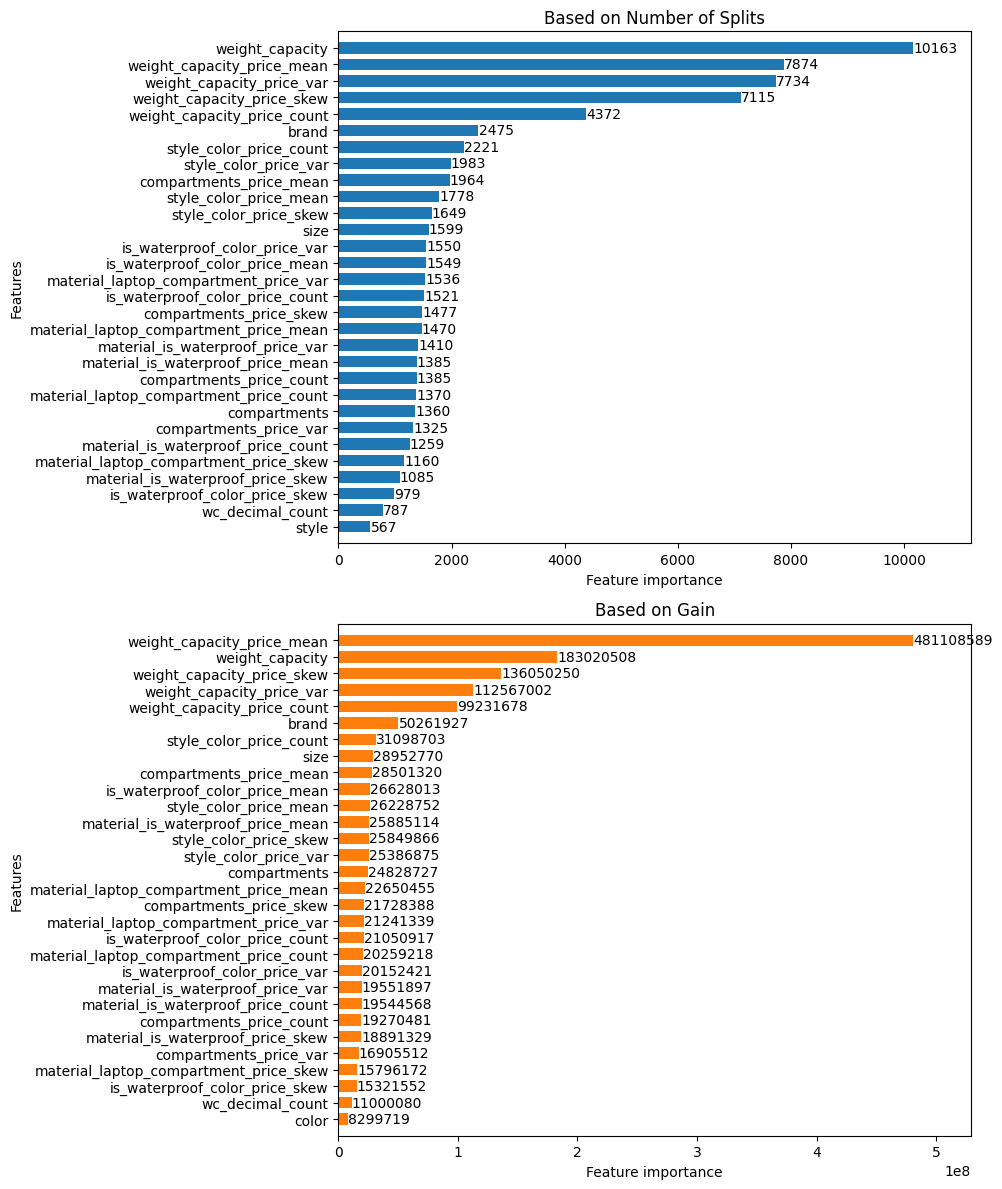

In [173]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

lgb.plot_importance(model, ax=axs[0], importance_type='split', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:blue")
axs[0].set_title("Based on Number of Splits", fontsize=12)

lgb.plot_importance(model, ax=axs[1], importance_type='gain', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:orange")
axs[1].set_title("Based on Gain", fontsize=12)

plt.tight_layout()
plt.show()

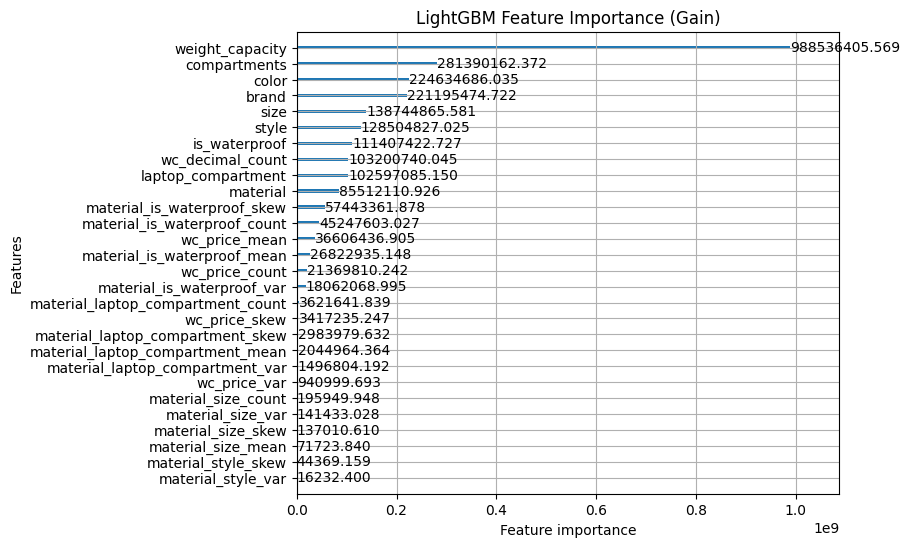

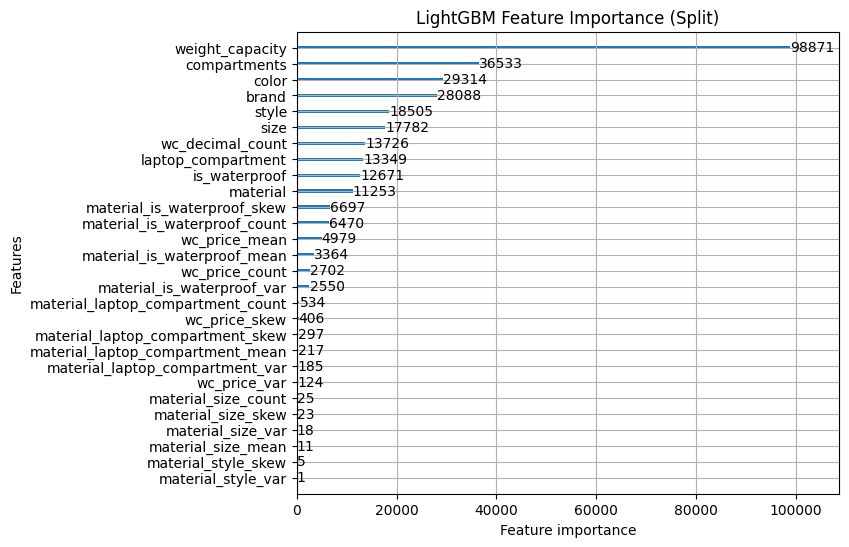

In [113]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

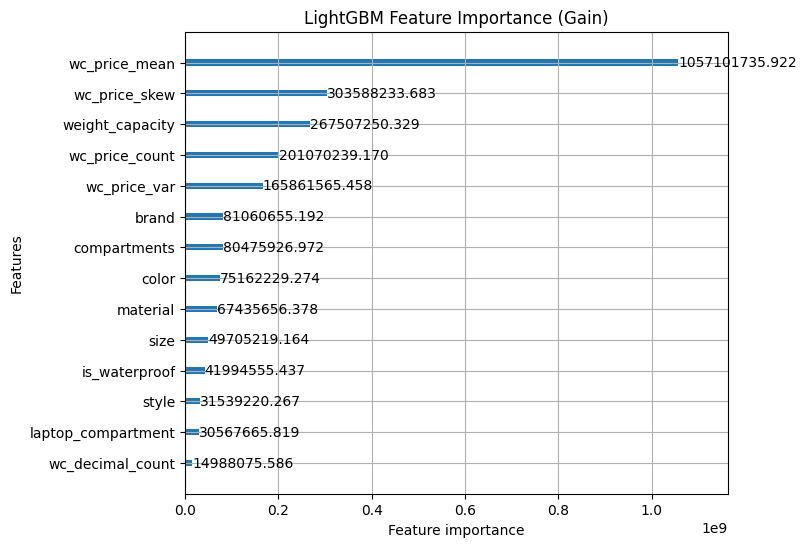

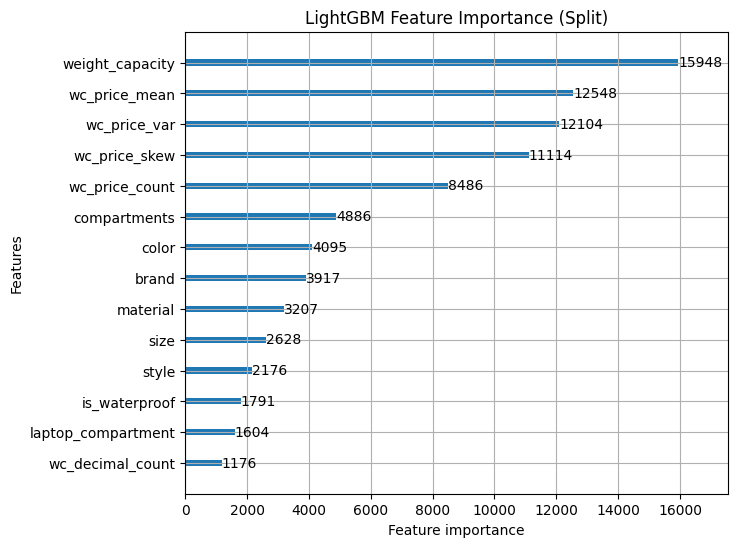

In [107]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [27]:
# ---------------------------------------------------------
# Factorize CATS and create COMBO features
# ---------------------------------------------------------

CATS = ['brand', 'material', 'size', 'compartments', 'laptop_compartment',
       'is_waterproof', 'style', 'color']
COMBO = []

for col in CATS:
    # Combine and factorize
    combined = pd.concat([train_df[col], test_df[col]], axis=0, ignore_index=True)
    combined, _ = pd.factorize(combined, sort=True)
    
    # Assign back to train/test
    train_df[col] = combined[: len(train_df)]
    test_df[col] = combined[len(train_df) :]

    # Create combined "cat + weight capacity" feature
    new_col = f"{col}_wc"
    train_df[new_col] = train_df[col] * 100 + train_df["weight_capacity"]
    test_df[new_col] = test_df[col] * 100 + test_df["weight_capacity"]
    COMBO.append(new_col)

FEATURES = CATS + ["weight_capacity"] + COMBO

In [72]:
FEATURES

['brand',
 'material',
 'size',
 'compartments',
 'laptop_compartment',
 'is_waterproof',
 'style',
 'color',
 'weight_capacity',
 'brand_wc',
 'material_wc',
 'size_wc',
 'compartments_wc',
 'laptop_compartment_wc',
 'is_waterproof_wc',
 'style_wc',
 'color_wc']

In [48]:
from xgboost import XGBRegressor

STATS = ["mean", "count", "nunique", "median", "skew"]
STATS2 = ["mean", "std"]
FOLDS = 7

# ---------------------------------------------------------
# Helper functions
# ---------------------------------------------------------
def add_groupby_stats(
    df_group: pd.DataFrame,
    df_target: pd.DataFrame,
    merge_col: str,
    agg_stats: list,
    prefix: str,
    target_col: str = target
) -> pd.DataFrame:
    """
    Group by `merge_col` in `df_group` to compute `agg_stats` on `target_col`,
    then merge the results into `df_target`.

    Parameters
    ----------
    df_group : DataFrame used for groupby (usually the 'fitting' part).
    df_target : DataFrame where we want to add the aggregated stats.
    merge_col : str, column name to group by.
    agg_stats : list of aggregation stats (e.g., ['mean', 'std']).
    prefix : str, prefix for the new column names.
    target_col : str, column name on which to compute stats.

    Returns
    -------
    df_target_merged : DataFrame with new aggregated columns merged in.
    tmp : DataFrame of the aggregated results (so we can assign them back to X_train by index).
    """
    tmp = df_group.groupby(merge_col)[target_col].agg(agg_stats).copy()
    tmp.columns = [f"{prefix}_{stat}" for stat in agg_stats]

    df_target_merged = df_target.merge(tmp, on=merge_col, how="left")
    return df_target_merged, tmp

# ---------------------------------------------------------
# Prepare arrays for out-of-fold and test predictions
# ---------------------------------------------------------
oof = np.zeros(len(train_df), dtype=float)
pred = np.zeros(len(test_df), dtype=float)

# ---------------------------------------------------------
# Outer K-Fold
# ---------------------------------------------------------
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

for i, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
    print(f"### OUTER Fold {i+1} ###")

    # Split data
    X_train_fold = train_df.loc[train_idx, FEATURES + [target]].reset_index(drop=True)
    y_train_fold = train_df.loc[train_idx, target].values

    X_valid_fold = train_df.loc[valid_idx, FEATURES].reset_index(drop=True)
    y_valid_fold = train_df.loc[valid_idx, target].values

    X_test_fold = train_df[FEATURES].reset_index(drop=True)

    # -----------------------------------------------------
    # Inner K-Fold (for partial target encoding)
    # -----------------------------------------------------
    kf_inner = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    for j, (train_idx2, valid_idx2) in enumerate(kf_inner.split(X_train_fold)):
        print(f"  ## INNER Fold {j+1} (outer fold {i+1}) ##")

        X_train2 = X_train_fold.loc[train_idx2, FEATURES + [target]].copy()
        X_valid2 = X_train_fold.loc[valid_idx2, FEATURES].copy()

        # --- Feature Set 1 (uses Price), grouping by weight capacity ---
        grp_col = "weight_capacity"
        agg_stats = X_train2.groupby(col)[target].agg(STATS)
        for stat in STATS:
            stat_name = f"TE1_wc_{stat}"
            X_train_fold.loc[valid_idx2, stat_name] = X_train_fold.loc[valid_idx2, col].map(agg_stats[stat])

        # X_valid2, tmp_stats = add_groupby_stats(
        #     df_group=X_train2,
        #     df_target=X_valid2,
        #     merge_col=grp_col,
        #     agg_stats=STATS,
        #     prefix="TE1_wc"
        # )
        # # Assign back to X_train_fold for the valid_idx2
        # for col_name in tmp_stats.columns:
        #     X_train_fold.loc[valid_idx2, col_name] = X_valid2[col_name].values

        # --- Feature Set 2 (uses Price), grouping by COMBO features ---
        # for combo_col in COMBO:
        #     X_valid2, tmp_stats = add_groupby_stats(
        #         df_group=X_train2,
        #         df_target=X_valid2,
        #         merge_col=combo_col,
        #         agg_stats=STATS2,
        #         prefix=f"TE2_{combo_col}"
        #     )
        #     for col_name in tmp_stats.columns:
        #         X_train_fold.loc[valid_idx2, col_name] = X_valid2[col_name].values

    # -----------------------------------------------------
    # Merge final target-encoded stats into X_valid_fold / X_test_fold
    # -----------------------------------------------------
    # Feature set 1
    grp_col = "weight_capacity"
    X_valid_fold, tmp_stats = add_groupby_stats(
        df_group=X_train_fold,
        df_target=X_valid_fold,
        merge_col=grp_col,
        agg_stats=STATS,
        prefix="TE1_wc"
    )
    X_test_fold = X_test_fold.merge(tmp_stats, on=grp_col, how="left")

    # Feature set 2
    for combo_col in COMBO:
        X_valid_fold, tmp_stats = add_groupby_stats(
            df_group=X_train_fold,
            df_target=X_valid_fold,
            merge_col=combo_col,
            agg_stats=STATS2,
            prefix=f"TE2_{combo_col}"
        )
        X_test_fold = X_test_fold.merge(tmp_stats, on=combo_col, how="left")

    # -----------------------------------------------------
    # Feature set 3 (no Price) - grouping each CATS on Weight Capacity
    # -----------------------------------------------------
    for cat_col in CATS:
        # We group by cat_col, but aggregate the "weight_capacity" with STATS2
        temp = X_train_fold.groupby(cat_col)["weight_capacity"].agg(STATS2).copy()
        temp.columns = [f"FE3_{cat_col}_wc_{stat}" for stat in STATS2]

        X_train_fold = X_train_fold.merge(temp, on=cat_col, how="left")
        X_valid_fold = X_valid_fold.merge(temp, on=cat_col, how="left")
        X_test_fold = X_test_fold.merge(temp, on=cat_col, how="left")

    # -----------------------------------------------------
    # Convert categories for XGBoost
    # -----------------------------------------------------
    X_train_fold[CATS] = X_train_fold[CATS].astype("category")
    X_valid_fold[CATS] = X_valid_fold[CATS].astype("category")
    X_test_fold[CATS] = X_test_fold[CATS].astype("category")

    # -----------------------------------------------------
    # Drop Price (used for target encoding) from training data
    # -----------------------------------------------------
    X_train_fold.drop(columns=[target], inplace=True)

    # -----------------------------------------------------
    # Build and train model
    # -----------------------------------------------------
    model = XGBRegressor(
        device="cuda",
        max_depth=6,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=1_000,
        learning_rate=0.2,
        enable_categorical=True,
        min_child_weight=10,
        early_stopping_rounds=100,
    )

    model.fit(
        X_train_fold,
        y_train_fold,
        eval_set=[(X_valid_fold, y_valid_fold)],
        verbose=200,
    )

    # -----------------------------------------------------
    # Make OOF and test predictions
    # -----------------------------------------------------
    oof[valid_idx] = model.predict(X_valid_fold)
    pred += model.predict(X_test_fold)

# ---------------------------------------------------------
# Average test predictions across folds
# ---------------------------------------------------------
pred /= FOLDS

### OUTER Fold 1 ###
  ## INNER Fold 1 (outer fold 1) ##
  ## INNER Fold 2 (outer fold 1) ##
  ## INNER Fold 3 (outer fold 1) ##
  ## INNER Fold 4 (outer fold 1) ##
  ## INNER Fold 5 (outer fold 1) ##
  ## INNER Fold 6 (outer fold 1) ##
  ## INNER Fold 7 (outer fold 1) ##


XGBoostError: [10:14:01] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\data\iterative_dmatrix.cc:93: Check failed: ref->Info().num_col_ == n_features (38 vs. 54) : Invalid ref DMatrix, different number of features.

In [37]:
# tmp_stats

In [35]:
X_test_fold.merge(tmp_stats, on=grp_col, how="left")

KeyError: 'weight_capacity'

In [71]:
X_test

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,brand_wc,material_wc,size_wc,compartments_wc,laptop_compartment_wc,is_waterproof_wc,style_wc,color_wc,wc_price_mean,wc_price_skew
0,4,1,2,6,2,1,3,1,11.611723,411.611723,111.611723,211.611723,611.611723,211.611723,111.611723,311.611723,111.611723,80.499991,0.075217
1,4,4,1,9,2,2,2,5,27.078537,427.078537,427.078537,127.078537,927.078537,227.078537,227.078537,227.078537,527.078537,82.308448,0.014391
2,5,1,1,1,2,1,2,3,16.643760,516.643760,116.643760,116.643760,116.643760,216.643760,116.643760,216.643760,316.643760,81.057433,0.053340
3,3,2,1,7,2,1,2,5,12.937220,312.937220,212.937220,112.937220,712.937220,212.937220,112.937220,212.937220,512.937220,82.308448,0.014391
4,1,4,2,0,2,2,2,5,17.749338,117.749338,417.749338,217.749338,17.749338,217.749338,217.749338,217.749338,517.749338,82.308448,0.014391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1,1,1,8,1,1,3,6,12.730812,112.730812,112.730812,112.730812,812.730812,112.730812,112.730812,312.730812,612.730812,82.001825,-0.004501
299996,4,1,3,5,1,2,3,6,26.633182,426.633182,126.633182,326.633182,526.633182,126.633182,226.633182,326.633182,626.633182,82.001825,-0.004501
299997,2,4,3,8,2,2,1,4,11.898250,211.898250,411.898250,311.898250,811.898250,211.898250,211.898250,111.898250,411.898250,81.607966,0.030425
299998,1,2,1,0,1,2,3,4,6.175738,106.175738,206.175738,106.175738,6.175738,106.175738,206.175738,306.175738,406.175738,81.607966,0.030425


In [68]:
X_train

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,brand_wc,material_wc,size_wc,compartments_wc,laptop_compartment_wc,is_waterproof_wc,style_wc,color_wc,price,TE1_wc_mean,TE1_wc_skew
0,4,1,2,6,2,1,3,1,11.611723,411.611723,111.611723,211.611723,611.611723,211.611723,111.611723,311.611723,111.611723,112.15875,80.507714,0.077740
1,4,4,1,9,2,2,2,5,27.078537,427.078537,427.078537,127.078537,927.078537,227.078537,227.078537,227.078537,527.078537,68.88056,82.232221,0.014604
2,5,1,1,1,2,1,2,3,16.643760,516.643760,116.643760,116.643760,116.643760,216.643760,116.643760,216.643760,316.643760,39.17320,81.006135,0.055732
3,3,2,1,7,2,1,2,5,12.937220,312.937220,212.937220,112.937220,712.937220,212.937220,112.937220,212.937220,512.937220,80.60793,82.309527,0.015292
4,1,4,2,0,2,2,2,5,17.749338,117.749338,417.749338,217.749338,17.749338,217.749338,217.749338,217.749338,517.749338,86.02312,82.350772,0.011425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257138,5,2,3,3,2,1,2,5,20.392117,520.392117,220.392117,320.392117,320.392117,220.392117,120.392117,220.392117,520.392117,113.59984,82.345586,0.012188
257139,4,1,3,5,1,2,3,6,26.633182,426.633182,126.633182,326.633182,526.633182,126.633182,226.633182,326.633182,626.633182,19.85819,82.126515,-0.009871
257140,2,4,3,8,2,2,1,4,11.898250,211.898250,411.898250,311.898250,811.898250,211.898250,211.898250,111.898250,411.898250,111.41364,81.564149,0.034254
257141,1,2,1,0,1,2,3,4,6.175738,106.175738,206.175738,106.175738,6.175738,106.175738,206.175738,306.175738,406.175738,115.89080,81.654415,0.028738


In [65]:
X_train[X_train['TE1_wc_mean'].isna()]

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,brand_wc,material_wc,size_wc,compartments_wc,laptop_compartment_wc,is_waterproof_wc,style_wc,color_wc,price,TE1_wc_mean


In [55]:
# col
X_train.loc[valid_idx]

KeyError: '[257142, 257169, 257170, 257173, 257188, 257195, 257197, 257199, 257202, 257204, 257210, 257216, 257223, 257227, 257229, 257236, 257242, 257248, 257253, 257265, 257269, 257272, 257283, 257305, 257316, 257327, 257334, 257337, 257343, 257353, 257376, 257385, 257396, 257397, 257405, 257409, 257418, 257442, 257445, 257452, 257460, 257464, 257469, 257482, 257499, 257516, 257518, 257520, 257528, 257532, 257533, 257534, 257536, 257538, 257540, 257546, 257563, 257569, 257578, 257596, 257599, 257605, 257606, 257607, 257610, 257624, 257647, 257668, 257675, 257699, 257709, 257725, 257726, 257727, 257732, 257739, 257747, 257749, 257752, 257756, 257761, 257763, 257768, 257769, 257772, 257780, 257786, 257832, 257850, 257854, 257861, 257873, 257878, 257885, 257887, 257889, 257897, 257905, 257908, 257923, 257943, 257954, 257967, 257978, 257980, 257996, 257998, 258012, 258016, 258017, 258020, 258031, 258032, 258050, 258053, 258055, 258066, 258073, 258092, 258095, 258096, 258102, 258103, 258107, 258114, 258125, 258133, 258138, 258141, 258146, 258150, 258157, 258162, 258169, 258170, 258175, 258177, 258182, 258197, 258217, 258219, 258231, 258235, 258236, 258237, 258243, 258246, 258266, 258281, 258284, 258297, 258301, 258302, 258317, 258325, 258326, 258339, 258340, 258353, 258356, 258364, 258367, 258368, 258370, 258374, 258379, 258388, 258390, 258391, 258393, 258399, 258401, 258403, 258420, 258422, 258424, 258428, 258437, 258463, 258482, 258491, 258496, 258501, 258504, 258515, 258521, 258527, 258528, 258536, 258539, 258540, 258545, 258546, 258547, 258549, 258566, 258570, 258572, 258580, 258594, 258605, 258611, 258616, 258619, 258621, 258628, 258639, 258642, 258644, 258646, 258652, 258653, 258658, 258663, 258675, 258678, 258687, 258696, 258697, 258699, 258703, 258705, 258707, 258708, 258714, 258716, 258719, 258721, 258726, 258738, 258743, 258769, 258780, 258781, 258787, 258788, 258799, 258802, 258812, 258814, 258818, 258824, 258841, 258843, 258844, 258846, 258848, 258850, 258851, 258865, 258871, 258874, 258884, 258899, 258928, 258948, 258955, 258959, 258963, 258969, 258979, 258988, 258990, 258992, 259015, 259017, 259027, 259028, 259029, 259031, 259045, 259050, 259060, 259062, 259072, 259076, 259083, 259086, 259095, 259102, 259103, 259109, 259110, 259115, 259118, 259122, 259129, 259130, 259131, 259134, 259138, 259140, 259145, 259156, 259159, 259160, 259162, 259179, 259183, 259189, 259190, 259192, 259198, 259210, 259213, 259222, 259225, 259226, 259233, 259240, 259254, 259264, 259265, 259267, 259273, 259281, 259290, 259307, 259311, 259318, 259319, 259341, 259350, 259351, 259391, 259406, 259412, 259415, 259419, 259436, 259439, 259457, 259465, 259467, 259474, 259507, 259509, 259530, 259531, 259537, 259538, 259540, 259545, 259550, 259553, 259559, 259560, 259570, 259572, 259581, 259582, 259616, 259624, 259626, 259634, 259643, 259651, 259658, 259659, 259661, 259663, 259667, 259670, 259672, 259675, 259683, 259693, 259699, 259726, 259727, 259740, 259755, 259765, 259767, 259768, 259777, 259780, 259791, 259798, 259803, 259804, 259808, 259814, 259822, 259834, 259837, 259871, 259872, 259882, 259889, 259892, 259895, 259905, 259907, 259915, 259920, 259921, 259928, 259969, 259975, 259981, 260002, 260006, 260007, 260010, 260014, 260019, 260022, 260031, 260054, 260055, 260060, 260061, 260062, 260069, 260073, 260077, 260080, 260089, 260090, 260091, 260093, 260098, 260104, 260126, 260134, 260135, 260142, 260143, 260152, 260153, 260159, 260178, 260180, 260188, 260190, 260191, 260193, 260201, 260207, 260234, 260240, 260244, 260255, 260256, 260266, 260279, 260296, 260297, 260304, 260310, 260315, 260326, 260336, 260342, 260353, 260377, 260388, 260409, 260411, 260413, 260422, 260435, 260439, 260442, 260443, 260445, 260454, 260456, 260468, 260469, 260471, 260491, 260501, 260503, 260507, 260508, 260509, 260521, 260522, 260533, 260557, 260561, 260562, 260572, 260574, 260598, 260599, 260604, 260610, 260620, 260622, 260632, 260636, 260642, 260653, 260674, 260676, 260685, 260709, 260721, 260726, 260732, 260748, 260755, 260759, 260763, 260768, 260772, 260773, 260778, 260783, 260786, 260790, 260796, 260804, 260811, 260829, 260837, 260840, 260853, 260857, 260876, 260879, 260894, 260898, 260901, 260902, 260921, 260923, 260926, 260935, 260938, 260967, 260970, 260973, 260992, 260995, 261009, 261013, 261024, 261029, 261038, 261048, 261052, 261061, 261063, 261067, 261080, 261089, 261096, 261097, 261104, 261114, 261115, 261138, 261152, 261154, 261155, 261163, 261173, 261174, 261184, 261192, 261205, 261209, 261219, 261248, 261271, 261273, 261276, 261277, 261281, 261285, 261293, 261302, 261307, 261309, 261311, 261323, 261324, 261325, 261335, 261339, 261344, 261361, 261362, 261367, 261392, 261398, 261410, 261424, 261425, 261428, 261436, 261438, 261450, 261461, 261470, 261471, 261479, 261483, 261535, 261537, 261562, 261571, 261580, 261581, 261585, 261586, 261589, 261596, 261604, 261605, 261606, 261611, 261614, 261616, 261623, 261624, 261640, 261647, 261648, 261687, 261695, 261700, 261709, 261711, 261714, 261729, 261732, 261741, 261748, 261751, 261758, 261766, 261767, 261779, 261780, 261790, 261791, 261809, 261815, 261823, 261827, 261830, 261833, 261837, 261841, 261842, 261843, 261883, 261892, 261893, 261898, 261899, 261903, 261913, 261916, 261930, 261931, 261936, 261950, 261951, 261961, 261976, 261980, 261981, 261996, 262005, 262006, 262009, 262013, 262014, 262021, 262022, 262024, 262057, 262061, 262068, 262089, 262096, 262105, 262109, 262111, 262118, 262126, 262132, 262138, 262142, 262144, 262158, 262165, 262221, 262226, 262235, 262240, 262246, 262267, 262280, 262291, 262295, 262296, 262298, 262303, 262310, 262317, 262332, 262333, 262337, 262338, 262344, 262349, 262352, 262361, 262368, 262380, 262391, 262403, 262410, 262423, 262438, 262439, 262447, 262451, 262460, 262464, 262468, 262471, 262480, 262487, 262489, 262491, 262505, 262510, 262513, 262514, 262535, 262542, 262549, 262552, 262560, 262573, 262574, 262575, 262586, 262590, 262591, 262594, 262595, 262608, 262611, 262613, 262620, 262626, 262633, 262634, 262635, 262643, 262646, 262648, 262650, 262658, 262666, 262691, 262718, 262720, 262725, 262727, 262736, 262737, 262738, 262764, 262765, 262770, 262774, 262785, 262799, 262803, 262813, 262837, 262850, 262855, 262872, 262879, 262886, 262894, 262907, 262914, 262921, 262928, 262931, 262934, 262937, 262939, 262957, 262971, 262977, 262991, 263000, 263034, 263040, 263044, 263047, 263048, 263061, 263064, 263095, 263103, 263118, 263138, 263140, 263145, 263147, 263148, 263149, 263156, 263159, 263161, 263168, 263183, 263189, 263201, 263208, 263209, 263220, 263222, 263225, 263228, 263229, 263233, 263234, 263271, 263284, 263286, 263306, 263308, 263309, 263324, 263355, 263357, 263359, 263366, 263372, 263376, 263384, 263388, 263397, 263404, 263405, 263407, 263416, 263421, 263424, 263428, 263432, 263448, 263452, 263461, 263471, 263473, 263478, 263495, 263497, 263499, 263511, 263515, 263519, 263524, 263528, 263531, 263535, 263544, 263558, 263561, 263565, 263572, 263573, 263576, 263584, 263586, 263587, 263588, 263591, 263599, 263605, 263608, 263623, 263624, 263641, 263647, 263667, 263686, 263695, 263697, 263701, 263714, 263716, 263724, 263747, 263752, 263753, 263756, 263760, 263765, 263768, 263781, 263792, 263793, 263795, 263802, 263803, 263805, 263820, 263822, 263828, 263835, 263855, 263858, 263870, 263872, 263875, 263882, 263883, 263889, 263892, 263895, 263896, 263902, 263905, 263912, 263922, 263930, 263937, 263959, 263962, 263973, 263976, 263990, 264002, 264004, 264008, 264011, 264013, 264017, 264030, 264032, 264058, 264061, 264066, 264081, 264089, 264097, 264108, 264111, 264113, 264118, 264119, 264126, 264132, 264151, 264163, 264166, 264169, 264178, 264184, 264187, 264199, 264201, 264231, 264240, 264242, 264246, 264248, 264258, 264260, 264261, 264264, 264269, 264280, 264281, 264299, 264300, 264301, 264306, 264329, 264334, 264348, 264363, 264370, 264373, 264377, 264379, 264387, 264391, 264401, 264413, 264421, 264422, 264424, 264426, 264442, 264446, 264451, 264454, 264457, 264462, 264463, 264471, 264477, 264481, 264485, 264488, 264498, 264501, 264503, 264505, 264506, 264508, 264510, 264524, 264529, 264552, 264568, 264573, 264578, 264593, 264594, 264609, 264615, 264629, 264637, 264639, 264643, 264645, 264654, 264663, 264665, 264680, 264688, 264691, 264702, 264707, 264722, 264729, 264741, 264744, 264752, 264757, 264760, 264771, 264775, 264798, 264830, 264845, 264875, 264882, 264899, 264904, 264917, 264919, 264922, 264929, 264932, 264941, 264942, 264951, 264953, 264960, 264965, 264970, 264979, 264986, 264995, 264999, 265002, 265008, 265010, 265057, 265058, 265073, 265079, 265085, 265098, 265104, 265106, 265112, 265113, 265115, 265118, 265137, 265141, 265142, 265143, 265146, 265150, 265154, 265159, 265169, 265196, 265206, 265220, 265223, 265248, 265262, 265263, 265265, 265267, 265268, 265276, 265277, 265291, 265292, 265300, 265304, 265306, 265328, 265336, 265339, 265342, 265348, 265351, 265353, 265375, 265378, 265379, 265385, 265395, 265396, 265397, 265426, 265434, 265440, 265447, 265449, 265451, 265456, 265457, 265462, 265463, 265465, 265473, 265486, 265488, 265489, 265495, 265497, 265502, 265509, 265511, 265515, 265520, 265521, 265542, 265543, 265544, 265546, 265560, 265562, 265565, 265566, 265569, 265574, 265579, 265602, 265603, 265605, 265609, 265611, 265612, 265621, 265648, 265654, 265665, 265675, 265677, 265682, 265690, 265705, 265710, 265716, 265727, 265738, 265742, 265744, 265767, 265769, 265770, 265797, 265800, 265802, 265813, 265834, 265841, 265845, 265848, 265858, 265868, 265869, 265886, 265889, 265896, 265901, 265903, 265905, 265907, 265915, 265918, 265926, 265933, 265938, 265942, 265943, 265948, 265952, 265959, 265966, 265975, 265982, 265989, 265997, 266005, 266014, 266017, 266030, 266031, 266033, 266045, 266052, 266057, 266060, 266067, 266073, 266075, 266078, 266079, 266107, 266110, 266119, 266124, 266139, 266169, 266170, 266176, 266181, 266182, 266197, 266200, 266207, 266218, 266225, 266236, 266237, 266248, 266262, 266268, 266273, 266274, 266275, 266292, 266296, 266303, 266304, 266306, 266308, 266315, 266322, 266334, 266338, 266349, 266354, 266362, 266363, 266373, 266374, 266382, 266393, 266399, 266411, 266415, 266422, 266435, 266455, 266472, 266473, 266475, 266490, 266494, 266506, 266522, 266526, 266541, 266544, 266545, 266546, 266568, 266582, 266588, 266595, 266599, 266601, 266605, 266608, 266609, 266611, 266623, 266633, 266639, 266640, 266647, 266658, 266659, 266662, 266665, 266666, 266672, 266684, 266687, 266688, 266694, 266697, 266698, 266702, 266710, 266715, 266734, 266736, 266743, 266748, 266763, 266767, 266771, 266797, 266813, 266817, 266818, 266828, 266835, 266855, 266856, 266859, 266873, 266879, 266883, 266884, 266895, 266900, 266910, 266917, 266934, 266942, 266943, 266945, 266966, 266973, 266980, 267000, 267011, 267016, 267023, 267028, 267033, 267034, 267045, 267056, 267060, 267063, 267080, 267086, 267087, 267089, 267091, 267098, 267101, 267146, 267149, 267161, 267162, 267168, 267169, 267178, 267179, 267182, 267200, 267209, 267213, 267227, 267228, 267245, 267276, 267304, 267321, 267322, 267326, 267328, 267335, 267358, 267367, 267375, 267390, 267393, 267399, 267403, 267407, 267409, 267415, 267416, 267419, 267425, 267426, 267432, 267433, 267442, 267449, 267454, 267457, 267463, 267472, 267486, 267493, 267508, 267511, 267536, 267539, 267559, 267566, 267578, 267579, 267597, 267609, 267611, 267615, 267622, 267629, 267632, 267643, 267647, 267648, 267651, 267654, 267656, 267658, 267659, 267663, 267668, 267675, 267679, 267692, 267695, 267718, 267726, 267735, 267744, 267745, 267747, 267749, 267768, 267773, 267783, 267786, 267801, 267813, 267815, 267816, 267818, 267838, 267846, 267856, 267857, 267872, 267873, 267874, 267881, 267882, 267883, 267889, 267907, 267921, 267934, 267935, 267936, 267950, 267954, 267964, 267974, 267975, 267978, 267985, 267988, 268001, 268003, 268034, 268041, 268076, 268079, 268085, 268090, 268094, 268097, 268102, 268104, 268112, 268118, 268123, 268126, 268129, 268134, 268135, 268139, 268142, 268154, 268157, 268164, 268167, 268169, 268174, 268187, 268192, 268196, 268208, 268214, 268221, 268225, 268233, 268234, 268238, 268240, 268247, 268256, 268258, 268269, 268270, 268271, 268283, 268301, 268312, 268314, 268351, 268353, 268354, 268357, 268373, 268377, 268382, 268395, 268400, 268401, 268403, 268410, 268413, 268426, 268428, 268429, 268441, 268446, 268447, 268455, 268457, 268472, 268484, 268497, 268507, 268511, 268515, 268516, 268521, 268529, 268531, 268535, 268537, 268538, 268539, 268544, 268562, 268565, 268575, 268578, 268590, 268594, 268599, 268601, 268606, 268643, 268644, 268645, 268655, 268661, 268666, 268670, 268681, 268701, 268702, 268703, 268705, 268712, 268727, 268732, 268734, 268736, 268741, 268742, 268743, 268756, 268761, 268763, 268769, 268778, 268797, 268816, 268823, 268832, 268833, 268834, 268837, 268842, 268846, 268850, 268859, 268861, 268876, 268880, 268885, 268888, 268901, 268921, 268926, 268927, 268940, 268953, 268956, 268959, 268968, 268971, 268986, 268987, 269029, 269031, 269033, 269049, 269053, 269055, 269065, 269067, 269068, 269075, 269080, 269083, 269093, 269097, 269100, 269101, 269102, 269127, 269133, 269135, 269139, 269149, 269157, 269174, 269183, 269184, 269193, 269201, 269211, 269217, 269221, 269229, 269236, 269250, 269252, 269269, 269271, 269272, 269276, 269290, 269291, 269305, 269306, 269309, 269310, 269319, 269320, 269324, 269336, 269352, 269361, 269366, 269385, 269386, 269391, 269397, 269405, 269409, 269411, 269419, 269422, 269423, 269426, 269430, 269434, 269440, 269446, 269483, 269484, 269488, 269489, 269490, 269501, 269502, 269517, 269528, 269529, 269530, 269532, 269533, 269543, 269545, 269550, 269553, 269574, 269575, 269584, 269585, 269586, 269595, 269597, 269603, 269618, 269626, 269638, 269640, 269641, 269644, 269660, 269662, 269663, 269666, 269671, 269672, 269677, 269686, 269696, 269699, 269707, 269711, 269720, 269723, 269728, 269773, 269781, 269790, 269792, 269804, 269809, 269810, 269815, 269820, 269821, 269827, 269832, 269834, 269836, 269844, 269848, 269850, 269851, 269864, 269866, 269882, 269895, 269920, 269926, 269943, 269947, 269982, 269985, 269986, 269988, 269996, 270017, 270018, 270020, 270028, 270034, 270043, 270045, 270046, 270055, 270073, 270077, 270102, 270104, 270105, 270106, 270129, 270149, 270150, 270158, 270164, 270168, 270197, 270209, 270215, 270219, 270220, 270221, 270240, 270242, 270309, 270315, 270329, 270350, 270356, 270365, 270384, 270396, 270407, 270420, 270424, 270431, 270432, 270438, 270441, 270446, 270450, 270451, 270465, 270481, 270483, 270494, 270498, 270500, 270502, 270515, 270522, 270534, 270546, 270548, 270563, 270565, 270566, 270567, 270570, 270579, 270582, 270589, 270594, 270598, 270623, 270632, 270641, 270645, 270654, 270660, 270662, 270681, 270683, 270684, 270688, 270701, 270703, 270708, 270712, 270719, 270720, 270721, 270731, 270739, 270743, 270766, 270767, 270783, 270787, 270788, 270790, 270793, 270816, 270825, 270832, 270865, 270869, 270879, 270884, 270891, 270898, 270906, 270921, 270927, 270929, 270933, 270934, 270971, 270985, 270988, 270989, 270990, 270991, 270997, 271002, 271005, 271007, 271010, 271021, 271028, 271029, 271030, 271046, 271053, 271059, 271064, 271073, 271075, 271078, 271083, 271087, 271101, 271105, 271106, 271111, 271119, 271126, 271139, 271141, 271143, 271144, 271146, 271149, 271171, 271178, 271181, 271182, 271184, 271193, 271211, 271213, 271215, 271216, 271227, 271231, 271232, 271243, 271249, 271256, 271260, 271272, 271281, 271284, 271286, 271288, 271294, 271299, 271303, 271307, 271318, 271319, 271320, 271332, 271339, 271345, 271346, 271348, 271362, 271371, 271373, 271376, 271387, 271390, 271414, 271417, 271426, 271446, 271454, 271455, 271485, 271505, 271514, 271516, 271517, 271526, 271529, 271537, 271545, 271547, 271549, 271556, 271563, 271564, 271565, 271572, 271574, 271577, 271587, 271610, 271629, 271637, 271641, 271644, 271647, 271651, 271653, 271666, 271669, 271678, 271684, 271685, 271687, 271688, 271705, 271710, 271711, 271721, 271724, 271738, 271740, 271741, 271746, 271750, 271762, 271769, 271775, 271778, 271782, 271789, 271800, 271803, 271810, 271811, 271812, 271813, 271824, 271827, 271832, 271837, 271854, 271856, 271870, 271871, 271886, 271902, 271903, 271910, 271915, 271919, 271921, 271924, 271929, 271931, 271933, 271938, 271945, 271954, 271956, 271975, 271988, 272001, 272003, 272004, 272026, 272045, 272049, 272057, 272066, 272071, 272075, 272085, 272087, 272095, 272106, 272115, 272125, 272129, 272130, 272131, 272135, 272140, 272149, 272179, 272194, 272200, 272212, 272225, 272230, 272239, 272245, 272255, 272257, 272270, 272278, 272281, 272291, 272294, 272299, 272301, 272309, 272312, 272317, 272321, 272334, 272342, 272348, 272364, 272368, 272374, 272375, 272378, 272405, 272434, 272443, 272450, 272453, 272466, 272474, 272483, 272486, 272487, 272489, 272490, 272506, 272519, 272522, 272523, 272525, 272534, 272542, 272546, 272550, 272573, 272591, 272603, 272604, 272621, 272629, 272635, 272651, 272652, 272653, 272664, 272665, 272681, 272685, 272699, 272706, 272715, 272716, 272723, 272741, 272742, 272744, 272745, 272748, 272753, 272756, 272773, 272774, 272776, 272777, 272785, 272787, 272798, 272799, 272803, 272821, 272823, 272826, 272829, 272831, 272834, 272843, 272846, 272850, 272851, 272876, 272877, 272881, 272882, 272890, 272891, 272901, 272914, 272916, 272934, 272956, 272958, 272960, 272961, 272965, 272980, 272982, 272987, 272991, 272994, 272997, 273012, 273013, 273014, 273019, 273024, 273027, 273033, 273046, 273047, 273049, 273051, 273055, 273067, 273069, 273081, 273083, 273097, 273108, 273133, 273135, 273155, 273157, 273158, 273176, 273190, 273204, 273215, 273220, 273228, 273238, 273239, 273247, 273273, 273274, 273278, 273315, 273330, 273335, 273339, 273341, 273345, 273354, 273355, 273356, 273357, 273377, 273380, 273383, 273384, 273401, 273406, 273410, 273414, 273419, 273421, 273424, 273432, 273437, 273439, 273451, 273463, 273469, 273483, 273489, 273502, 273503, 273507, 273512, 273528, 273543, 273547, 273551, 273552, 273555, 273556, 273560, 273562, 273579, 273583, 273588, 273597, 273598, 273622, 273634, 273638, 273642, 273663, 273665, 273681, 273699, 273700, 273703, 273719, 273722, 273726, 273727, 273742, 273745, 273748, 273754, 273755, 273762, 273763, 273767, 273769, 273770, 273778, 273783, 273793, 273794, 273796, 273802, 273809, 273814, 273815, 273819, 273841, 273842, 273846, 273847, 273849, 273851, 273853, 273854, 273863, 273865, 273866, 273869, 273871, 273877, 273882, 273884, 273885, 273889, 273890, 273919, 273923, 273929, 273952, 273965, 273969, 273974, 273979, 273983, 273985, 273998, 274010, 274015, 274016, 274019, 274020, 274023, 274032, 274044, 274045, 274056, 274062, 274065, 274074, 274076, 274084, 274085, 274093, 274094, 274105, 274116, 274128, 274129, 274142, 274149, 274153, 274154, 274156, 274175, 274178, 274183, 274184, 274189, 274192, 274195, 274197, 274226, 274228, 274236, 274240, 274241, 274246, 274260, 274262, 274266, 274276, 274282, 274283, 274288, 274293, 274300, 274306, 274308, 274316, 274325, 274341, 274342, 274350, 274362, 274377, 274397, 274412, 274413, 274419, 274427, 274428, 274429, 274446, 274455, 274461, 274464, 274473, 274475, 274489, 274499, 274520, 274525, 274526, 274534, 274545, 274554, 274558, 274588, 274589, 274591, 274593, 274596, 274602, 274608, 274612, 274615, 274620, 274625, 274626, 274631, 274639, 274645, 274648, 274658, 274667, 274674, 274683, 274685, 274699, 274701, 274711, 274713, 274718, 274735, 274736, 274738, 274751, 274756, 274757, 274766, 274771, 274778, 274792, 274807, 274811, 274812, 274816, 274818, 274824, 274826, 274830, 274833, 274839, 274844, 274845, 274846, 274859, 274860, 274868, 274885, 274887, 274890, 274897, 274898, 274900, 274901, 274919, 274920, 274923, 274932, 274934, 274938, 274940, 274945, 274958, 274959, 274960, 274965, 274975, 274976, 274978, 274988, 275002, 275012, 275017, 275019, 275025, 275033, 275046, 275051, 275062, 275073, 275075, 275098, 275104, 275110, 275112, 275120, 275124, 275139, 275155, 275158, 275179, 275185, 275186, 275218, 275226, 275241, 275242, 275245, 275256, 275260, 275266, 275281, 275287, 275293, 275296, 275300, 275301, 275316, 275317, 275318, 275319, 275329, 275331, 275348, 275354, 275362, 275390, 275393, 275400, 275407, 275413, 275415, 275440, 275447, 275458, 275459, 275472, 275481, 275487, 275506, 275513, 275521, 275527, 275564, 275569, 275570, 275575, 275585, 275586, 275605, 275607, 275608, 275619, 275621, 275626, 275644, 275653, 275658, 275660, 275663, 275666, 275668, 275677, 275680, 275684, 275685, 275690, 275711, 275712, 275733, 275742, 275748, 275753, 275754, 275758, 275761, 275763, 275771, 275780, 275783, 275788, 275793, 275801, 275810, 275815, 275818, 275825, 275833, 275837, 275859, 275863, 275870, 275876, 275880, 275895, 275903, 275933, 275934, 275962, 275986, 275990, 275996, 276006, 276007, 276015, 276018, 276028, 276029, 276036, 276042, 276044, 276048, 276049, 276053, 276058, 276062, 276071, 276084, 276087, 276090, 276094, 276104, 276107, 276119, 276121, 276137, 276138, 276142, 276151, 276152, 276168, 276171, 276181, 276186, 276192, 276193, 276202, 276210, 276216, 276227, 276239, 276248, 276251, 276254, 276257, 276264, 276277, 276286, 276287, 276288, 276289, 276293, 276295, 276298, 276302, 276307, 276312, 276318, 276328, 276329, 276336, 276347, 276353, 276365, 276367, 276368, 276373, 276374, 276385, 276390, 276394, 276397, 276404, 276418, 276426, 276430, 276436, 276445, 276456, 276461, 276462, 276474, 276484, 276488, 276505, 276506, 276523, 276525, 276530, 276546, 276564, 276566, 276578, 276583, 276584, 276587, 276609, 276612, 276613, 276615, 276617, 276621, 276622, 276639, 276640, 276641, 276684, 276699, 276704, 276716, 276717, 276719, 276725, 276732, 276740, 276755, 276766, 276793, 276794, 276804, 276810, 276823, 276825, 276846, 276856, 276862, 276869, 276872, 276883, 276887, 276893, 276904, 276915, 276937, 276938, 276939, 276941, 276942, 276949, 276950, 276951, 276953, 276961, 276965, 276977, 276980, 276982, 276991, 277021, 277026, 277028, 277031, 277033, 277055, 277060, 277062, 277063, 277072, 277073, 277074, 277075, 277078, 277107, 277111, 277113, 277114, 277115, 277125, 277130, 277139, 277141, 277148, 277150, 277151, 277168, 277178, 277184, 277186, 277188, 277206, 277207, 277209, 277222, 277224, 277232, 277234, 277238, 277243, 277248, 277262, 277281, 277282, 277286, 277295, 277298, 277301, 277302, 277307, 277308, 277335, 277352, 277353, 277357, 277360, 277365, 277373, 277376, 277379, 277385, 277387, 277393, 277395, 277397, 277400, 277407, 277412, 277419, 277422, 277430, 277439, 277443, 277446, 277454, 277461, 277462, 277467, 277471, 277477, 277480, 277485, 277499, 277500, 277508, 277512, 277526, 277535, 277538, 277541, 277542, 277549, 277553, 277555, 277557, 277558, 277566, 277583, 277587, 277598, 277601, 277621, 277623, 277636, 277642, 277650, 277655, 277665, 277670, 277671, 277677, 277684, 277695, 277701, 277723, 277732, 277734, 277741, 277750, 277753, 277754, 277765, 277771, 277774, 277781, 277791, 277795, 277803, 277807, 277815, 277826, 277831, 277854, 277858, 277859, 277888, 277889, 277894, 277900, 277910, 277911, 277912, 277924, 277925, 277935, 277937, 277950, 277951, 277959, 277977, 277987, 277994, 277998, 278000, 278005, 278018, 278019, 278020, 278023, 278024, 278044, 278053, 278054, 278067, 278069, 278075, 278106, 278122, 278123, 278129, 278158, 278170, 278174, 278180, 278191, 278198, 278212, 278218, 278246, 278247, 278248, 278259, 278278, 278280, 278287, 278294, 278296, 278310, 278325, 278327, 278330, 278347, 278356, 278359, 278368, 278376, 278378, 278384, 278386, 278393, 278397, 278426, 278435, 278437, 278438, 278443, 278467, 278474, 278483, 278484, 278485, 278499, 278502, 278506, 278508, 278509, 278512, 278514, 278515, 278528, 278535, 278539, 278591, 278595, 278608, 278612, 278622, 278630, 278631, 278635, 278648, 278653, 278654, 278656, 278664, 278665, 278667, 278669, 278671, 278679, 278688, 278690, 278691, 278700, 278703, 278707, 278724, 278734, 278737, 278762, 278768, 278771, 278774, 278799, 278801, 278806, 278807, 278809, 278815, 278825, 278835, 278844, 278853, 278855, 278879, 278883, 278891, 278896, 278897, 278898, 278902, 278906, 278911, 278912, 278918, 278926, 278940, 278942, 278943, 278953, 278954, 278962, 278965, 278967, 278969, 278970, 278971, 278976, 278977, 278983, 278985, 278987, 278988, 278995, 279008, 279015, 279020, 279022, 279034, 279038, 279045, 279051, 279053, 279055, 279056, 279069, 279070, 279079, 279080, 279083, 279086, 279089, 279111, 279112, 279114, 279124, 279126, 279129, 279130, 279140, 279146, 279153, 279161, 279165, 279172, 279174, 279177, 279187, 279198, 279203, 279232, 279236, 279239, 279290, 279292, 279296, 279304, 279324, 279331, 279338, 279344, 279348, 279351, 279354, 279357, 279376, 279384, 279387, 279389, 279390, 279395, 279402, 279405, 279411, 279418, 279420, 279424, 279439, 279440, 279448, 279451, 279454, 279456, 279466, 279475, 279480, 279481, 279484, 279485, 279488, 279498, 279508, 279523, 279529, 279536, 279540, 279542, 279544, 279557, 279562, 279568, 279575, 279576, 279579, 279584, 279592, 279603, 279606, 279611, 279620, 279658, 279678, 279692, 279706, 279721, 279723, 279725, 279733, 279745, 279752, 279760, 279763, 279767, 279771, 279777, 279782, 279788, 279803, 279807, 279818, 279827, 279839, 279841, 279852, 279856, 279862, 279878, 279893, 279899, 279901, 279912, 279917, 279918, 279921, 279931, 279941, 279947, 279949, 279952, 279957, 279963, 279968, 279975, 279984, 280004, 280011, 280014, 280016, 280021, 280029, 280039, 280040, 280041, 280049, 280056, 280057, 280068, 280070, 280072, 280074, 280088, 280089, 280090, 280091, 280094, 280103, 280125, 280133, 280144, 280148, 280152, 280168, 280170, 280173, 280181, 280182, 280186, 280191, 280200, 280214, 280218, 280226, 280227, 280229, 280231, 280248, 280280, 280283, 280295, 280306, 280314, 280317, 280332, 280337, 280350, 280351, 280361, 280377, 280379, 280389, 280396, 280404, 280406, 280410, 280415, 280425, 280434, 280449, 280452, 280464, 280487, 280494, 280498, 280514, 280526, 280531, 280543, 280549, 280551, 280559, 280565, 280569, 280575, 280578, 280600, 280624, 280625, 280629, 280631, 280633, 280639, 280651, 280657, 280665, 280671, 280672, 280680, 280681, 280703, 280705, 280712, 280720, 280727, 280739, 280748, 280750, 280751, 280755, 280760, 280775, 280777, 280778, 280781, 280792, 280803, 280815, 280821, 280835, 280840, 280851, 280864, 280867, 280869, 280874, 280892, 280896, 280906, 280907, 280914, 280916, 280919, 280921, 280927, 280929, 280942, 280952, 280956, 280964, 280975, 280977, 280978, 280990, 281001, 281018, 281019, 281022, 281026, 281040, 281047, 281050, 281058, 281065, 281077, 281078, 281079, 281096, 281102, 281129, 281135, 281139, 281149, 281150, 281156, 281162, 281166, 281170, 281176, 281178, 281182, 281186, 281200, 281204, 281205, 281206, 281219, 281230, 281244, 281257, 281268, 281273, 281274, 281279, 281280, 281285, 281289, 281290, 281291, 281313, 281316, 281317, 281325, 281327, 281329, 281333, 281338, 281345, 281368, 281372, 281380, 281382, 281385, 281390, 281391, 281395, 281402, 281414, 281419, 281422, 281426, 281427, 281455, 281465, 281479, 281483, 281489, 281501, 281502, 281505, 281512, 281525, 281538, 281541, 281543, 281544, 281548, 281552, 281568, 281578, 281586, 281599, 281613, 281626, 281629, 281630, 281639, 281650, 281655, 281661, 281664, 281677, 281681, 281689, 281697, 281699, 281713, 281718, 281732, 281738, 281763, 281768, 281780, 281783, 281793, 281801, 281817, 281818, 281820, 281822, 281827, 281837, 281838, 281846, 281848, 281871, 281878, 281882, 281884, 281895, 281897, 281910, 281919, 281926, 281940, 281959, 281960, 281961, 281964, 281966, 281970, 281977, 281982, 281984, 281999, 282002, 282004, 282007, 282019, 282034, 282036, 282057, 282062, 282074, 282077, 282084, 282091, 282096, 282097, 282099, 282102, 282103, 282104, 282159, 282173, 282175, 282197, 282198, 282202, 282204, 282206, 282208, 282216, 282233, 282251, 282253, 282263, 282266, 282299, 282304, 282310, 282311, 282318, 282319, 282340, 282347, 282348, 282353, 282357, 282359, 282366, 282375, 282379, 282382, 282385, 282388, 282400, 282413, 282417, 282424, 282431, 282437, 282439, 282441, 282447, 282452, 282470, 282473, 282478, 282496, 282507, 282510, 282512, 282522, 282529, 282532, 282545, 282547, 282553, 282560, 282562, 282563, 282585, 282586, 282598, 282609, 282611, 282613, 282626, 282627, 282631, 282657, 282659, 282660, 282673, 282679, 282685, 282686, 282690, 282702, 282707, 282710, 282715, 282720, 282746, 282779, 282788, 282789, 282791, 282792, 282806, 282815, 282845, 282851, 282858, 282862, 282864, 282869, 282870, 282871, 282876, 282893, 282900, 282934, 282947, 282949, 282961, 282962, 282968, 282975, 282979, 282983, 282987, 282991, 283008, 283013, 283014, 283017, 283018, 283019, 283034, 283046, 283055, 283058, 283061, 283066, 283067, 283068, 283079, 283081, 283082, 283091, 283095, 283099, 283108, 283113, 283132, 283136, 283149, 283150, 283156, 283157, 283167, 283180, 283189, 283194, 283202, 283208, 283212, 283217, 283221, 283223, 283229, 283230, 283234, 283238, 283239, 283245, 283248, 283264, 283272, 283277, 283284, 283285, 283289, 283292, 283295, 283297, 283312, 283314, 283318, 283379, 283388, 283389, 283394, 283398, 283405, 283414, 283416, 283417, 283452, 283459, 283461, 283470, 283479, 283480, 283483, 283486, 283487, 283489, 283491, 283502, 283520, 283522, 283526, 283532, 283534, 283535, 283545, 283550, 283556, 283561, 283565, 283587, 283591, 283595, 283603, 283606, 283614, 283624, 283629, 283630, 283635, 283638, 283643, 283649, 283662, 283665, 283676, 283690, 283704, 283713, 283716, 283717, 283747, 283751, 283754, 283773, 283777, 283781, 283782, 283797, 283801, 283822, 283824, 283829, 283831, 283835, 283841, 283844, 283845, 283848, 283850, 283861, 283870, 283890, 283894, 283899, 283905, 283912, 283916, 283923, 283929, 283930, 283938, 283944, 283948, 283949, 283954, 283958, 283977, 283980, 283982, 284000, 284004, 284015, 284047, 284049, 284056, 284057, 284065, 284092, 284096, 284115, 284120, 284127, 284135, 284139, 284142, 284148, 284149, 284153, 284162, 284164, 284174, 284179, 284182, 284183, 284184, 284185, 284204, 284222, 284226, 284231, 284232, 284234, 284235, 284258, 284262, 284265, 284289, 284291, 284299, 284303, 284316, 284345, 284364, 284365, 284366, 284367, 284375, 284383, 284401, 284402, 284404, 284414, 284419, 284422, 284438, 284442, 284451, 284456, 284461, 284468, 284471, 284488, 284493, 284495, 284501, 284505, 284517, 284524, 284527, 284535, 284544, 284557, 284560, 284562, 284574, 284576, 284577, 284584, 284586, 284595, 284605, 284619, 284620, 284621, 284628, 284638, 284645, 284670, 284678, 284692, 284694, 284699, 284711, 284723, 284733, 284738, 284739, 284741, 284755, 284777, 284786, 284792, 284795, 284804, 284810, 284817, 284818, 284820, 284827, 284831, 284832, 284841, 284847, 284862, 284865, 284871, 284875, 284876, 284877, 284895, 284901, 284925, 284940, 284955, 284970, 284989, 284993, 284995, 284997, 285004, 285039, 285048, 285050, 285054, 285074, 285082, 285083, 285089, 285092, 285096, 285098, 285113, 285119, 285124, 285144, 285146, 285150, 285152, 285153, 285159, 285161, 285162, 285171, 285172, 285189, 285208, 285215, 285234, 285238, 285249, 285251, 285263, 285266, 285268, 285271, 285279, 285280, 285282, 285287, 285294, 285300, 285305, 285310, 285322, 285330, 285335, 285342, 285351, 285366, 285377, 285378, 285382, 285384, 285390, 285391, 285393, 285398, 285403, 285416, 285420, 285425, 285434, 285437, 285438, 285440, 285443, 285456, 285460, 285463, 285465, 285479, 285484, 285490, 285498, 285508, 285513, 285519, 285522, 285534, 285540, 285567, 285568, 285576, 285594, 285651, 285675, 285676, 285685, 285698, 285712, 285730, 285732, 285742, 285743, 285746, 285749, 285754, 285768, 285769, 285774, 285785, 285799, 285806, 285827, 285830, 285831, 285838, 285841, 285853, 285856, 285857, 285872, 285884, 285893, 285900, 285922, 285928, 285930, 285932, 285934, 285941, 285943, 285949, 285952, 285955, 285962, 285963, 285984, 285986, 285996, 286023, 286030, 286032, 286033, 286038, 286043, 286053, 286055, 286059, 286063, 286068, 286086, 286090, 286096, 286101, 286107, 286125, 286126, 286128, 286130, 286137, 286146, 286159, 286165, 286167, 286176, 286178, 286181, 286182, 286185, 286192, 286193, 286194, 286195, 286199, 286206, 286215, 286227, 286232, 286238, 286241, 286244, 286257, 286270, 286284, 286292, 286297, 286307, 286311, 286320, 286330, 286338, 286339, 286345, 286358, 286364, 286376, 286377, 286385, 286392, 286400, 286405, 286414, 286417, 286426, 286430, 286437, 286439, 286443, 286445, 286456, 286466, 286470, 286483, 286486, 286491, 286492, 286515, 286516, 286519, 286522, 286526, 286567, 286568, 286572, 286584, 286587, 286591, 286592, 286593, 286612, 286613, 286619, 286623, 286628, 286635, 286636, 286642, 286645, 286651, 286652, 286653, 286665, 286672, 286688, 286709, 286710, 286714, 286727, 286729, 286736, 286741, 286756, 286757, 286758, 286767, 286770, 286775, 286778, 286779, 286793, 286794, 286795, 286799, 286808, 286809, 286810, 286823, 286833, 286842, 286847, 286850, 286860, 286861, 286871, 286872, 286897, 286903, 286923, 286927, 286940, 286945, 286949, 286953, 286959, 286969, 286985, 287003, 287004, 287009, 287012, 287017, 287020, 287022, 287026, 287035, 287040, 287049, 287050, 287052, 287055, 287068, 287076, 287080, 287087, 287093, 287098, 287099, 287103, 287106, 287111, 287118, 287121, 287134, 287135, 287171, 287195, 287202, 287204, 287221, 287224, 287227, 287258, 287262, 287263, 287269, 287276, 287279, 287283, 287289, 287290, 287294, 287295, 287297, 287308, 287311, 287325, 287333, 287337, 287341, 287344, 287352, 287377, 287389, 287400, 287401, 287407, 287410, 287421, 287424, 287430, 287447, 287448, 287453, 287467, 287468, 287481, 287489, 287498, 287526, 287530, 287543, 287573, 287574, 287577, 287587, 287592, 287606, 287613, 287614, 287621, 287626, 287633, 287636, 287653, 287655, 287656, 287659, 287662, 287664, 287671, 287677, 287688, 287693, 287700, 287703, 287734, 287737, 287744, 287748, 287769, 287809, 287815, 287824, 287825, 287829, 287833, 287836, 287838, 287841, 287857, 287869, 287874, 287890, 287891, 287899, 287909, 287917, 287918, 287925, 287929, 287933, 287941, 287943, 287947, 287951, 287952, 287954, 287958, 287963, 287966, 287988, 287990, 287997, 288010, 288013, 288020, 288022, 288035, 288037, 288041, 288042, 288059, 288071, 288074, 288078, 288082, 288088, 288093, 288104, 288109, 288113, 288114, 288131, 288133, 288169, 288185, 288186, 288203, 288208, 288211, 288215, 288219, 288223, 288234, 288237, 288241, 288242, 288245, 288253, 288254, 288264, 288266, 288286, 288294, 288299, 288309, 288312, 288331, 288335, 288338, 288343, 288354, 288374, 288384, 288407, 288419, 288423, 288439, 288454, 288461, 288462, 288464, 288475, 288489, 288498, 288505, 288507, 288512, 288515, 288519, 288520, 288532, 288545, 288558, 288563, 288567, 288571, 288572, 288576, 288582, 288583, 288585, 288617, 288619, 288632, 288637, 288648, 288657, 288677, 288694, 288695, 288700, 288701, 288729, 288734, 288739, 288754, 288766, 288779, 288782, 288792, 288795, 288804, 288810, 288817, 288857, 288862, 288890, 288898, 288899, 288908, 288910, 288917, 288918, 288922, 288928, 288936, 288943, 288945, 288954, 288962, 288966, 288982, 288992, 289015, 289023, 289057, 289059, 289062, 289066, 289077, 289081, 289083, 289097, 289115, 289117, 289120, 289147, 289148, 289152, 289169, 289172, 289173, 289176, 289185, 289190, 289216, 289223, 289231, 289242, 289251, 289267, 289274, 289279, 289286, 289288, 289289, 289299, 289301, 289303, 289308, 289317, 289335, 289351, 289354, 289357, 289367, 289376, 289379, 289388, 289390, 289393, 289395, 289404, 289429, 289436, 289453, 289459, 289464, 289467, 289483, 289500, 289505, 289509, 289516, 289521, 289535, 289545, 289552, 289568, 289598, 289608, 289611, 289613, 289616, 289620, 289632, 289640, 289647, 289650, 289651, 289658, 289660, 289663, 289665, 289671, 289675, 289680, 289683, 289688, 289691, 289693, 289698, 289706, 289712, 289716, 289720, 289729, 289742, 289761, 289766, 289767, 289772, 289774, 289790, 289793, 289817, 289818, 289821, 289823, 289829, 289843, 289852, 289855, 289859, 289868, 289873, 289886, 289901, 289907, 289914, 289926, 289929, 289932, 289934, 289937, 289940, 289968, 289983, 289990, 289995, 289998, 290003, 290008, 290012, 290022, 290024, 290028, 290033, 290047, 290052, 290056, 290059, 290065, 290069, 290075, 290076, 290080, 290082, 290092, 290093, 290108, 290114, 290116, 290124, 290132, 290144, 290152, 290166, 290173, 290183, 290184, 290190, 290193, 290203, 290204, 290206, 290210, 290211, 290212, 290224, 290241, 290247, 290248, 290256, 290266, 290281, 290285, 290287, 290295, 290308, 290310, 290312, 290331, 290332, 290335, 290341, 290346, 290349, 290358, 290369, 290377, 290381, 290387, 290392, 290398, 290401, 290403, 290422, 290432, 290450, 290452, 290456, 290464, 290471, 290475, 290479, 290484, 290489, 290493, 290506, 290509, 290510, 290516, 290518, 290522, 290531, 290538, 290540, 290543, 290545, 290548, 290551, 290552, 290555, 290565, 290568, 290577, 290580, 290581, 290582, 290601, 290603, 290618, 290634, 290650, 290651, 290652, 290653, 290660, 290673, 290682, 290695, 290698, 290699, 290707, 290708, 290713, 290717, 290726, 290729, 290735, 290739, 290748, 290768, 290772, 290776, 290777, 290784, 290793, 290796, 290799, 290802, 290804, 290806, 290813, 290816, 290833, 290837, 290839, 290847, 290863, 290866, 290868, 290875, 290878, 290882, 290914, 290917, 290922, 290926, 290935, 290937, 290940, 290941, 290956, 290960, 290961, 291012, 291014, 291022, 291026, 291038, 291048, 291054, 291060, 291062, 291064, 291070, 291074, 291091, 291092, 291095, 291099, 291119, 291133, 291137, 291153, 291155, 291158, 291162, 291163, 291164, 291168, 291181, 291186, 291194, 291195, 291200, 291201, 291232, 291236, 291239, 291241, 291245, 291249, 291254, 291256, 291259, 291268, 291274, 291281, 291291, 291295, 291298, 291301, 291302, 291306, 291315, 291325, 291331, 291352, 291365, 291369, 291371, 291379, 291389, 291399, 291406, 291407, 291414, 291423, 291438, 291440, 291443, 291446, 291452, 291454, 291456, 291462, 291465, 291467, 291469, 291473, 291474, 291478, 291486, 291504, 291506, 291507, 291513, 291524, 291536, 291539, 291548, 291559, 291572, 291578, 291579, 291599, 291604, 291607, 291610, 291613, 291621, 291640, 291644, 291657, 291668, 291674, 291682, 291684, 291692, 291695, 291700, 291704, 291710, 291711, 291714, 291715, 291717, 291719, 291722, 291731, 291739, 291741, 291742, 291751, 291776, 291792, 291794, 291803, 291804, 291815, 291820, 291833, 291845, 291858, 291867, 291873, 291886, 291893, 291903, 291907, 291912, 291925, 291968, 291973, 292025, 292030, 292031, 292036, 292054, 292059, 292064, 292069, 292072, 292082, 292088, 292109, 292114, 292116, 292118, 292120, 292122, 292123, 292134, 292149, 292155, 292156, 292157, 292161, 292165, 292167, 292168, 292179, 292184, 292187, 292189, 292202, 292203, 292205, 292208, 292222, 292225, 292226, 292227, 292232, 292233, 292245, 292246, 292262, 292276, 292288, 292293, 292294, 292300, 292331, 292337, 292345, 292348, 292351, 292386, 292394, 292396, 292403, 292412, 292437, 292457, 292465, 292480, 292482, 292487, 292503, 292504, 292537, 292549, 292562, 292566, 292567, 292587, 292595, 292598, 292618, 292622, 292631, 292643, 292646, 292647, 292671, 292681, 292689, 292691, 292709, 292711, 292715, 292725, 292727, 292746, 292748, 292751, 292766, 292776, 292781, 292792, 292794, 292798, 292804, 292824, 292830, 292855, 292857, 292859, 292860, 292863, 292866, 292869, 292881, 292887, 292895, 292896, 292897, 292904, 292908, 292914, 292916, 292918, 292933, 292936, 292943, 292957, 292959, 292968, 292969, 292974, 292977, 292988, 292989, 292995, 293003, 293013, 293020, 293038, 293041, 293051, 293058, 293062, 293081, 293101, 293106, 293114, 293117, 293124, 293145, 293161, 293165, 293177, 293179, 293181, 293185, 293190, 293193, 293194, 293201, 293202, 293206, 293208, 293215, 293224, 293230, 293231, 293242, 293244, 293247, 293248, 293249, 293254, 293264, 293284, 293287, 293290, 293296, 293298, 293307, 293316, 293317, 293330, 293333, 293334, 293337, 293341, 293344, 293345, 293355, 293358, 293360, 293361, 293362, 293376, 293388, 293397, 293408, 293409, 293420, 293430, 293431, 293434, 293441, 293464, 293468, 293480, 293490, 293499, 293503, 293505, 293514, 293520, 293525, 293527, 293530, 293531, 293535, 293538, 293543, 293545, 293565, 293567, 293572, 293578, 293583, 293609, 293613, 293614, 293616, 293623, 293633, 293639, 293672, 293676, 293677, 293678, 293680, 293690, 293691, 293700, 293708, 293713, 293715, 293723, 293735, 293741, 293756, 293764, 293775, 293786, 293787, 293812, 293822, 293824, 293825, 293826, 293843, 293854, 293861, 293863, 293868, 293881, 293884, 293891, 293892, 293895, 293926, 293928, 293938, 293944, 293945, 293956, 293960, 293961, 293963, 293980, 293982, 293983, 294001, 294016, 294023, 294038, 294039, 294041, 294045, 294048, 294058, 294065, 294071, 294075, 294077, 294081, 294082, 294101, 294106, 294109, 294115, 294119, 294135, 294136, 294140, 294161, 294163, 294167, 294182, 294183, 294191, 294193, 294196, 294207, 294218, 294224, 294228, 294236, 294243, 294246, 294265, 294273, 294276, 294282, 294284, 294328, 294331, 294347, 294359, 294379, 294384, 294390, 294391, 294396, 294397, 294399, 294402, 294413, 294433, 294439, 294445, 294449, 294453, 294454, 294460, 294475, 294480, 294487, 294495, 294504, 294507, 294512, 294526, 294527, 294530, 294537, 294538, 294555, 294569, 294583, 294593, 294594, 294603, 294608, 294618, 294620, 294629, 294636, 294637, 294639, 294640, 294641, 294650, 294656, 294661, 294664, 294666, 294670, 294675, 294680, 294696, 294719, 294723, 294734, 294736, 294739, 294745, 294753, 294754, 294758, 294762, 294785, 294789, 294791, 294797, 294815, 294816, 294817, 294823, 294825, 294829, 294830, 294850, 294855, 294857, 294860, 294871, 294872, 294879, 294881, 294888, 294899, 294908, 294909, 294912, 294930, 294936, 294944, 294947, 294949, 294956, 294962, 294969, 294971, 294976, 294978, 294982, 295014, 295018, 295028, 295047, 295052, 295058, 295060, 295072, 295077, 295083, 295085, 295089, 295091, 295094, 295098, 295107, 295112, 295115, 295116, 295123, 295128, 295130, 295131, 295132, 295149, 295154, 295155, 295170, 295181, 295182, 295189, 295192, 295196, 295204, 295206, 295207, 295223, 295234, 295239, 295242, 295255, 295258, 295262, 295264, 295269, 295299, 295303, 295310, 295321, 295325, 295333, 295352, 295353, 295354, 295356, 295363, 295367, 295368, 295384, 295391, 295395, 295397, 295400, 295401, 295407, 295415, 295419, 295424, 295434, 295441, 295461, 295475, 295487, 295504, 295508, 295511, 295517, 295519, 295532, 295545, 295554, 295557, 295559, 295564, 295570, 295573, 295580, 295589, 295597, 295611, 295620, 295634, 295635, 295637, 295641, 295651, 295652, 295662, 295671, 295680, 295685, 295687, 295693, 295694, 295700, 295701, 295706, 295710, 295722, 295727, 295729, 295737, 295740, 295756, 295765, 295774, 295776, 295791, 295798, 295814, 295817, 295819, 295822, 295836, 295839, 295858, 295868, 295894, 295909, 295911, 295915, 295919, 295922, 295926, 295932, 295936, 295938, 295948, 295965, 295973, 295977, 295987, 295991, 295998, 296005, 296010, 296019, 296025, 296029, 296035, 296039, 296048, 296051, 296055, 296066, 296073, 296074, 296079, 296084, 296092, 296093, 296096, 296101, 296108, 296112, 296116, 296117, 296123, 296131, 296132, 296144, 296174, 296190, 296203, 296204, 296205, 296224, 296235, 296241, 296249, 296251, 296253, 296257, 296264, 296266, 296268, 296270, 296274, 296277, 296286, 296287, 296289, 296294, 296300, 296311, 296315, 296316, 296319, 296322, 296333, 296336, 296337, 296351, 296353, 296359, 296360, 296364, 296365, 296366, 296368, 296370, 296372, 296373, 296374, 296403, 296411, 296423, 296432, 296436, 296442, 296443, 296444, 296457, 296462, 296464, 296472, 296473, 296475, 296480, 296482, 296499, 296507, 296528, 296561, 296569, 296571, 296572, 296574, 296590, 296600, 296605, 296607, 296618, 296619, 296621, 296626, 296629, 296638, 296641, 296646, 296647, 296651, 296653, 296673, 296674, 296691, 296695, 296697, 296698, 296701, 296703, 296704, 296705, 296712, 296721, 296730, 296733, 296739, 296740, 296746, 296752, 296759, 296767, 296770, 296776, 296779, 296780, 296787, 296792, 296793, 296800, 296805, 296806, 296810, 296833, 296860, 296866, 296870, 296871, 296877, 296890, 296891, 296907, 296908, 296910, 296921, 296925, 296927, 296936, 296940, 296945, 296947, 296949, 296954, 296960, 296967, 296971, 296977, 296979, 296994, 296997, 297005, 297006, 297009, 297017, 297018, 297020, 297031, 297043, 297058, 297070, 297074, 297079, 297084, 297090, 297091, 297100, 297102, 297113, 297119, 297123, 297133, 297141, 297151, 297155, 297172, 297176, 297180, 297181, 297193, 297205, 297214, 297215, 297229, 297230, 297234, 297243, 297247, 297253, 297263, 297271, 297283, 297286, 297292, 297302, 297314, 297315, 297324, 297328, 297334, 297335, 297339, 297349, 297351, 297361, 297375, 297381, 297386, 297387, 297389, 297416, 297420, 297430, 297433, 297438, 297448, 297450, 297455, 297459, 297474, 297479, 297487, 297494, 297496, 297497, 297504, 297509, 297511, 297512, 297514, 297521, 297529, 297535, 297547, 297552, 297557, 297568, 297573, 297578, 297580, 297581, 297584, 297604, 297611, 297613, 297617, 297642, 297650, 297651, 297657, 297673, 297675, 297694, 297737, 297739, 297740, 297741, 297752, 297757, 297766, 297767, 297772, 297777, 297779, 297793, 297803, 297813, 297814, 297822, 297832, 297845, 297872, 297873, 297875, 297893, 297896, 297899, 297910, 297916, 297917, 297932, 297934, 297950, 297952, 297954, 297963, 297964, 297972, 297981, 297983, 297991, 297996, 298002, 298005, 298017, 298039, 298041, 298046, 298069, 298070, 298076, 298079, 298089, 298116, 298118, 298121, 298124, 298132, 298133, 298134, 298136, 298140, 298147, 298156, 298161, 298179, 298192, 298195, 298203, 298208, 298212, 298216, 298218, 298227, 298244, 298249, 298257, 298269, 298270, 298288, 298300, 298326, 298329, 298340, 298346, 298349, 298359, 298363, 298365, 298370, 298374, 298383, 298386, 298389, 298396, 298398, 298412, 298423, 298424, 298429, 298430, 298441, 298442, 298462, 298479, 298482, 298487, 298499, 298509, 298513, 298540, 298544, 298545, 298549, 298562, 298563, 298582, 298583, 298587, 298591, 298612, 298619, 298621, 298626, 298635, 298640, 298646, 298647, 298648, 298656, 298661, 298664, 298668, 298682, 298684, 298689, 298732, 298733, 298746, 298752, 298766, 298775, 298776, 298783, 298790, 298800, 298801, 298817, 298835, 298848, 298868, 298871, 298874, 298875, 298879, 298883, 298896, 298899, 298910, 298911, 298917, 298923, 298926, 298937, 298941, 298944, 298948, 298957, 298958, 298971, 298978, 298982, 298986, 298990, 298997, 299017, 299022, 299028, 299033, 299034, 299046, 299047, 299051, 299061, 299067, 299073, 299081, 299084, 299089, 299090, 299093, 299108, 299112, 299124, 299138, 299144, 299166, 299169, 299175, 299191, 299196, 299202, 299208, 299210, 299228, 299246, 299247, 299251, 299276, 299284, 299309, 299311, 299312, 299319, 299321, 299325, 299327, 299332, 299337, 299338, 299341, 299347, 299348, 299356, 299367, 299371, 299372, 299376, 299392, 299424, 299437, 299444, 299448, 299453, 299459, 299465, 299466, 299469, 299474, 299475, 299491, 299497, 299501, 299506, 299510, 299513, 299514, 299527, 299534, 299539, 299545, 299551, 299557, 299571, 299573, 299588, 299602, 299610, 299613, 299624, 299632, 299635, 299644, 299670, 299672, 299692, 299706, 299708, 299716, 299718, 299721, 299722, 299724, 299730, 299750, 299761, 299770, 299783, 299784, 299789, 299803, 299811, 299815, 299836, 299880, 299899, 299901, 299904, 299905, 299912, 299921, 299943, 299946, 299955, 299962, 299973, 299983] not in index'

In [52]:
X_train.loc[valid_idx, col].map(agg_stats[stat])

KeyError: '[257142, 257169, 257170, 257173, 257188, 257195, 257197, 257199, 257202, 257204, 257210, 257216, 257223, 257227, 257229, 257236, 257242, 257248, 257253, 257265, 257269, 257272, 257283, 257305, 257316, 257327, 257334, 257337, 257343, 257353, 257376, 257385, 257396, 257397, 257405, 257409, 257418, 257442, 257445, 257452, 257460, 257464, 257469, 257482, 257499, 257516, 257518, 257520, 257528, 257532, 257533, 257534, 257536, 257538, 257540, 257546, 257563, 257569, 257578, 257596, 257599, 257605, 257606, 257607, 257610, 257624, 257647, 257668, 257675, 257699, 257709, 257725, 257726, 257727, 257732, 257739, 257747, 257749, 257752, 257756, 257761, 257763, 257768, 257769, 257772, 257780, 257786, 257832, 257850, 257854, 257861, 257873, 257878, 257885, 257887, 257889, 257897, 257905, 257908, 257923, 257943, 257954, 257967, 257978, 257980, 257996, 257998, 258012, 258016, 258017, 258020, 258031, 258032, 258050, 258053, 258055, 258066, 258073, 258092, 258095, 258096, 258102, 258103, 258107, 258114, 258125, 258133, 258138, 258141, 258146, 258150, 258157, 258162, 258169, 258170, 258175, 258177, 258182, 258197, 258217, 258219, 258231, 258235, 258236, 258237, 258243, 258246, 258266, 258281, 258284, 258297, 258301, 258302, 258317, 258325, 258326, 258339, 258340, 258353, 258356, 258364, 258367, 258368, 258370, 258374, 258379, 258388, 258390, 258391, 258393, 258399, 258401, 258403, 258420, 258422, 258424, 258428, 258437, 258463, 258482, 258491, 258496, 258501, 258504, 258515, 258521, 258527, 258528, 258536, 258539, 258540, 258545, 258546, 258547, 258549, 258566, 258570, 258572, 258580, 258594, 258605, 258611, 258616, 258619, 258621, 258628, 258639, 258642, 258644, 258646, 258652, 258653, 258658, 258663, 258675, 258678, 258687, 258696, 258697, 258699, 258703, 258705, 258707, 258708, 258714, 258716, 258719, 258721, 258726, 258738, 258743, 258769, 258780, 258781, 258787, 258788, 258799, 258802, 258812, 258814, 258818, 258824, 258841, 258843, 258844, 258846, 258848, 258850, 258851, 258865, 258871, 258874, 258884, 258899, 258928, 258948, 258955, 258959, 258963, 258969, 258979, 258988, 258990, 258992, 259015, 259017, 259027, 259028, 259029, 259031, 259045, 259050, 259060, 259062, 259072, 259076, 259083, 259086, 259095, 259102, 259103, 259109, 259110, 259115, 259118, 259122, 259129, 259130, 259131, 259134, 259138, 259140, 259145, 259156, 259159, 259160, 259162, 259179, 259183, 259189, 259190, 259192, 259198, 259210, 259213, 259222, 259225, 259226, 259233, 259240, 259254, 259264, 259265, 259267, 259273, 259281, 259290, 259307, 259311, 259318, 259319, 259341, 259350, 259351, 259391, 259406, 259412, 259415, 259419, 259436, 259439, 259457, 259465, 259467, 259474, 259507, 259509, 259530, 259531, 259537, 259538, 259540, 259545, 259550, 259553, 259559, 259560, 259570, 259572, 259581, 259582, 259616, 259624, 259626, 259634, 259643, 259651, 259658, 259659, 259661, 259663, 259667, 259670, 259672, 259675, 259683, 259693, 259699, 259726, 259727, 259740, 259755, 259765, 259767, 259768, 259777, 259780, 259791, 259798, 259803, 259804, 259808, 259814, 259822, 259834, 259837, 259871, 259872, 259882, 259889, 259892, 259895, 259905, 259907, 259915, 259920, 259921, 259928, 259969, 259975, 259981, 260002, 260006, 260007, 260010, 260014, 260019, 260022, 260031, 260054, 260055, 260060, 260061, 260062, 260069, 260073, 260077, 260080, 260089, 260090, 260091, 260093, 260098, 260104, 260126, 260134, 260135, 260142, 260143, 260152, 260153, 260159, 260178, 260180, 260188, 260190, 260191, 260193, 260201, 260207, 260234, 260240, 260244, 260255, 260256, 260266, 260279, 260296, 260297, 260304, 260310, 260315, 260326, 260336, 260342, 260353, 260377, 260388, 260409, 260411, 260413, 260422, 260435, 260439, 260442, 260443, 260445, 260454, 260456, 260468, 260469, 260471, 260491, 260501, 260503, 260507, 260508, 260509, 260521, 260522, 260533, 260557, 260561, 260562, 260572, 260574, 260598, 260599, 260604, 260610, 260620, 260622, 260632, 260636, 260642, 260653, 260674, 260676, 260685, 260709, 260721, 260726, 260732, 260748, 260755, 260759, 260763, 260768, 260772, 260773, 260778, 260783, 260786, 260790, 260796, 260804, 260811, 260829, 260837, 260840, 260853, 260857, 260876, 260879, 260894, 260898, 260901, 260902, 260921, 260923, 260926, 260935, 260938, 260967, 260970, 260973, 260992, 260995, 261009, 261013, 261024, 261029, 261038, 261048, 261052, 261061, 261063, 261067, 261080, 261089, 261096, 261097, 261104, 261114, 261115, 261138, 261152, 261154, 261155, 261163, 261173, 261174, 261184, 261192, 261205, 261209, 261219, 261248, 261271, 261273, 261276, 261277, 261281, 261285, 261293, 261302, 261307, 261309, 261311, 261323, 261324, 261325, 261335, 261339, 261344, 261361, 261362, 261367, 261392, 261398, 261410, 261424, 261425, 261428, 261436, 261438, 261450, 261461, 261470, 261471, 261479, 261483, 261535, 261537, 261562, 261571, 261580, 261581, 261585, 261586, 261589, 261596, 261604, 261605, 261606, 261611, 261614, 261616, 261623, 261624, 261640, 261647, 261648, 261687, 261695, 261700, 261709, 261711, 261714, 261729, 261732, 261741, 261748, 261751, 261758, 261766, 261767, 261779, 261780, 261790, 261791, 261809, 261815, 261823, 261827, 261830, 261833, 261837, 261841, 261842, 261843, 261883, 261892, 261893, 261898, 261899, 261903, 261913, 261916, 261930, 261931, 261936, 261950, 261951, 261961, 261976, 261980, 261981, 261996, 262005, 262006, 262009, 262013, 262014, 262021, 262022, 262024, 262057, 262061, 262068, 262089, 262096, 262105, 262109, 262111, 262118, 262126, 262132, 262138, 262142, 262144, 262158, 262165, 262221, 262226, 262235, 262240, 262246, 262267, 262280, 262291, 262295, 262296, 262298, 262303, 262310, 262317, 262332, 262333, 262337, 262338, 262344, 262349, 262352, 262361, 262368, 262380, 262391, 262403, 262410, 262423, 262438, 262439, 262447, 262451, 262460, 262464, 262468, 262471, 262480, 262487, 262489, 262491, 262505, 262510, 262513, 262514, 262535, 262542, 262549, 262552, 262560, 262573, 262574, 262575, 262586, 262590, 262591, 262594, 262595, 262608, 262611, 262613, 262620, 262626, 262633, 262634, 262635, 262643, 262646, 262648, 262650, 262658, 262666, 262691, 262718, 262720, 262725, 262727, 262736, 262737, 262738, 262764, 262765, 262770, 262774, 262785, 262799, 262803, 262813, 262837, 262850, 262855, 262872, 262879, 262886, 262894, 262907, 262914, 262921, 262928, 262931, 262934, 262937, 262939, 262957, 262971, 262977, 262991, 263000, 263034, 263040, 263044, 263047, 263048, 263061, 263064, 263095, 263103, 263118, 263138, 263140, 263145, 263147, 263148, 263149, 263156, 263159, 263161, 263168, 263183, 263189, 263201, 263208, 263209, 263220, 263222, 263225, 263228, 263229, 263233, 263234, 263271, 263284, 263286, 263306, 263308, 263309, 263324, 263355, 263357, 263359, 263366, 263372, 263376, 263384, 263388, 263397, 263404, 263405, 263407, 263416, 263421, 263424, 263428, 263432, 263448, 263452, 263461, 263471, 263473, 263478, 263495, 263497, 263499, 263511, 263515, 263519, 263524, 263528, 263531, 263535, 263544, 263558, 263561, 263565, 263572, 263573, 263576, 263584, 263586, 263587, 263588, 263591, 263599, 263605, 263608, 263623, 263624, 263641, 263647, 263667, 263686, 263695, 263697, 263701, 263714, 263716, 263724, 263747, 263752, 263753, 263756, 263760, 263765, 263768, 263781, 263792, 263793, 263795, 263802, 263803, 263805, 263820, 263822, 263828, 263835, 263855, 263858, 263870, 263872, 263875, 263882, 263883, 263889, 263892, 263895, 263896, 263902, 263905, 263912, 263922, 263930, 263937, 263959, 263962, 263973, 263976, 263990, 264002, 264004, 264008, 264011, 264013, 264017, 264030, 264032, 264058, 264061, 264066, 264081, 264089, 264097, 264108, 264111, 264113, 264118, 264119, 264126, 264132, 264151, 264163, 264166, 264169, 264178, 264184, 264187, 264199, 264201, 264231, 264240, 264242, 264246, 264248, 264258, 264260, 264261, 264264, 264269, 264280, 264281, 264299, 264300, 264301, 264306, 264329, 264334, 264348, 264363, 264370, 264373, 264377, 264379, 264387, 264391, 264401, 264413, 264421, 264422, 264424, 264426, 264442, 264446, 264451, 264454, 264457, 264462, 264463, 264471, 264477, 264481, 264485, 264488, 264498, 264501, 264503, 264505, 264506, 264508, 264510, 264524, 264529, 264552, 264568, 264573, 264578, 264593, 264594, 264609, 264615, 264629, 264637, 264639, 264643, 264645, 264654, 264663, 264665, 264680, 264688, 264691, 264702, 264707, 264722, 264729, 264741, 264744, 264752, 264757, 264760, 264771, 264775, 264798, 264830, 264845, 264875, 264882, 264899, 264904, 264917, 264919, 264922, 264929, 264932, 264941, 264942, 264951, 264953, 264960, 264965, 264970, 264979, 264986, 264995, 264999, 265002, 265008, 265010, 265057, 265058, 265073, 265079, 265085, 265098, 265104, 265106, 265112, 265113, 265115, 265118, 265137, 265141, 265142, 265143, 265146, 265150, 265154, 265159, 265169, 265196, 265206, 265220, 265223, 265248, 265262, 265263, 265265, 265267, 265268, 265276, 265277, 265291, 265292, 265300, 265304, 265306, 265328, 265336, 265339, 265342, 265348, 265351, 265353, 265375, 265378, 265379, 265385, 265395, 265396, 265397, 265426, 265434, 265440, 265447, 265449, 265451, 265456, 265457, 265462, 265463, 265465, 265473, 265486, 265488, 265489, 265495, 265497, 265502, 265509, 265511, 265515, 265520, 265521, 265542, 265543, 265544, 265546, 265560, 265562, 265565, 265566, 265569, 265574, 265579, 265602, 265603, 265605, 265609, 265611, 265612, 265621, 265648, 265654, 265665, 265675, 265677, 265682, 265690, 265705, 265710, 265716, 265727, 265738, 265742, 265744, 265767, 265769, 265770, 265797, 265800, 265802, 265813, 265834, 265841, 265845, 265848, 265858, 265868, 265869, 265886, 265889, 265896, 265901, 265903, 265905, 265907, 265915, 265918, 265926, 265933, 265938, 265942, 265943, 265948, 265952, 265959, 265966, 265975, 265982, 265989, 265997, 266005, 266014, 266017, 266030, 266031, 266033, 266045, 266052, 266057, 266060, 266067, 266073, 266075, 266078, 266079, 266107, 266110, 266119, 266124, 266139, 266169, 266170, 266176, 266181, 266182, 266197, 266200, 266207, 266218, 266225, 266236, 266237, 266248, 266262, 266268, 266273, 266274, 266275, 266292, 266296, 266303, 266304, 266306, 266308, 266315, 266322, 266334, 266338, 266349, 266354, 266362, 266363, 266373, 266374, 266382, 266393, 266399, 266411, 266415, 266422, 266435, 266455, 266472, 266473, 266475, 266490, 266494, 266506, 266522, 266526, 266541, 266544, 266545, 266546, 266568, 266582, 266588, 266595, 266599, 266601, 266605, 266608, 266609, 266611, 266623, 266633, 266639, 266640, 266647, 266658, 266659, 266662, 266665, 266666, 266672, 266684, 266687, 266688, 266694, 266697, 266698, 266702, 266710, 266715, 266734, 266736, 266743, 266748, 266763, 266767, 266771, 266797, 266813, 266817, 266818, 266828, 266835, 266855, 266856, 266859, 266873, 266879, 266883, 266884, 266895, 266900, 266910, 266917, 266934, 266942, 266943, 266945, 266966, 266973, 266980, 267000, 267011, 267016, 267023, 267028, 267033, 267034, 267045, 267056, 267060, 267063, 267080, 267086, 267087, 267089, 267091, 267098, 267101, 267146, 267149, 267161, 267162, 267168, 267169, 267178, 267179, 267182, 267200, 267209, 267213, 267227, 267228, 267245, 267276, 267304, 267321, 267322, 267326, 267328, 267335, 267358, 267367, 267375, 267390, 267393, 267399, 267403, 267407, 267409, 267415, 267416, 267419, 267425, 267426, 267432, 267433, 267442, 267449, 267454, 267457, 267463, 267472, 267486, 267493, 267508, 267511, 267536, 267539, 267559, 267566, 267578, 267579, 267597, 267609, 267611, 267615, 267622, 267629, 267632, 267643, 267647, 267648, 267651, 267654, 267656, 267658, 267659, 267663, 267668, 267675, 267679, 267692, 267695, 267718, 267726, 267735, 267744, 267745, 267747, 267749, 267768, 267773, 267783, 267786, 267801, 267813, 267815, 267816, 267818, 267838, 267846, 267856, 267857, 267872, 267873, 267874, 267881, 267882, 267883, 267889, 267907, 267921, 267934, 267935, 267936, 267950, 267954, 267964, 267974, 267975, 267978, 267985, 267988, 268001, 268003, 268034, 268041, 268076, 268079, 268085, 268090, 268094, 268097, 268102, 268104, 268112, 268118, 268123, 268126, 268129, 268134, 268135, 268139, 268142, 268154, 268157, 268164, 268167, 268169, 268174, 268187, 268192, 268196, 268208, 268214, 268221, 268225, 268233, 268234, 268238, 268240, 268247, 268256, 268258, 268269, 268270, 268271, 268283, 268301, 268312, 268314, 268351, 268353, 268354, 268357, 268373, 268377, 268382, 268395, 268400, 268401, 268403, 268410, 268413, 268426, 268428, 268429, 268441, 268446, 268447, 268455, 268457, 268472, 268484, 268497, 268507, 268511, 268515, 268516, 268521, 268529, 268531, 268535, 268537, 268538, 268539, 268544, 268562, 268565, 268575, 268578, 268590, 268594, 268599, 268601, 268606, 268643, 268644, 268645, 268655, 268661, 268666, 268670, 268681, 268701, 268702, 268703, 268705, 268712, 268727, 268732, 268734, 268736, 268741, 268742, 268743, 268756, 268761, 268763, 268769, 268778, 268797, 268816, 268823, 268832, 268833, 268834, 268837, 268842, 268846, 268850, 268859, 268861, 268876, 268880, 268885, 268888, 268901, 268921, 268926, 268927, 268940, 268953, 268956, 268959, 268968, 268971, 268986, 268987, 269029, 269031, 269033, 269049, 269053, 269055, 269065, 269067, 269068, 269075, 269080, 269083, 269093, 269097, 269100, 269101, 269102, 269127, 269133, 269135, 269139, 269149, 269157, 269174, 269183, 269184, 269193, 269201, 269211, 269217, 269221, 269229, 269236, 269250, 269252, 269269, 269271, 269272, 269276, 269290, 269291, 269305, 269306, 269309, 269310, 269319, 269320, 269324, 269336, 269352, 269361, 269366, 269385, 269386, 269391, 269397, 269405, 269409, 269411, 269419, 269422, 269423, 269426, 269430, 269434, 269440, 269446, 269483, 269484, 269488, 269489, 269490, 269501, 269502, 269517, 269528, 269529, 269530, 269532, 269533, 269543, 269545, 269550, 269553, 269574, 269575, 269584, 269585, 269586, 269595, 269597, 269603, 269618, 269626, 269638, 269640, 269641, 269644, 269660, 269662, 269663, 269666, 269671, 269672, 269677, 269686, 269696, 269699, 269707, 269711, 269720, 269723, 269728, 269773, 269781, 269790, 269792, 269804, 269809, 269810, 269815, 269820, 269821, 269827, 269832, 269834, 269836, 269844, 269848, 269850, 269851, 269864, 269866, 269882, 269895, 269920, 269926, 269943, 269947, 269982, 269985, 269986, 269988, 269996, 270017, 270018, 270020, 270028, 270034, 270043, 270045, 270046, 270055, 270073, 270077, 270102, 270104, 270105, 270106, 270129, 270149, 270150, 270158, 270164, 270168, 270197, 270209, 270215, 270219, 270220, 270221, 270240, 270242, 270309, 270315, 270329, 270350, 270356, 270365, 270384, 270396, 270407, 270420, 270424, 270431, 270432, 270438, 270441, 270446, 270450, 270451, 270465, 270481, 270483, 270494, 270498, 270500, 270502, 270515, 270522, 270534, 270546, 270548, 270563, 270565, 270566, 270567, 270570, 270579, 270582, 270589, 270594, 270598, 270623, 270632, 270641, 270645, 270654, 270660, 270662, 270681, 270683, 270684, 270688, 270701, 270703, 270708, 270712, 270719, 270720, 270721, 270731, 270739, 270743, 270766, 270767, 270783, 270787, 270788, 270790, 270793, 270816, 270825, 270832, 270865, 270869, 270879, 270884, 270891, 270898, 270906, 270921, 270927, 270929, 270933, 270934, 270971, 270985, 270988, 270989, 270990, 270991, 270997, 271002, 271005, 271007, 271010, 271021, 271028, 271029, 271030, 271046, 271053, 271059, 271064, 271073, 271075, 271078, 271083, 271087, 271101, 271105, 271106, 271111, 271119, 271126, 271139, 271141, 271143, 271144, 271146, 271149, 271171, 271178, 271181, 271182, 271184, 271193, 271211, 271213, 271215, 271216, 271227, 271231, 271232, 271243, 271249, 271256, 271260, 271272, 271281, 271284, 271286, 271288, 271294, 271299, 271303, 271307, 271318, 271319, 271320, 271332, 271339, 271345, 271346, 271348, 271362, 271371, 271373, 271376, 271387, 271390, 271414, 271417, 271426, 271446, 271454, 271455, 271485, 271505, 271514, 271516, 271517, 271526, 271529, 271537, 271545, 271547, 271549, 271556, 271563, 271564, 271565, 271572, 271574, 271577, 271587, 271610, 271629, 271637, 271641, 271644, 271647, 271651, 271653, 271666, 271669, 271678, 271684, 271685, 271687, 271688, 271705, 271710, 271711, 271721, 271724, 271738, 271740, 271741, 271746, 271750, 271762, 271769, 271775, 271778, 271782, 271789, 271800, 271803, 271810, 271811, 271812, 271813, 271824, 271827, 271832, 271837, 271854, 271856, 271870, 271871, 271886, 271902, 271903, 271910, 271915, 271919, 271921, 271924, 271929, 271931, 271933, 271938, 271945, 271954, 271956, 271975, 271988, 272001, 272003, 272004, 272026, 272045, 272049, 272057, 272066, 272071, 272075, 272085, 272087, 272095, 272106, 272115, 272125, 272129, 272130, 272131, 272135, 272140, 272149, 272179, 272194, 272200, 272212, 272225, 272230, 272239, 272245, 272255, 272257, 272270, 272278, 272281, 272291, 272294, 272299, 272301, 272309, 272312, 272317, 272321, 272334, 272342, 272348, 272364, 272368, 272374, 272375, 272378, 272405, 272434, 272443, 272450, 272453, 272466, 272474, 272483, 272486, 272487, 272489, 272490, 272506, 272519, 272522, 272523, 272525, 272534, 272542, 272546, 272550, 272573, 272591, 272603, 272604, 272621, 272629, 272635, 272651, 272652, 272653, 272664, 272665, 272681, 272685, 272699, 272706, 272715, 272716, 272723, 272741, 272742, 272744, 272745, 272748, 272753, 272756, 272773, 272774, 272776, 272777, 272785, 272787, 272798, 272799, 272803, 272821, 272823, 272826, 272829, 272831, 272834, 272843, 272846, 272850, 272851, 272876, 272877, 272881, 272882, 272890, 272891, 272901, 272914, 272916, 272934, 272956, 272958, 272960, 272961, 272965, 272980, 272982, 272987, 272991, 272994, 272997, 273012, 273013, 273014, 273019, 273024, 273027, 273033, 273046, 273047, 273049, 273051, 273055, 273067, 273069, 273081, 273083, 273097, 273108, 273133, 273135, 273155, 273157, 273158, 273176, 273190, 273204, 273215, 273220, 273228, 273238, 273239, 273247, 273273, 273274, 273278, 273315, 273330, 273335, 273339, 273341, 273345, 273354, 273355, 273356, 273357, 273377, 273380, 273383, 273384, 273401, 273406, 273410, 273414, 273419, 273421, 273424, 273432, 273437, 273439, 273451, 273463, 273469, 273483, 273489, 273502, 273503, 273507, 273512, 273528, 273543, 273547, 273551, 273552, 273555, 273556, 273560, 273562, 273579, 273583, 273588, 273597, 273598, 273622, 273634, 273638, 273642, 273663, 273665, 273681, 273699, 273700, 273703, 273719, 273722, 273726, 273727, 273742, 273745, 273748, 273754, 273755, 273762, 273763, 273767, 273769, 273770, 273778, 273783, 273793, 273794, 273796, 273802, 273809, 273814, 273815, 273819, 273841, 273842, 273846, 273847, 273849, 273851, 273853, 273854, 273863, 273865, 273866, 273869, 273871, 273877, 273882, 273884, 273885, 273889, 273890, 273919, 273923, 273929, 273952, 273965, 273969, 273974, 273979, 273983, 273985, 273998, 274010, 274015, 274016, 274019, 274020, 274023, 274032, 274044, 274045, 274056, 274062, 274065, 274074, 274076, 274084, 274085, 274093, 274094, 274105, 274116, 274128, 274129, 274142, 274149, 274153, 274154, 274156, 274175, 274178, 274183, 274184, 274189, 274192, 274195, 274197, 274226, 274228, 274236, 274240, 274241, 274246, 274260, 274262, 274266, 274276, 274282, 274283, 274288, 274293, 274300, 274306, 274308, 274316, 274325, 274341, 274342, 274350, 274362, 274377, 274397, 274412, 274413, 274419, 274427, 274428, 274429, 274446, 274455, 274461, 274464, 274473, 274475, 274489, 274499, 274520, 274525, 274526, 274534, 274545, 274554, 274558, 274588, 274589, 274591, 274593, 274596, 274602, 274608, 274612, 274615, 274620, 274625, 274626, 274631, 274639, 274645, 274648, 274658, 274667, 274674, 274683, 274685, 274699, 274701, 274711, 274713, 274718, 274735, 274736, 274738, 274751, 274756, 274757, 274766, 274771, 274778, 274792, 274807, 274811, 274812, 274816, 274818, 274824, 274826, 274830, 274833, 274839, 274844, 274845, 274846, 274859, 274860, 274868, 274885, 274887, 274890, 274897, 274898, 274900, 274901, 274919, 274920, 274923, 274932, 274934, 274938, 274940, 274945, 274958, 274959, 274960, 274965, 274975, 274976, 274978, 274988, 275002, 275012, 275017, 275019, 275025, 275033, 275046, 275051, 275062, 275073, 275075, 275098, 275104, 275110, 275112, 275120, 275124, 275139, 275155, 275158, 275179, 275185, 275186, 275218, 275226, 275241, 275242, 275245, 275256, 275260, 275266, 275281, 275287, 275293, 275296, 275300, 275301, 275316, 275317, 275318, 275319, 275329, 275331, 275348, 275354, 275362, 275390, 275393, 275400, 275407, 275413, 275415, 275440, 275447, 275458, 275459, 275472, 275481, 275487, 275506, 275513, 275521, 275527, 275564, 275569, 275570, 275575, 275585, 275586, 275605, 275607, 275608, 275619, 275621, 275626, 275644, 275653, 275658, 275660, 275663, 275666, 275668, 275677, 275680, 275684, 275685, 275690, 275711, 275712, 275733, 275742, 275748, 275753, 275754, 275758, 275761, 275763, 275771, 275780, 275783, 275788, 275793, 275801, 275810, 275815, 275818, 275825, 275833, 275837, 275859, 275863, 275870, 275876, 275880, 275895, 275903, 275933, 275934, 275962, 275986, 275990, 275996, 276006, 276007, 276015, 276018, 276028, 276029, 276036, 276042, 276044, 276048, 276049, 276053, 276058, 276062, 276071, 276084, 276087, 276090, 276094, 276104, 276107, 276119, 276121, 276137, 276138, 276142, 276151, 276152, 276168, 276171, 276181, 276186, 276192, 276193, 276202, 276210, 276216, 276227, 276239, 276248, 276251, 276254, 276257, 276264, 276277, 276286, 276287, 276288, 276289, 276293, 276295, 276298, 276302, 276307, 276312, 276318, 276328, 276329, 276336, 276347, 276353, 276365, 276367, 276368, 276373, 276374, 276385, 276390, 276394, 276397, 276404, 276418, 276426, 276430, 276436, 276445, 276456, 276461, 276462, 276474, 276484, 276488, 276505, 276506, 276523, 276525, 276530, 276546, 276564, 276566, 276578, 276583, 276584, 276587, 276609, 276612, 276613, 276615, 276617, 276621, 276622, 276639, 276640, 276641, 276684, 276699, 276704, 276716, 276717, 276719, 276725, 276732, 276740, 276755, 276766, 276793, 276794, 276804, 276810, 276823, 276825, 276846, 276856, 276862, 276869, 276872, 276883, 276887, 276893, 276904, 276915, 276937, 276938, 276939, 276941, 276942, 276949, 276950, 276951, 276953, 276961, 276965, 276977, 276980, 276982, 276991, 277021, 277026, 277028, 277031, 277033, 277055, 277060, 277062, 277063, 277072, 277073, 277074, 277075, 277078, 277107, 277111, 277113, 277114, 277115, 277125, 277130, 277139, 277141, 277148, 277150, 277151, 277168, 277178, 277184, 277186, 277188, 277206, 277207, 277209, 277222, 277224, 277232, 277234, 277238, 277243, 277248, 277262, 277281, 277282, 277286, 277295, 277298, 277301, 277302, 277307, 277308, 277335, 277352, 277353, 277357, 277360, 277365, 277373, 277376, 277379, 277385, 277387, 277393, 277395, 277397, 277400, 277407, 277412, 277419, 277422, 277430, 277439, 277443, 277446, 277454, 277461, 277462, 277467, 277471, 277477, 277480, 277485, 277499, 277500, 277508, 277512, 277526, 277535, 277538, 277541, 277542, 277549, 277553, 277555, 277557, 277558, 277566, 277583, 277587, 277598, 277601, 277621, 277623, 277636, 277642, 277650, 277655, 277665, 277670, 277671, 277677, 277684, 277695, 277701, 277723, 277732, 277734, 277741, 277750, 277753, 277754, 277765, 277771, 277774, 277781, 277791, 277795, 277803, 277807, 277815, 277826, 277831, 277854, 277858, 277859, 277888, 277889, 277894, 277900, 277910, 277911, 277912, 277924, 277925, 277935, 277937, 277950, 277951, 277959, 277977, 277987, 277994, 277998, 278000, 278005, 278018, 278019, 278020, 278023, 278024, 278044, 278053, 278054, 278067, 278069, 278075, 278106, 278122, 278123, 278129, 278158, 278170, 278174, 278180, 278191, 278198, 278212, 278218, 278246, 278247, 278248, 278259, 278278, 278280, 278287, 278294, 278296, 278310, 278325, 278327, 278330, 278347, 278356, 278359, 278368, 278376, 278378, 278384, 278386, 278393, 278397, 278426, 278435, 278437, 278438, 278443, 278467, 278474, 278483, 278484, 278485, 278499, 278502, 278506, 278508, 278509, 278512, 278514, 278515, 278528, 278535, 278539, 278591, 278595, 278608, 278612, 278622, 278630, 278631, 278635, 278648, 278653, 278654, 278656, 278664, 278665, 278667, 278669, 278671, 278679, 278688, 278690, 278691, 278700, 278703, 278707, 278724, 278734, 278737, 278762, 278768, 278771, 278774, 278799, 278801, 278806, 278807, 278809, 278815, 278825, 278835, 278844, 278853, 278855, 278879, 278883, 278891, 278896, 278897, 278898, 278902, 278906, 278911, 278912, 278918, 278926, 278940, 278942, 278943, 278953, 278954, 278962, 278965, 278967, 278969, 278970, 278971, 278976, 278977, 278983, 278985, 278987, 278988, 278995, 279008, 279015, 279020, 279022, 279034, 279038, 279045, 279051, 279053, 279055, 279056, 279069, 279070, 279079, 279080, 279083, 279086, 279089, 279111, 279112, 279114, 279124, 279126, 279129, 279130, 279140, 279146, 279153, 279161, 279165, 279172, 279174, 279177, 279187, 279198, 279203, 279232, 279236, 279239, 279290, 279292, 279296, 279304, 279324, 279331, 279338, 279344, 279348, 279351, 279354, 279357, 279376, 279384, 279387, 279389, 279390, 279395, 279402, 279405, 279411, 279418, 279420, 279424, 279439, 279440, 279448, 279451, 279454, 279456, 279466, 279475, 279480, 279481, 279484, 279485, 279488, 279498, 279508, 279523, 279529, 279536, 279540, 279542, 279544, 279557, 279562, 279568, 279575, 279576, 279579, 279584, 279592, 279603, 279606, 279611, 279620, 279658, 279678, 279692, 279706, 279721, 279723, 279725, 279733, 279745, 279752, 279760, 279763, 279767, 279771, 279777, 279782, 279788, 279803, 279807, 279818, 279827, 279839, 279841, 279852, 279856, 279862, 279878, 279893, 279899, 279901, 279912, 279917, 279918, 279921, 279931, 279941, 279947, 279949, 279952, 279957, 279963, 279968, 279975, 279984, 280004, 280011, 280014, 280016, 280021, 280029, 280039, 280040, 280041, 280049, 280056, 280057, 280068, 280070, 280072, 280074, 280088, 280089, 280090, 280091, 280094, 280103, 280125, 280133, 280144, 280148, 280152, 280168, 280170, 280173, 280181, 280182, 280186, 280191, 280200, 280214, 280218, 280226, 280227, 280229, 280231, 280248, 280280, 280283, 280295, 280306, 280314, 280317, 280332, 280337, 280350, 280351, 280361, 280377, 280379, 280389, 280396, 280404, 280406, 280410, 280415, 280425, 280434, 280449, 280452, 280464, 280487, 280494, 280498, 280514, 280526, 280531, 280543, 280549, 280551, 280559, 280565, 280569, 280575, 280578, 280600, 280624, 280625, 280629, 280631, 280633, 280639, 280651, 280657, 280665, 280671, 280672, 280680, 280681, 280703, 280705, 280712, 280720, 280727, 280739, 280748, 280750, 280751, 280755, 280760, 280775, 280777, 280778, 280781, 280792, 280803, 280815, 280821, 280835, 280840, 280851, 280864, 280867, 280869, 280874, 280892, 280896, 280906, 280907, 280914, 280916, 280919, 280921, 280927, 280929, 280942, 280952, 280956, 280964, 280975, 280977, 280978, 280990, 281001, 281018, 281019, 281022, 281026, 281040, 281047, 281050, 281058, 281065, 281077, 281078, 281079, 281096, 281102, 281129, 281135, 281139, 281149, 281150, 281156, 281162, 281166, 281170, 281176, 281178, 281182, 281186, 281200, 281204, 281205, 281206, 281219, 281230, 281244, 281257, 281268, 281273, 281274, 281279, 281280, 281285, 281289, 281290, 281291, 281313, 281316, 281317, 281325, 281327, 281329, 281333, 281338, 281345, 281368, 281372, 281380, 281382, 281385, 281390, 281391, 281395, 281402, 281414, 281419, 281422, 281426, 281427, 281455, 281465, 281479, 281483, 281489, 281501, 281502, 281505, 281512, 281525, 281538, 281541, 281543, 281544, 281548, 281552, 281568, 281578, 281586, 281599, 281613, 281626, 281629, 281630, 281639, 281650, 281655, 281661, 281664, 281677, 281681, 281689, 281697, 281699, 281713, 281718, 281732, 281738, 281763, 281768, 281780, 281783, 281793, 281801, 281817, 281818, 281820, 281822, 281827, 281837, 281838, 281846, 281848, 281871, 281878, 281882, 281884, 281895, 281897, 281910, 281919, 281926, 281940, 281959, 281960, 281961, 281964, 281966, 281970, 281977, 281982, 281984, 281999, 282002, 282004, 282007, 282019, 282034, 282036, 282057, 282062, 282074, 282077, 282084, 282091, 282096, 282097, 282099, 282102, 282103, 282104, 282159, 282173, 282175, 282197, 282198, 282202, 282204, 282206, 282208, 282216, 282233, 282251, 282253, 282263, 282266, 282299, 282304, 282310, 282311, 282318, 282319, 282340, 282347, 282348, 282353, 282357, 282359, 282366, 282375, 282379, 282382, 282385, 282388, 282400, 282413, 282417, 282424, 282431, 282437, 282439, 282441, 282447, 282452, 282470, 282473, 282478, 282496, 282507, 282510, 282512, 282522, 282529, 282532, 282545, 282547, 282553, 282560, 282562, 282563, 282585, 282586, 282598, 282609, 282611, 282613, 282626, 282627, 282631, 282657, 282659, 282660, 282673, 282679, 282685, 282686, 282690, 282702, 282707, 282710, 282715, 282720, 282746, 282779, 282788, 282789, 282791, 282792, 282806, 282815, 282845, 282851, 282858, 282862, 282864, 282869, 282870, 282871, 282876, 282893, 282900, 282934, 282947, 282949, 282961, 282962, 282968, 282975, 282979, 282983, 282987, 282991, 283008, 283013, 283014, 283017, 283018, 283019, 283034, 283046, 283055, 283058, 283061, 283066, 283067, 283068, 283079, 283081, 283082, 283091, 283095, 283099, 283108, 283113, 283132, 283136, 283149, 283150, 283156, 283157, 283167, 283180, 283189, 283194, 283202, 283208, 283212, 283217, 283221, 283223, 283229, 283230, 283234, 283238, 283239, 283245, 283248, 283264, 283272, 283277, 283284, 283285, 283289, 283292, 283295, 283297, 283312, 283314, 283318, 283379, 283388, 283389, 283394, 283398, 283405, 283414, 283416, 283417, 283452, 283459, 283461, 283470, 283479, 283480, 283483, 283486, 283487, 283489, 283491, 283502, 283520, 283522, 283526, 283532, 283534, 283535, 283545, 283550, 283556, 283561, 283565, 283587, 283591, 283595, 283603, 283606, 283614, 283624, 283629, 283630, 283635, 283638, 283643, 283649, 283662, 283665, 283676, 283690, 283704, 283713, 283716, 283717, 283747, 283751, 283754, 283773, 283777, 283781, 283782, 283797, 283801, 283822, 283824, 283829, 283831, 283835, 283841, 283844, 283845, 283848, 283850, 283861, 283870, 283890, 283894, 283899, 283905, 283912, 283916, 283923, 283929, 283930, 283938, 283944, 283948, 283949, 283954, 283958, 283977, 283980, 283982, 284000, 284004, 284015, 284047, 284049, 284056, 284057, 284065, 284092, 284096, 284115, 284120, 284127, 284135, 284139, 284142, 284148, 284149, 284153, 284162, 284164, 284174, 284179, 284182, 284183, 284184, 284185, 284204, 284222, 284226, 284231, 284232, 284234, 284235, 284258, 284262, 284265, 284289, 284291, 284299, 284303, 284316, 284345, 284364, 284365, 284366, 284367, 284375, 284383, 284401, 284402, 284404, 284414, 284419, 284422, 284438, 284442, 284451, 284456, 284461, 284468, 284471, 284488, 284493, 284495, 284501, 284505, 284517, 284524, 284527, 284535, 284544, 284557, 284560, 284562, 284574, 284576, 284577, 284584, 284586, 284595, 284605, 284619, 284620, 284621, 284628, 284638, 284645, 284670, 284678, 284692, 284694, 284699, 284711, 284723, 284733, 284738, 284739, 284741, 284755, 284777, 284786, 284792, 284795, 284804, 284810, 284817, 284818, 284820, 284827, 284831, 284832, 284841, 284847, 284862, 284865, 284871, 284875, 284876, 284877, 284895, 284901, 284925, 284940, 284955, 284970, 284989, 284993, 284995, 284997, 285004, 285039, 285048, 285050, 285054, 285074, 285082, 285083, 285089, 285092, 285096, 285098, 285113, 285119, 285124, 285144, 285146, 285150, 285152, 285153, 285159, 285161, 285162, 285171, 285172, 285189, 285208, 285215, 285234, 285238, 285249, 285251, 285263, 285266, 285268, 285271, 285279, 285280, 285282, 285287, 285294, 285300, 285305, 285310, 285322, 285330, 285335, 285342, 285351, 285366, 285377, 285378, 285382, 285384, 285390, 285391, 285393, 285398, 285403, 285416, 285420, 285425, 285434, 285437, 285438, 285440, 285443, 285456, 285460, 285463, 285465, 285479, 285484, 285490, 285498, 285508, 285513, 285519, 285522, 285534, 285540, 285567, 285568, 285576, 285594, 285651, 285675, 285676, 285685, 285698, 285712, 285730, 285732, 285742, 285743, 285746, 285749, 285754, 285768, 285769, 285774, 285785, 285799, 285806, 285827, 285830, 285831, 285838, 285841, 285853, 285856, 285857, 285872, 285884, 285893, 285900, 285922, 285928, 285930, 285932, 285934, 285941, 285943, 285949, 285952, 285955, 285962, 285963, 285984, 285986, 285996, 286023, 286030, 286032, 286033, 286038, 286043, 286053, 286055, 286059, 286063, 286068, 286086, 286090, 286096, 286101, 286107, 286125, 286126, 286128, 286130, 286137, 286146, 286159, 286165, 286167, 286176, 286178, 286181, 286182, 286185, 286192, 286193, 286194, 286195, 286199, 286206, 286215, 286227, 286232, 286238, 286241, 286244, 286257, 286270, 286284, 286292, 286297, 286307, 286311, 286320, 286330, 286338, 286339, 286345, 286358, 286364, 286376, 286377, 286385, 286392, 286400, 286405, 286414, 286417, 286426, 286430, 286437, 286439, 286443, 286445, 286456, 286466, 286470, 286483, 286486, 286491, 286492, 286515, 286516, 286519, 286522, 286526, 286567, 286568, 286572, 286584, 286587, 286591, 286592, 286593, 286612, 286613, 286619, 286623, 286628, 286635, 286636, 286642, 286645, 286651, 286652, 286653, 286665, 286672, 286688, 286709, 286710, 286714, 286727, 286729, 286736, 286741, 286756, 286757, 286758, 286767, 286770, 286775, 286778, 286779, 286793, 286794, 286795, 286799, 286808, 286809, 286810, 286823, 286833, 286842, 286847, 286850, 286860, 286861, 286871, 286872, 286897, 286903, 286923, 286927, 286940, 286945, 286949, 286953, 286959, 286969, 286985, 287003, 287004, 287009, 287012, 287017, 287020, 287022, 287026, 287035, 287040, 287049, 287050, 287052, 287055, 287068, 287076, 287080, 287087, 287093, 287098, 287099, 287103, 287106, 287111, 287118, 287121, 287134, 287135, 287171, 287195, 287202, 287204, 287221, 287224, 287227, 287258, 287262, 287263, 287269, 287276, 287279, 287283, 287289, 287290, 287294, 287295, 287297, 287308, 287311, 287325, 287333, 287337, 287341, 287344, 287352, 287377, 287389, 287400, 287401, 287407, 287410, 287421, 287424, 287430, 287447, 287448, 287453, 287467, 287468, 287481, 287489, 287498, 287526, 287530, 287543, 287573, 287574, 287577, 287587, 287592, 287606, 287613, 287614, 287621, 287626, 287633, 287636, 287653, 287655, 287656, 287659, 287662, 287664, 287671, 287677, 287688, 287693, 287700, 287703, 287734, 287737, 287744, 287748, 287769, 287809, 287815, 287824, 287825, 287829, 287833, 287836, 287838, 287841, 287857, 287869, 287874, 287890, 287891, 287899, 287909, 287917, 287918, 287925, 287929, 287933, 287941, 287943, 287947, 287951, 287952, 287954, 287958, 287963, 287966, 287988, 287990, 287997, 288010, 288013, 288020, 288022, 288035, 288037, 288041, 288042, 288059, 288071, 288074, 288078, 288082, 288088, 288093, 288104, 288109, 288113, 288114, 288131, 288133, 288169, 288185, 288186, 288203, 288208, 288211, 288215, 288219, 288223, 288234, 288237, 288241, 288242, 288245, 288253, 288254, 288264, 288266, 288286, 288294, 288299, 288309, 288312, 288331, 288335, 288338, 288343, 288354, 288374, 288384, 288407, 288419, 288423, 288439, 288454, 288461, 288462, 288464, 288475, 288489, 288498, 288505, 288507, 288512, 288515, 288519, 288520, 288532, 288545, 288558, 288563, 288567, 288571, 288572, 288576, 288582, 288583, 288585, 288617, 288619, 288632, 288637, 288648, 288657, 288677, 288694, 288695, 288700, 288701, 288729, 288734, 288739, 288754, 288766, 288779, 288782, 288792, 288795, 288804, 288810, 288817, 288857, 288862, 288890, 288898, 288899, 288908, 288910, 288917, 288918, 288922, 288928, 288936, 288943, 288945, 288954, 288962, 288966, 288982, 288992, 289015, 289023, 289057, 289059, 289062, 289066, 289077, 289081, 289083, 289097, 289115, 289117, 289120, 289147, 289148, 289152, 289169, 289172, 289173, 289176, 289185, 289190, 289216, 289223, 289231, 289242, 289251, 289267, 289274, 289279, 289286, 289288, 289289, 289299, 289301, 289303, 289308, 289317, 289335, 289351, 289354, 289357, 289367, 289376, 289379, 289388, 289390, 289393, 289395, 289404, 289429, 289436, 289453, 289459, 289464, 289467, 289483, 289500, 289505, 289509, 289516, 289521, 289535, 289545, 289552, 289568, 289598, 289608, 289611, 289613, 289616, 289620, 289632, 289640, 289647, 289650, 289651, 289658, 289660, 289663, 289665, 289671, 289675, 289680, 289683, 289688, 289691, 289693, 289698, 289706, 289712, 289716, 289720, 289729, 289742, 289761, 289766, 289767, 289772, 289774, 289790, 289793, 289817, 289818, 289821, 289823, 289829, 289843, 289852, 289855, 289859, 289868, 289873, 289886, 289901, 289907, 289914, 289926, 289929, 289932, 289934, 289937, 289940, 289968, 289983, 289990, 289995, 289998, 290003, 290008, 290012, 290022, 290024, 290028, 290033, 290047, 290052, 290056, 290059, 290065, 290069, 290075, 290076, 290080, 290082, 290092, 290093, 290108, 290114, 290116, 290124, 290132, 290144, 290152, 290166, 290173, 290183, 290184, 290190, 290193, 290203, 290204, 290206, 290210, 290211, 290212, 290224, 290241, 290247, 290248, 290256, 290266, 290281, 290285, 290287, 290295, 290308, 290310, 290312, 290331, 290332, 290335, 290341, 290346, 290349, 290358, 290369, 290377, 290381, 290387, 290392, 290398, 290401, 290403, 290422, 290432, 290450, 290452, 290456, 290464, 290471, 290475, 290479, 290484, 290489, 290493, 290506, 290509, 290510, 290516, 290518, 290522, 290531, 290538, 290540, 290543, 290545, 290548, 290551, 290552, 290555, 290565, 290568, 290577, 290580, 290581, 290582, 290601, 290603, 290618, 290634, 290650, 290651, 290652, 290653, 290660, 290673, 290682, 290695, 290698, 290699, 290707, 290708, 290713, 290717, 290726, 290729, 290735, 290739, 290748, 290768, 290772, 290776, 290777, 290784, 290793, 290796, 290799, 290802, 290804, 290806, 290813, 290816, 290833, 290837, 290839, 290847, 290863, 290866, 290868, 290875, 290878, 290882, 290914, 290917, 290922, 290926, 290935, 290937, 290940, 290941, 290956, 290960, 290961, 291012, 291014, 291022, 291026, 291038, 291048, 291054, 291060, 291062, 291064, 291070, 291074, 291091, 291092, 291095, 291099, 291119, 291133, 291137, 291153, 291155, 291158, 291162, 291163, 291164, 291168, 291181, 291186, 291194, 291195, 291200, 291201, 291232, 291236, 291239, 291241, 291245, 291249, 291254, 291256, 291259, 291268, 291274, 291281, 291291, 291295, 291298, 291301, 291302, 291306, 291315, 291325, 291331, 291352, 291365, 291369, 291371, 291379, 291389, 291399, 291406, 291407, 291414, 291423, 291438, 291440, 291443, 291446, 291452, 291454, 291456, 291462, 291465, 291467, 291469, 291473, 291474, 291478, 291486, 291504, 291506, 291507, 291513, 291524, 291536, 291539, 291548, 291559, 291572, 291578, 291579, 291599, 291604, 291607, 291610, 291613, 291621, 291640, 291644, 291657, 291668, 291674, 291682, 291684, 291692, 291695, 291700, 291704, 291710, 291711, 291714, 291715, 291717, 291719, 291722, 291731, 291739, 291741, 291742, 291751, 291776, 291792, 291794, 291803, 291804, 291815, 291820, 291833, 291845, 291858, 291867, 291873, 291886, 291893, 291903, 291907, 291912, 291925, 291968, 291973, 292025, 292030, 292031, 292036, 292054, 292059, 292064, 292069, 292072, 292082, 292088, 292109, 292114, 292116, 292118, 292120, 292122, 292123, 292134, 292149, 292155, 292156, 292157, 292161, 292165, 292167, 292168, 292179, 292184, 292187, 292189, 292202, 292203, 292205, 292208, 292222, 292225, 292226, 292227, 292232, 292233, 292245, 292246, 292262, 292276, 292288, 292293, 292294, 292300, 292331, 292337, 292345, 292348, 292351, 292386, 292394, 292396, 292403, 292412, 292437, 292457, 292465, 292480, 292482, 292487, 292503, 292504, 292537, 292549, 292562, 292566, 292567, 292587, 292595, 292598, 292618, 292622, 292631, 292643, 292646, 292647, 292671, 292681, 292689, 292691, 292709, 292711, 292715, 292725, 292727, 292746, 292748, 292751, 292766, 292776, 292781, 292792, 292794, 292798, 292804, 292824, 292830, 292855, 292857, 292859, 292860, 292863, 292866, 292869, 292881, 292887, 292895, 292896, 292897, 292904, 292908, 292914, 292916, 292918, 292933, 292936, 292943, 292957, 292959, 292968, 292969, 292974, 292977, 292988, 292989, 292995, 293003, 293013, 293020, 293038, 293041, 293051, 293058, 293062, 293081, 293101, 293106, 293114, 293117, 293124, 293145, 293161, 293165, 293177, 293179, 293181, 293185, 293190, 293193, 293194, 293201, 293202, 293206, 293208, 293215, 293224, 293230, 293231, 293242, 293244, 293247, 293248, 293249, 293254, 293264, 293284, 293287, 293290, 293296, 293298, 293307, 293316, 293317, 293330, 293333, 293334, 293337, 293341, 293344, 293345, 293355, 293358, 293360, 293361, 293362, 293376, 293388, 293397, 293408, 293409, 293420, 293430, 293431, 293434, 293441, 293464, 293468, 293480, 293490, 293499, 293503, 293505, 293514, 293520, 293525, 293527, 293530, 293531, 293535, 293538, 293543, 293545, 293565, 293567, 293572, 293578, 293583, 293609, 293613, 293614, 293616, 293623, 293633, 293639, 293672, 293676, 293677, 293678, 293680, 293690, 293691, 293700, 293708, 293713, 293715, 293723, 293735, 293741, 293756, 293764, 293775, 293786, 293787, 293812, 293822, 293824, 293825, 293826, 293843, 293854, 293861, 293863, 293868, 293881, 293884, 293891, 293892, 293895, 293926, 293928, 293938, 293944, 293945, 293956, 293960, 293961, 293963, 293980, 293982, 293983, 294001, 294016, 294023, 294038, 294039, 294041, 294045, 294048, 294058, 294065, 294071, 294075, 294077, 294081, 294082, 294101, 294106, 294109, 294115, 294119, 294135, 294136, 294140, 294161, 294163, 294167, 294182, 294183, 294191, 294193, 294196, 294207, 294218, 294224, 294228, 294236, 294243, 294246, 294265, 294273, 294276, 294282, 294284, 294328, 294331, 294347, 294359, 294379, 294384, 294390, 294391, 294396, 294397, 294399, 294402, 294413, 294433, 294439, 294445, 294449, 294453, 294454, 294460, 294475, 294480, 294487, 294495, 294504, 294507, 294512, 294526, 294527, 294530, 294537, 294538, 294555, 294569, 294583, 294593, 294594, 294603, 294608, 294618, 294620, 294629, 294636, 294637, 294639, 294640, 294641, 294650, 294656, 294661, 294664, 294666, 294670, 294675, 294680, 294696, 294719, 294723, 294734, 294736, 294739, 294745, 294753, 294754, 294758, 294762, 294785, 294789, 294791, 294797, 294815, 294816, 294817, 294823, 294825, 294829, 294830, 294850, 294855, 294857, 294860, 294871, 294872, 294879, 294881, 294888, 294899, 294908, 294909, 294912, 294930, 294936, 294944, 294947, 294949, 294956, 294962, 294969, 294971, 294976, 294978, 294982, 295014, 295018, 295028, 295047, 295052, 295058, 295060, 295072, 295077, 295083, 295085, 295089, 295091, 295094, 295098, 295107, 295112, 295115, 295116, 295123, 295128, 295130, 295131, 295132, 295149, 295154, 295155, 295170, 295181, 295182, 295189, 295192, 295196, 295204, 295206, 295207, 295223, 295234, 295239, 295242, 295255, 295258, 295262, 295264, 295269, 295299, 295303, 295310, 295321, 295325, 295333, 295352, 295353, 295354, 295356, 295363, 295367, 295368, 295384, 295391, 295395, 295397, 295400, 295401, 295407, 295415, 295419, 295424, 295434, 295441, 295461, 295475, 295487, 295504, 295508, 295511, 295517, 295519, 295532, 295545, 295554, 295557, 295559, 295564, 295570, 295573, 295580, 295589, 295597, 295611, 295620, 295634, 295635, 295637, 295641, 295651, 295652, 295662, 295671, 295680, 295685, 295687, 295693, 295694, 295700, 295701, 295706, 295710, 295722, 295727, 295729, 295737, 295740, 295756, 295765, 295774, 295776, 295791, 295798, 295814, 295817, 295819, 295822, 295836, 295839, 295858, 295868, 295894, 295909, 295911, 295915, 295919, 295922, 295926, 295932, 295936, 295938, 295948, 295965, 295973, 295977, 295987, 295991, 295998, 296005, 296010, 296019, 296025, 296029, 296035, 296039, 296048, 296051, 296055, 296066, 296073, 296074, 296079, 296084, 296092, 296093, 296096, 296101, 296108, 296112, 296116, 296117, 296123, 296131, 296132, 296144, 296174, 296190, 296203, 296204, 296205, 296224, 296235, 296241, 296249, 296251, 296253, 296257, 296264, 296266, 296268, 296270, 296274, 296277, 296286, 296287, 296289, 296294, 296300, 296311, 296315, 296316, 296319, 296322, 296333, 296336, 296337, 296351, 296353, 296359, 296360, 296364, 296365, 296366, 296368, 296370, 296372, 296373, 296374, 296403, 296411, 296423, 296432, 296436, 296442, 296443, 296444, 296457, 296462, 296464, 296472, 296473, 296475, 296480, 296482, 296499, 296507, 296528, 296561, 296569, 296571, 296572, 296574, 296590, 296600, 296605, 296607, 296618, 296619, 296621, 296626, 296629, 296638, 296641, 296646, 296647, 296651, 296653, 296673, 296674, 296691, 296695, 296697, 296698, 296701, 296703, 296704, 296705, 296712, 296721, 296730, 296733, 296739, 296740, 296746, 296752, 296759, 296767, 296770, 296776, 296779, 296780, 296787, 296792, 296793, 296800, 296805, 296806, 296810, 296833, 296860, 296866, 296870, 296871, 296877, 296890, 296891, 296907, 296908, 296910, 296921, 296925, 296927, 296936, 296940, 296945, 296947, 296949, 296954, 296960, 296967, 296971, 296977, 296979, 296994, 296997, 297005, 297006, 297009, 297017, 297018, 297020, 297031, 297043, 297058, 297070, 297074, 297079, 297084, 297090, 297091, 297100, 297102, 297113, 297119, 297123, 297133, 297141, 297151, 297155, 297172, 297176, 297180, 297181, 297193, 297205, 297214, 297215, 297229, 297230, 297234, 297243, 297247, 297253, 297263, 297271, 297283, 297286, 297292, 297302, 297314, 297315, 297324, 297328, 297334, 297335, 297339, 297349, 297351, 297361, 297375, 297381, 297386, 297387, 297389, 297416, 297420, 297430, 297433, 297438, 297448, 297450, 297455, 297459, 297474, 297479, 297487, 297494, 297496, 297497, 297504, 297509, 297511, 297512, 297514, 297521, 297529, 297535, 297547, 297552, 297557, 297568, 297573, 297578, 297580, 297581, 297584, 297604, 297611, 297613, 297617, 297642, 297650, 297651, 297657, 297673, 297675, 297694, 297737, 297739, 297740, 297741, 297752, 297757, 297766, 297767, 297772, 297777, 297779, 297793, 297803, 297813, 297814, 297822, 297832, 297845, 297872, 297873, 297875, 297893, 297896, 297899, 297910, 297916, 297917, 297932, 297934, 297950, 297952, 297954, 297963, 297964, 297972, 297981, 297983, 297991, 297996, 298002, 298005, 298017, 298039, 298041, 298046, 298069, 298070, 298076, 298079, 298089, 298116, 298118, 298121, 298124, 298132, 298133, 298134, 298136, 298140, 298147, 298156, 298161, 298179, 298192, 298195, 298203, 298208, 298212, 298216, 298218, 298227, 298244, 298249, 298257, 298269, 298270, 298288, 298300, 298326, 298329, 298340, 298346, 298349, 298359, 298363, 298365, 298370, 298374, 298383, 298386, 298389, 298396, 298398, 298412, 298423, 298424, 298429, 298430, 298441, 298442, 298462, 298479, 298482, 298487, 298499, 298509, 298513, 298540, 298544, 298545, 298549, 298562, 298563, 298582, 298583, 298587, 298591, 298612, 298619, 298621, 298626, 298635, 298640, 298646, 298647, 298648, 298656, 298661, 298664, 298668, 298682, 298684, 298689, 298732, 298733, 298746, 298752, 298766, 298775, 298776, 298783, 298790, 298800, 298801, 298817, 298835, 298848, 298868, 298871, 298874, 298875, 298879, 298883, 298896, 298899, 298910, 298911, 298917, 298923, 298926, 298937, 298941, 298944, 298948, 298957, 298958, 298971, 298978, 298982, 298986, 298990, 298997, 299017, 299022, 299028, 299033, 299034, 299046, 299047, 299051, 299061, 299067, 299073, 299081, 299084, 299089, 299090, 299093, 299108, 299112, 299124, 299138, 299144, 299166, 299169, 299175, 299191, 299196, 299202, 299208, 299210, 299228, 299246, 299247, 299251, 299276, 299284, 299309, 299311, 299312, 299319, 299321, 299325, 299327, 299332, 299337, 299338, 299341, 299347, 299348, 299356, 299367, 299371, 299372, 299376, 299392, 299424, 299437, 299444, 299448, 299453, 299459, 299465, 299466, 299469, 299474, 299475, 299491, 299497, 299501, 299506, 299510, 299513, 299514, 299527, 299534, 299539, 299545, 299551, 299557, 299571, 299573, 299588, 299602, 299610, 299613, 299624, 299632, 299635, 299644, 299670, 299672, 299692, 299706, 299708, 299716, 299718, 299721, 299722, 299724, 299730, 299750, 299761, 299770, 299783, 299784, 299789, 299803, 299811, 299815, 299836, 299880, 299899, 299901, 299904, 299905, 299912, 299921, 299943, 299946, 299955, 299962, 299973, 299983] not in index'

In [47]:
for i, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
    print(f"### OUTER Fold {i+1} ###")

    # Split data
    X_train_fold = train_df.loc[train_idx, FEATURES + [target]].reset_index(drop=True)
    y_train_fold = train_df.loc[train_idx, target].values

    X_valid_fold = train_df.loc[valid_idx, FEATURES].reset_index(drop=True)
    y_valid_fold = train_df.loc[valid_idx, target].values

    X_test_fold = train_df[FEATURES].reset_index(drop=True)

    # -----------------------------------------------------
    # Inner K-Fold (for partial target encoding)
    # -----------------------------------------------------
    kf_inner = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    for j, (train_idx2, valid_idx2) in enumerate(kf_inner.split(X_train_fold)):
        print(f"  ## INNER Fold {j+1} (outer fold {i+1}) ##")

        X_train2 = X_train_fold.loc[train_idx2, FEATURES + [target]].copy()
        X_valid2 = X_train_fold.loc[valid_idx2, FEATURES].copy()

        # --- Feature Set 1 (uses Price), grouping by weight capacity ---
        grp_col = "weight_capacity"
        agg_stats = X_train2.groupby(col)[target].agg(STATS)
        for stat in STATS:
            stat_name = f"TE1_wc_{stat}"
            X_train_fold.loc[valid_idx, stat_name] = X_train_fold.loc[valid_idx, col].map(agg_stats[stat])

### OUTER Fold 1 ###
  ## INNER Fold 1 (outer fold 1) ##


KeyError: '[257142, 257169, 257170, 257173, 257188, 257195, 257197, 257199, 257202, 257204, 257210, 257216, 257223, 257227, 257229, 257236, 257242, 257248, 257253, 257265, 257269, 257272, 257283, 257305, 257316, 257327, 257334, 257337, 257343, 257353, 257376, 257385, 257396, 257397, 257405, 257409, 257418, 257442, 257445, 257452, 257460, 257464, 257469, 257482, 257499, 257516, 257518, 257520, 257528, 257532, 257533, 257534, 257536, 257538, 257540, 257546, 257563, 257569, 257578, 257596, 257599, 257605, 257606, 257607, 257610, 257624, 257647, 257668, 257675, 257699, 257709, 257725, 257726, 257727, 257732, 257739, 257747, 257749, 257752, 257756, 257761, 257763, 257768, 257769, 257772, 257780, 257786, 257832, 257850, 257854, 257861, 257873, 257878, 257885, 257887, 257889, 257897, 257905, 257908, 257923, 257943, 257954, 257967, 257978, 257980, 257996, 257998, 258012, 258016, 258017, 258020, 258031, 258032, 258050, 258053, 258055, 258066, 258073, 258092, 258095, 258096, 258102, 258103, 258107, 258114, 258125, 258133, 258138, 258141, 258146, 258150, 258157, 258162, 258169, 258170, 258175, 258177, 258182, 258197, 258217, 258219, 258231, 258235, 258236, 258237, 258243, 258246, 258266, 258281, 258284, 258297, 258301, 258302, 258317, 258325, 258326, 258339, 258340, 258353, 258356, 258364, 258367, 258368, 258370, 258374, 258379, 258388, 258390, 258391, 258393, 258399, 258401, 258403, 258420, 258422, 258424, 258428, 258437, 258463, 258482, 258491, 258496, 258501, 258504, 258515, 258521, 258527, 258528, 258536, 258539, 258540, 258545, 258546, 258547, 258549, 258566, 258570, 258572, 258580, 258594, 258605, 258611, 258616, 258619, 258621, 258628, 258639, 258642, 258644, 258646, 258652, 258653, 258658, 258663, 258675, 258678, 258687, 258696, 258697, 258699, 258703, 258705, 258707, 258708, 258714, 258716, 258719, 258721, 258726, 258738, 258743, 258769, 258780, 258781, 258787, 258788, 258799, 258802, 258812, 258814, 258818, 258824, 258841, 258843, 258844, 258846, 258848, 258850, 258851, 258865, 258871, 258874, 258884, 258899, 258928, 258948, 258955, 258959, 258963, 258969, 258979, 258988, 258990, 258992, 259015, 259017, 259027, 259028, 259029, 259031, 259045, 259050, 259060, 259062, 259072, 259076, 259083, 259086, 259095, 259102, 259103, 259109, 259110, 259115, 259118, 259122, 259129, 259130, 259131, 259134, 259138, 259140, 259145, 259156, 259159, 259160, 259162, 259179, 259183, 259189, 259190, 259192, 259198, 259210, 259213, 259222, 259225, 259226, 259233, 259240, 259254, 259264, 259265, 259267, 259273, 259281, 259290, 259307, 259311, 259318, 259319, 259341, 259350, 259351, 259391, 259406, 259412, 259415, 259419, 259436, 259439, 259457, 259465, 259467, 259474, 259507, 259509, 259530, 259531, 259537, 259538, 259540, 259545, 259550, 259553, 259559, 259560, 259570, 259572, 259581, 259582, 259616, 259624, 259626, 259634, 259643, 259651, 259658, 259659, 259661, 259663, 259667, 259670, 259672, 259675, 259683, 259693, 259699, 259726, 259727, 259740, 259755, 259765, 259767, 259768, 259777, 259780, 259791, 259798, 259803, 259804, 259808, 259814, 259822, 259834, 259837, 259871, 259872, 259882, 259889, 259892, 259895, 259905, 259907, 259915, 259920, 259921, 259928, 259969, 259975, 259981, 260002, 260006, 260007, 260010, 260014, 260019, 260022, 260031, 260054, 260055, 260060, 260061, 260062, 260069, 260073, 260077, 260080, 260089, 260090, 260091, 260093, 260098, 260104, 260126, 260134, 260135, 260142, 260143, 260152, 260153, 260159, 260178, 260180, 260188, 260190, 260191, 260193, 260201, 260207, 260234, 260240, 260244, 260255, 260256, 260266, 260279, 260296, 260297, 260304, 260310, 260315, 260326, 260336, 260342, 260353, 260377, 260388, 260409, 260411, 260413, 260422, 260435, 260439, 260442, 260443, 260445, 260454, 260456, 260468, 260469, 260471, 260491, 260501, 260503, 260507, 260508, 260509, 260521, 260522, 260533, 260557, 260561, 260562, 260572, 260574, 260598, 260599, 260604, 260610, 260620, 260622, 260632, 260636, 260642, 260653, 260674, 260676, 260685, 260709, 260721, 260726, 260732, 260748, 260755, 260759, 260763, 260768, 260772, 260773, 260778, 260783, 260786, 260790, 260796, 260804, 260811, 260829, 260837, 260840, 260853, 260857, 260876, 260879, 260894, 260898, 260901, 260902, 260921, 260923, 260926, 260935, 260938, 260967, 260970, 260973, 260992, 260995, 261009, 261013, 261024, 261029, 261038, 261048, 261052, 261061, 261063, 261067, 261080, 261089, 261096, 261097, 261104, 261114, 261115, 261138, 261152, 261154, 261155, 261163, 261173, 261174, 261184, 261192, 261205, 261209, 261219, 261248, 261271, 261273, 261276, 261277, 261281, 261285, 261293, 261302, 261307, 261309, 261311, 261323, 261324, 261325, 261335, 261339, 261344, 261361, 261362, 261367, 261392, 261398, 261410, 261424, 261425, 261428, 261436, 261438, 261450, 261461, 261470, 261471, 261479, 261483, 261535, 261537, 261562, 261571, 261580, 261581, 261585, 261586, 261589, 261596, 261604, 261605, 261606, 261611, 261614, 261616, 261623, 261624, 261640, 261647, 261648, 261687, 261695, 261700, 261709, 261711, 261714, 261729, 261732, 261741, 261748, 261751, 261758, 261766, 261767, 261779, 261780, 261790, 261791, 261809, 261815, 261823, 261827, 261830, 261833, 261837, 261841, 261842, 261843, 261883, 261892, 261893, 261898, 261899, 261903, 261913, 261916, 261930, 261931, 261936, 261950, 261951, 261961, 261976, 261980, 261981, 261996, 262005, 262006, 262009, 262013, 262014, 262021, 262022, 262024, 262057, 262061, 262068, 262089, 262096, 262105, 262109, 262111, 262118, 262126, 262132, 262138, 262142, 262144, 262158, 262165, 262221, 262226, 262235, 262240, 262246, 262267, 262280, 262291, 262295, 262296, 262298, 262303, 262310, 262317, 262332, 262333, 262337, 262338, 262344, 262349, 262352, 262361, 262368, 262380, 262391, 262403, 262410, 262423, 262438, 262439, 262447, 262451, 262460, 262464, 262468, 262471, 262480, 262487, 262489, 262491, 262505, 262510, 262513, 262514, 262535, 262542, 262549, 262552, 262560, 262573, 262574, 262575, 262586, 262590, 262591, 262594, 262595, 262608, 262611, 262613, 262620, 262626, 262633, 262634, 262635, 262643, 262646, 262648, 262650, 262658, 262666, 262691, 262718, 262720, 262725, 262727, 262736, 262737, 262738, 262764, 262765, 262770, 262774, 262785, 262799, 262803, 262813, 262837, 262850, 262855, 262872, 262879, 262886, 262894, 262907, 262914, 262921, 262928, 262931, 262934, 262937, 262939, 262957, 262971, 262977, 262991, 263000, 263034, 263040, 263044, 263047, 263048, 263061, 263064, 263095, 263103, 263118, 263138, 263140, 263145, 263147, 263148, 263149, 263156, 263159, 263161, 263168, 263183, 263189, 263201, 263208, 263209, 263220, 263222, 263225, 263228, 263229, 263233, 263234, 263271, 263284, 263286, 263306, 263308, 263309, 263324, 263355, 263357, 263359, 263366, 263372, 263376, 263384, 263388, 263397, 263404, 263405, 263407, 263416, 263421, 263424, 263428, 263432, 263448, 263452, 263461, 263471, 263473, 263478, 263495, 263497, 263499, 263511, 263515, 263519, 263524, 263528, 263531, 263535, 263544, 263558, 263561, 263565, 263572, 263573, 263576, 263584, 263586, 263587, 263588, 263591, 263599, 263605, 263608, 263623, 263624, 263641, 263647, 263667, 263686, 263695, 263697, 263701, 263714, 263716, 263724, 263747, 263752, 263753, 263756, 263760, 263765, 263768, 263781, 263792, 263793, 263795, 263802, 263803, 263805, 263820, 263822, 263828, 263835, 263855, 263858, 263870, 263872, 263875, 263882, 263883, 263889, 263892, 263895, 263896, 263902, 263905, 263912, 263922, 263930, 263937, 263959, 263962, 263973, 263976, 263990, 264002, 264004, 264008, 264011, 264013, 264017, 264030, 264032, 264058, 264061, 264066, 264081, 264089, 264097, 264108, 264111, 264113, 264118, 264119, 264126, 264132, 264151, 264163, 264166, 264169, 264178, 264184, 264187, 264199, 264201, 264231, 264240, 264242, 264246, 264248, 264258, 264260, 264261, 264264, 264269, 264280, 264281, 264299, 264300, 264301, 264306, 264329, 264334, 264348, 264363, 264370, 264373, 264377, 264379, 264387, 264391, 264401, 264413, 264421, 264422, 264424, 264426, 264442, 264446, 264451, 264454, 264457, 264462, 264463, 264471, 264477, 264481, 264485, 264488, 264498, 264501, 264503, 264505, 264506, 264508, 264510, 264524, 264529, 264552, 264568, 264573, 264578, 264593, 264594, 264609, 264615, 264629, 264637, 264639, 264643, 264645, 264654, 264663, 264665, 264680, 264688, 264691, 264702, 264707, 264722, 264729, 264741, 264744, 264752, 264757, 264760, 264771, 264775, 264798, 264830, 264845, 264875, 264882, 264899, 264904, 264917, 264919, 264922, 264929, 264932, 264941, 264942, 264951, 264953, 264960, 264965, 264970, 264979, 264986, 264995, 264999, 265002, 265008, 265010, 265057, 265058, 265073, 265079, 265085, 265098, 265104, 265106, 265112, 265113, 265115, 265118, 265137, 265141, 265142, 265143, 265146, 265150, 265154, 265159, 265169, 265196, 265206, 265220, 265223, 265248, 265262, 265263, 265265, 265267, 265268, 265276, 265277, 265291, 265292, 265300, 265304, 265306, 265328, 265336, 265339, 265342, 265348, 265351, 265353, 265375, 265378, 265379, 265385, 265395, 265396, 265397, 265426, 265434, 265440, 265447, 265449, 265451, 265456, 265457, 265462, 265463, 265465, 265473, 265486, 265488, 265489, 265495, 265497, 265502, 265509, 265511, 265515, 265520, 265521, 265542, 265543, 265544, 265546, 265560, 265562, 265565, 265566, 265569, 265574, 265579, 265602, 265603, 265605, 265609, 265611, 265612, 265621, 265648, 265654, 265665, 265675, 265677, 265682, 265690, 265705, 265710, 265716, 265727, 265738, 265742, 265744, 265767, 265769, 265770, 265797, 265800, 265802, 265813, 265834, 265841, 265845, 265848, 265858, 265868, 265869, 265886, 265889, 265896, 265901, 265903, 265905, 265907, 265915, 265918, 265926, 265933, 265938, 265942, 265943, 265948, 265952, 265959, 265966, 265975, 265982, 265989, 265997, 266005, 266014, 266017, 266030, 266031, 266033, 266045, 266052, 266057, 266060, 266067, 266073, 266075, 266078, 266079, 266107, 266110, 266119, 266124, 266139, 266169, 266170, 266176, 266181, 266182, 266197, 266200, 266207, 266218, 266225, 266236, 266237, 266248, 266262, 266268, 266273, 266274, 266275, 266292, 266296, 266303, 266304, 266306, 266308, 266315, 266322, 266334, 266338, 266349, 266354, 266362, 266363, 266373, 266374, 266382, 266393, 266399, 266411, 266415, 266422, 266435, 266455, 266472, 266473, 266475, 266490, 266494, 266506, 266522, 266526, 266541, 266544, 266545, 266546, 266568, 266582, 266588, 266595, 266599, 266601, 266605, 266608, 266609, 266611, 266623, 266633, 266639, 266640, 266647, 266658, 266659, 266662, 266665, 266666, 266672, 266684, 266687, 266688, 266694, 266697, 266698, 266702, 266710, 266715, 266734, 266736, 266743, 266748, 266763, 266767, 266771, 266797, 266813, 266817, 266818, 266828, 266835, 266855, 266856, 266859, 266873, 266879, 266883, 266884, 266895, 266900, 266910, 266917, 266934, 266942, 266943, 266945, 266966, 266973, 266980, 267000, 267011, 267016, 267023, 267028, 267033, 267034, 267045, 267056, 267060, 267063, 267080, 267086, 267087, 267089, 267091, 267098, 267101, 267146, 267149, 267161, 267162, 267168, 267169, 267178, 267179, 267182, 267200, 267209, 267213, 267227, 267228, 267245, 267276, 267304, 267321, 267322, 267326, 267328, 267335, 267358, 267367, 267375, 267390, 267393, 267399, 267403, 267407, 267409, 267415, 267416, 267419, 267425, 267426, 267432, 267433, 267442, 267449, 267454, 267457, 267463, 267472, 267486, 267493, 267508, 267511, 267536, 267539, 267559, 267566, 267578, 267579, 267597, 267609, 267611, 267615, 267622, 267629, 267632, 267643, 267647, 267648, 267651, 267654, 267656, 267658, 267659, 267663, 267668, 267675, 267679, 267692, 267695, 267718, 267726, 267735, 267744, 267745, 267747, 267749, 267768, 267773, 267783, 267786, 267801, 267813, 267815, 267816, 267818, 267838, 267846, 267856, 267857, 267872, 267873, 267874, 267881, 267882, 267883, 267889, 267907, 267921, 267934, 267935, 267936, 267950, 267954, 267964, 267974, 267975, 267978, 267985, 267988, 268001, 268003, 268034, 268041, 268076, 268079, 268085, 268090, 268094, 268097, 268102, 268104, 268112, 268118, 268123, 268126, 268129, 268134, 268135, 268139, 268142, 268154, 268157, 268164, 268167, 268169, 268174, 268187, 268192, 268196, 268208, 268214, 268221, 268225, 268233, 268234, 268238, 268240, 268247, 268256, 268258, 268269, 268270, 268271, 268283, 268301, 268312, 268314, 268351, 268353, 268354, 268357, 268373, 268377, 268382, 268395, 268400, 268401, 268403, 268410, 268413, 268426, 268428, 268429, 268441, 268446, 268447, 268455, 268457, 268472, 268484, 268497, 268507, 268511, 268515, 268516, 268521, 268529, 268531, 268535, 268537, 268538, 268539, 268544, 268562, 268565, 268575, 268578, 268590, 268594, 268599, 268601, 268606, 268643, 268644, 268645, 268655, 268661, 268666, 268670, 268681, 268701, 268702, 268703, 268705, 268712, 268727, 268732, 268734, 268736, 268741, 268742, 268743, 268756, 268761, 268763, 268769, 268778, 268797, 268816, 268823, 268832, 268833, 268834, 268837, 268842, 268846, 268850, 268859, 268861, 268876, 268880, 268885, 268888, 268901, 268921, 268926, 268927, 268940, 268953, 268956, 268959, 268968, 268971, 268986, 268987, 269029, 269031, 269033, 269049, 269053, 269055, 269065, 269067, 269068, 269075, 269080, 269083, 269093, 269097, 269100, 269101, 269102, 269127, 269133, 269135, 269139, 269149, 269157, 269174, 269183, 269184, 269193, 269201, 269211, 269217, 269221, 269229, 269236, 269250, 269252, 269269, 269271, 269272, 269276, 269290, 269291, 269305, 269306, 269309, 269310, 269319, 269320, 269324, 269336, 269352, 269361, 269366, 269385, 269386, 269391, 269397, 269405, 269409, 269411, 269419, 269422, 269423, 269426, 269430, 269434, 269440, 269446, 269483, 269484, 269488, 269489, 269490, 269501, 269502, 269517, 269528, 269529, 269530, 269532, 269533, 269543, 269545, 269550, 269553, 269574, 269575, 269584, 269585, 269586, 269595, 269597, 269603, 269618, 269626, 269638, 269640, 269641, 269644, 269660, 269662, 269663, 269666, 269671, 269672, 269677, 269686, 269696, 269699, 269707, 269711, 269720, 269723, 269728, 269773, 269781, 269790, 269792, 269804, 269809, 269810, 269815, 269820, 269821, 269827, 269832, 269834, 269836, 269844, 269848, 269850, 269851, 269864, 269866, 269882, 269895, 269920, 269926, 269943, 269947, 269982, 269985, 269986, 269988, 269996, 270017, 270018, 270020, 270028, 270034, 270043, 270045, 270046, 270055, 270073, 270077, 270102, 270104, 270105, 270106, 270129, 270149, 270150, 270158, 270164, 270168, 270197, 270209, 270215, 270219, 270220, 270221, 270240, 270242, 270309, 270315, 270329, 270350, 270356, 270365, 270384, 270396, 270407, 270420, 270424, 270431, 270432, 270438, 270441, 270446, 270450, 270451, 270465, 270481, 270483, 270494, 270498, 270500, 270502, 270515, 270522, 270534, 270546, 270548, 270563, 270565, 270566, 270567, 270570, 270579, 270582, 270589, 270594, 270598, 270623, 270632, 270641, 270645, 270654, 270660, 270662, 270681, 270683, 270684, 270688, 270701, 270703, 270708, 270712, 270719, 270720, 270721, 270731, 270739, 270743, 270766, 270767, 270783, 270787, 270788, 270790, 270793, 270816, 270825, 270832, 270865, 270869, 270879, 270884, 270891, 270898, 270906, 270921, 270927, 270929, 270933, 270934, 270971, 270985, 270988, 270989, 270990, 270991, 270997, 271002, 271005, 271007, 271010, 271021, 271028, 271029, 271030, 271046, 271053, 271059, 271064, 271073, 271075, 271078, 271083, 271087, 271101, 271105, 271106, 271111, 271119, 271126, 271139, 271141, 271143, 271144, 271146, 271149, 271171, 271178, 271181, 271182, 271184, 271193, 271211, 271213, 271215, 271216, 271227, 271231, 271232, 271243, 271249, 271256, 271260, 271272, 271281, 271284, 271286, 271288, 271294, 271299, 271303, 271307, 271318, 271319, 271320, 271332, 271339, 271345, 271346, 271348, 271362, 271371, 271373, 271376, 271387, 271390, 271414, 271417, 271426, 271446, 271454, 271455, 271485, 271505, 271514, 271516, 271517, 271526, 271529, 271537, 271545, 271547, 271549, 271556, 271563, 271564, 271565, 271572, 271574, 271577, 271587, 271610, 271629, 271637, 271641, 271644, 271647, 271651, 271653, 271666, 271669, 271678, 271684, 271685, 271687, 271688, 271705, 271710, 271711, 271721, 271724, 271738, 271740, 271741, 271746, 271750, 271762, 271769, 271775, 271778, 271782, 271789, 271800, 271803, 271810, 271811, 271812, 271813, 271824, 271827, 271832, 271837, 271854, 271856, 271870, 271871, 271886, 271902, 271903, 271910, 271915, 271919, 271921, 271924, 271929, 271931, 271933, 271938, 271945, 271954, 271956, 271975, 271988, 272001, 272003, 272004, 272026, 272045, 272049, 272057, 272066, 272071, 272075, 272085, 272087, 272095, 272106, 272115, 272125, 272129, 272130, 272131, 272135, 272140, 272149, 272179, 272194, 272200, 272212, 272225, 272230, 272239, 272245, 272255, 272257, 272270, 272278, 272281, 272291, 272294, 272299, 272301, 272309, 272312, 272317, 272321, 272334, 272342, 272348, 272364, 272368, 272374, 272375, 272378, 272405, 272434, 272443, 272450, 272453, 272466, 272474, 272483, 272486, 272487, 272489, 272490, 272506, 272519, 272522, 272523, 272525, 272534, 272542, 272546, 272550, 272573, 272591, 272603, 272604, 272621, 272629, 272635, 272651, 272652, 272653, 272664, 272665, 272681, 272685, 272699, 272706, 272715, 272716, 272723, 272741, 272742, 272744, 272745, 272748, 272753, 272756, 272773, 272774, 272776, 272777, 272785, 272787, 272798, 272799, 272803, 272821, 272823, 272826, 272829, 272831, 272834, 272843, 272846, 272850, 272851, 272876, 272877, 272881, 272882, 272890, 272891, 272901, 272914, 272916, 272934, 272956, 272958, 272960, 272961, 272965, 272980, 272982, 272987, 272991, 272994, 272997, 273012, 273013, 273014, 273019, 273024, 273027, 273033, 273046, 273047, 273049, 273051, 273055, 273067, 273069, 273081, 273083, 273097, 273108, 273133, 273135, 273155, 273157, 273158, 273176, 273190, 273204, 273215, 273220, 273228, 273238, 273239, 273247, 273273, 273274, 273278, 273315, 273330, 273335, 273339, 273341, 273345, 273354, 273355, 273356, 273357, 273377, 273380, 273383, 273384, 273401, 273406, 273410, 273414, 273419, 273421, 273424, 273432, 273437, 273439, 273451, 273463, 273469, 273483, 273489, 273502, 273503, 273507, 273512, 273528, 273543, 273547, 273551, 273552, 273555, 273556, 273560, 273562, 273579, 273583, 273588, 273597, 273598, 273622, 273634, 273638, 273642, 273663, 273665, 273681, 273699, 273700, 273703, 273719, 273722, 273726, 273727, 273742, 273745, 273748, 273754, 273755, 273762, 273763, 273767, 273769, 273770, 273778, 273783, 273793, 273794, 273796, 273802, 273809, 273814, 273815, 273819, 273841, 273842, 273846, 273847, 273849, 273851, 273853, 273854, 273863, 273865, 273866, 273869, 273871, 273877, 273882, 273884, 273885, 273889, 273890, 273919, 273923, 273929, 273952, 273965, 273969, 273974, 273979, 273983, 273985, 273998, 274010, 274015, 274016, 274019, 274020, 274023, 274032, 274044, 274045, 274056, 274062, 274065, 274074, 274076, 274084, 274085, 274093, 274094, 274105, 274116, 274128, 274129, 274142, 274149, 274153, 274154, 274156, 274175, 274178, 274183, 274184, 274189, 274192, 274195, 274197, 274226, 274228, 274236, 274240, 274241, 274246, 274260, 274262, 274266, 274276, 274282, 274283, 274288, 274293, 274300, 274306, 274308, 274316, 274325, 274341, 274342, 274350, 274362, 274377, 274397, 274412, 274413, 274419, 274427, 274428, 274429, 274446, 274455, 274461, 274464, 274473, 274475, 274489, 274499, 274520, 274525, 274526, 274534, 274545, 274554, 274558, 274588, 274589, 274591, 274593, 274596, 274602, 274608, 274612, 274615, 274620, 274625, 274626, 274631, 274639, 274645, 274648, 274658, 274667, 274674, 274683, 274685, 274699, 274701, 274711, 274713, 274718, 274735, 274736, 274738, 274751, 274756, 274757, 274766, 274771, 274778, 274792, 274807, 274811, 274812, 274816, 274818, 274824, 274826, 274830, 274833, 274839, 274844, 274845, 274846, 274859, 274860, 274868, 274885, 274887, 274890, 274897, 274898, 274900, 274901, 274919, 274920, 274923, 274932, 274934, 274938, 274940, 274945, 274958, 274959, 274960, 274965, 274975, 274976, 274978, 274988, 275002, 275012, 275017, 275019, 275025, 275033, 275046, 275051, 275062, 275073, 275075, 275098, 275104, 275110, 275112, 275120, 275124, 275139, 275155, 275158, 275179, 275185, 275186, 275218, 275226, 275241, 275242, 275245, 275256, 275260, 275266, 275281, 275287, 275293, 275296, 275300, 275301, 275316, 275317, 275318, 275319, 275329, 275331, 275348, 275354, 275362, 275390, 275393, 275400, 275407, 275413, 275415, 275440, 275447, 275458, 275459, 275472, 275481, 275487, 275506, 275513, 275521, 275527, 275564, 275569, 275570, 275575, 275585, 275586, 275605, 275607, 275608, 275619, 275621, 275626, 275644, 275653, 275658, 275660, 275663, 275666, 275668, 275677, 275680, 275684, 275685, 275690, 275711, 275712, 275733, 275742, 275748, 275753, 275754, 275758, 275761, 275763, 275771, 275780, 275783, 275788, 275793, 275801, 275810, 275815, 275818, 275825, 275833, 275837, 275859, 275863, 275870, 275876, 275880, 275895, 275903, 275933, 275934, 275962, 275986, 275990, 275996, 276006, 276007, 276015, 276018, 276028, 276029, 276036, 276042, 276044, 276048, 276049, 276053, 276058, 276062, 276071, 276084, 276087, 276090, 276094, 276104, 276107, 276119, 276121, 276137, 276138, 276142, 276151, 276152, 276168, 276171, 276181, 276186, 276192, 276193, 276202, 276210, 276216, 276227, 276239, 276248, 276251, 276254, 276257, 276264, 276277, 276286, 276287, 276288, 276289, 276293, 276295, 276298, 276302, 276307, 276312, 276318, 276328, 276329, 276336, 276347, 276353, 276365, 276367, 276368, 276373, 276374, 276385, 276390, 276394, 276397, 276404, 276418, 276426, 276430, 276436, 276445, 276456, 276461, 276462, 276474, 276484, 276488, 276505, 276506, 276523, 276525, 276530, 276546, 276564, 276566, 276578, 276583, 276584, 276587, 276609, 276612, 276613, 276615, 276617, 276621, 276622, 276639, 276640, 276641, 276684, 276699, 276704, 276716, 276717, 276719, 276725, 276732, 276740, 276755, 276766, 276793, 276794, 276804, 276810, 276823, 276825, 276846, 276856, 276862, 276869, 276872, 276883, 276887, 276893, 276904, 276915, 276937, 276938, 276939, 276941, 276942, 276949, 276950, 276951, 276953, 276961, 276965, 276977, 276980, 276982, 276991, 277021, 277026, 277028, 277031, 277033, 277055, 277060, 277062, 277063, 277072, 277073, 277074, 277075, 277078, 277107, 277111, 277113, 277114, 277115, 277125, 277130, 277139, 277141, 277148, 277150, 277151, 277168, 277178, 277184, 277186, 277188, 277206, 277207, 277209, 277222, 277224, 277232, 277234, 277238, 277243, 277248, 277262, 277281, 277282, 277286, 277295, 277298, 277301, 277302, 277307, 277308, 277335, 277352, 277353, 277357, 277360, 277365, 277373, 277376, 277379, 277385, 277387, 277393, 277395, 277397, 277400, 277407, 277412, 277419, 277422, 277430, 277439, 277443, 277446, 277454, 277461, 277462, 277467, 277471, 277477, 277480, 277485, 277499, 277500, 277508, 277512, 277526, 277535, 277538, 277541, 277542, 277549, 277553, 277555, 277557, 277558, 277566, 277583, 277587, 277598, 277601, 277621, 277623, 277636, 277642, 277650, 277655, 277665, 277670, 277671, 277677, 277684, 277695, 277701, 277723, 277732, 277734, 277741, 277750, 277753, 277754, 277765, 277771, 277774, 277781, 277791, 277795, 277803, 277807, 277815, 277826, 277831, 277854, 277858, 277859, 277888, 277889, 277894, 277900, 277910, 277911, 277912, 277924, 277925, 277935, 277937, 277950, 277951, 277959, 277977, 277987, 277994, 277998, 278000, 278005, 278018, 278019, 278020, 278023, 278024, 278044, 278053, 278054, 278067, 278069, 278075, 278106, 278122, 278123, 278129, 278158, 278170, 278174, 278180, 278191, 278198, 278212, 278218, 278246, 278247, 278248, 278259, 278278, 278280, 278287, 278294, 278296, 278310, 278325, 278327, 278330, 278347, 278356, 278359, 278368, 278376, 278378, 278384, 278386, 278393, 278397, 278426, 278435, 278437, 278438, 278443, 278467, 278474, 278483, 278484, 278485, 278499, 278502, 278506, 278508, 278509, 278512, 278514, 278515, 278528, 278535, 278539, 278591, 278595, 278608, 278612, 278622, 278630, 278631, 278635, 278648, 278653, 278654, 278656, 278664, 278665, 278667, 278669, 278671, 278679, 278688, 278690, 278691, 278700, 278703, 278707, 278724, 278734, 278737, 278762, 278768, 278771, 278774, 278799, 278801, 278806, 278807, 278809, 278815, 278825, 278835, 278844, 278853, 278855, 278879, 278883, 278891, 278896, 278897, 278898, 278902, 278906, 278911, 278912, 278918, 278926, 278940, 278942, 278943, 278953, 278954, 278962, 278965, 278967, 278969, 278970, 278971, 278976, 278977, 278983, 278985, 278987, 278988, 278995, 279008, 279015, 279020, 279022, 279034, 279038, 279045, 279051, 279053, 279055, 279056, 279069, 279070, 279079, 279080, 279083, 279086, 279089, 279111, 279112, 279114, 279124, 279126, 279129, 279130, 279140, 279146, 279153, 279161, 279165, 279172, 279174, 279177, 279187, 279198, 279203, 279232, 279236, 279239, 279290, 279292, 279296, 279304, 279324, 279331, 279338, 279344, 279348, 279351, 279354, 279357, 279376, 279384, 279387, 279389, 279390, 279395, 279402, 279405, 279411, 279418, 279420, 279424, 279439, 279440, 279448, 279451, 279454, 279456, 279466, 279475, 279480, 279481, 279484, 279485, 279488, 279498, 279508, 279523, 279529, 279536, 279540, 279542, 279544, 279557, 279562, 279568, 279575, 279576, 279579, 279584, 279592, 279603, 279606, 279611, 279620, 279658, 279678, 279692, 279706, 279721, 279723, 279725, 279733, 279745, 279752, 279760, 279763, 279767, 279771, 279777, 279782, 279788, 279803, 279807, 279818, 279827, 279839, 279841, 279852, 279856, 279862, 279878, 279893, 279899, 279901, 279912, 279917, 279918, 279921, 279931, 279941, 279947, 279949, 279952, 279957, 279963, 279968, 279975, 279984, 280004, 280011, 280014, 280016, 280021, 280029, 280039, 280040, 280041, 280049, 280056, 280057, 280068, 280070, 280072, 280074, 280088, 280089, 280090, 280091, 280094, 280103, 280125, 280133, 280144, 280148, 280152, 280168, 280170, 280173, 280181, 280182, 280186, 280191, 280200, 280214, 280218, 280226, 280227, 280229, 280231, 280248, 280280, 280283, 280295, 280306, 280314, 280317, 280332, 280337, 280350, 280351, 280361, 280377, 280379, 280389, 280396, 280404, 280406, 280410, 280415, 280425, 280434, 280449, 280452, 280464, 280487, 280494, 280498, 280514, 280526, 280531, 280543, 280549, 280551, 280559, 280565, 280569, 280575, 280578, 280600, 280624, 280625, 280629, 280631, 280633, 280639, 280651, 280657, 280665, 280671, 280672, 280680, 280681, 280703, 280705, 280712, 280720, 280727, 280739, 280748, 280750, 280751, 280755, 280760, 280775, 280777, 280778, 280781, 280792, 280803, 280815, 280821, 280835, 280840, 280851, 280864, 280867, 280869, 280874, 280892, 280896, 280906, 280907, 280914, 280916, 280919, 280921, 280927, 280929, 280942, 280952, 280956, 280964, 280975, 280977, 280978, 280990, 281001, 281018, 281019, 281022, 281026, 281040, 281047, 281050, 281058, 281065, 281077, 281078, 281079, 281096, 281102, 281129, 281135, 281139, 281149, 281150, 281156, 281162, 281166, 281170, 281176, 281178, 281182, 281186, 281200, 281204, 281205, 281206, 281219, 281230, 281244, 281257, 281268, 281273, 281274, 281279, 281280, 281285, 281289, 281290, 281291, 281313, 281316, 281317, 281325, 281327, 281329, 281333, 281338, 281345, 281368, 281372, 281380, 281382, 281385, 281390, 281391, 281395, 281402, 281414, 281419, 281422, 281426, 281427, 281455, 281465, 281479, 281483, 281489, 281501, 281502, 281505, 281512, 281525, 281538, 281541, 281543, 281544, 281548, 281552, 281568, 281578, 281586, 281599, 281613, 281626, 281629, 281630, 281639, 281650, 281655, 281661, 281664, 281677, 281681, 281689, 281697, 281699, 281713, 281718, 281732, 281738, 281763, 281768, 281780, 281783, 281793, 281801, 281817, 281818, 281820, 281822, 281827, 281837, 281838, 281846, 281848, 281871, 281878, 281882, 281884, 281895, 281897, 281910, 281919, 281926, 281940, 281959, 281960, 281961, 281964, 281966, 281970, 281977, 281982, 281984, 281999, 282002, 282004, 282007, 282019, 282034, 282036, 282057, 282062, 282074, 282077, 282084, 282091, 282096, 282097, 282099, 282102, 282103, 282104, 282159, 282173, 282175, 282197, 282198, 282202, 282204, 282206, 282208, 282216, 282233, 282251, 282253, 282263, 282266, 282299, 282304, 282310, 282311, 282318, 282319, 282340, 282347, 282348, 282353, 282357, 282359, 282366, 282375, 282379, 282382, 282385, 282388, 282400, 282413, 282417, 282424, 282431, 282437, 282439, 282441, 282447, 282452, 282470, 282473, 282478, 282496, 282507, 282510, 282512, 282522, 282529, 282532, 282545, 282547, 282553, 282560, 282562, 282563, 282585, 282586, 282598, 282609, 282611, 282613, 282626, 282627, 282631, 282657, 282659, 282660, 282673, 282679, 282685, 282686, 282690, 282702, 282707, 282710, 282715, 282720, 282746, 282779, 282788, 282789, 282791, 282792, 282806, 282815, 282845, 282851, 282858, 282862, 282864, 282869, 282870, 282871, 282876, 282893, 282900, 282934, 282947, 282949, 282961, 282962, 282968, 282975, 282979, 282983, 282987, 282991, 283008, 283013, 283014, 283017, 283018, 283019, 283034, 283046, 283055, 283058, 283061, 283066, 283067, 283068, 283079, 283081, 283082, 283091, 283095, 283099, 283108, 283113, 283132, 283136, 283149, 283150, 283156, 283157, 283167, 283180, 283189, 283194, 283202, 283208, 283212, 283217, 283221, 283223, 283229, 283230, 283234, 283238, 283239, 283245, 283248, 283264, 283272, 283277, 283284, 283285, 283289, 283292, 283295, 283297, 283312, 283314, 283318, 283379, 283388, 283389, 283394, 283398, 283405, 283414, 283416, 283417, 283452, 283459, 283461, 283470, 283479, 283480, 283483, 283486, 283487, 283489, 283491, 283502, 283520, 283522, 283526, 283532, 283534, 283535, 283545, 283550, 283556, 283561, 283565, 283587, 283591, 283595, 283603, 283606, 283614, 283624, 283629, 283630, 283635, 283638, 283643, 283649, 283662, 283665, 283676, 283690, 283704, 283713, 283716, 283717, 283747, 283751, 283754, 283773, 283777, 283781, 283782, 283797, 283801, 283822, 283824, 283829, 283831, 283835, 283841, 283844, 283845, 283848, 283850, 283861, 283870, 283890, 283894, 283899, 283905, 283912, 283916, 283923, 283929, 283930, 283938, 283944, 283948, 283949, 283954, 283958, 283977, 283980, 283982, 284000, 284004, 284015, 284047, 284049, 284056, 284057, 284065, 284092, 284096, 284115, 284120, 284127, 284135, 284139, 284142, 284148, 284149, 284153, 284162, 284164, 284174, 284179, 284182, 284183, 284184, 284185, 284204, 284222, 284226, 284231, 284232, 284234, 284235, 284258, 284262, 284265, 284289, 284291, 284299, 284303, 284316, 284345, 284364, 284365, 284366, 284367, 284375, 284383, 284401, 284402, 284404, 284414, 284419, 284422, 284438, 284442, 284451, 284456, 284461, 284468, 284471, 284488, 284493, 284495, 284501, 284505, 284517, 284524, 284527, 284535, 284544, 284557, 284560, 284562, 284574, 284576, 284577, 284584, 284586, 284595, 284605, 284619, 284620, 284621, 284628, 284638, 284645, 284670, 284678, 284692, 284694, 284699, 284711, 284723, 284733, 284738, 284739, 284741, 284755, 284777, 284786, 284792, 284795, 284804, 284810, 284817, 284818, 284820, 284827, 284831, 284832, 284841, 284847, 284862, 284865, 284871, 284875, 284876, 284877, 284895, 284901, 284925, 284940, 284955, 284970, 284989, 284993, 284995, 284997, 285004, 285039, 285048, 285050, 285054, 285074, 285082, 285083, 285089, 285092, 285096, 285098, 285113, 285119, 285124, 285144, 285146, 285150, 285152, 285153, 285159, 285161, 285162, 285171, 285172, 285189, 285208, 285215, 285234, 285238, 285249, 285251, 285263, 285266, 285268, 285271, 285279, 285280, 285282, 285287, 285294, 285300, 285305, 285310, 285322, 285330, 285335, 285342, 285351, 285366, 285377, 285378, 285382, 285384, 285390, 285391, 285393, 285398, 285403, 285416, 285420, 285425, 285434, 285437, 285438, 285440, 285443, 285456, 285460, 285463, 285465, 285479, 285484, 285490, 285498, 285508, 285513, 285519, 285522, 285534, 285540, 285567, 285568, 285576, 285594, 285651, 285675, 285676, 285685, 285698, 285712, 285730, 285732, 285742, 285743, 285746, 285749, 285754, 285768, 285769, 285774, 285785, 285799, 285806, 285827, 285830, 285831, 285838, 285841, 285853, 285856, 285857, 285872, 285884, 285893, 285900, 285922, 285928, 285930, 285932, 285934, 285941, 285943, 285949, 285952, 285955, 285962, 285963, 285984, 285986, 285996, 286023, 286030, 286032, 286033, 286038, 286043, 286053, 286055, 286059, 286063, 286068, 286086, 286090, 286096, 286101, 286107, 286125, 286126, 286128, 286130, 286137, 286146, 286159, 286165, 286167, 286176, 286178, 286181, 286182, 286185, 286192, 286193, 286194, 286195, 286199, 286206, 286215, 286227, 286232, 286238, 286241, 286244, 286257, 286270, 286284, 286292, 286297, 286307, 286311, 286320, 286330, 286338, 286339, 286345, 286358, 286364, 286376, 286377, 286385, 286392, 286400, 286405, 286414, 286417, 286426, 286430, 286437, 286439, 286443, 286445, 286456, 286466, 286470, 286483, 286486, 286491, 286492, 286515, 286516, 286519, 286522, 286526, 286567, 286568, 286572, 286584, 286587, 286591, 286592, 286593, 286612, 286613, 286619, 286623, 286628, 286635, 286636, 286642, 286645, 286651, 286652, 286653, 286665, 286672, 286688, 286709, 286710, 286714, 286727, 286729, 286736, 286741, 286756, 286757, 286758, 286767, 286770, 286775, 286778, 286779, 286793, 286794, 286795, 286799, 286808, 286809, 286810, 286823, 286833, 286842, 286847, 286850, 286860, 286861, 286871, 286872, 286897, 286903, 286923, 286927, 286940, 286945, 286949, 286953, 286959, 286969, 286985, 287003, 287004, 287009, 287012, 287017, 287020, 287022, 287026, 287035, 287040, 287049, 287050, 287052, 287055, 287068, 287076, 287080, 287087, 287093, 287098, 287099, 287103, 287106, 287111, 287118, 287121, 287134, 287135, 287171, 287195, 287202, 287204, 287221, 287224, 287227, 287258, 287262, 287263, 287269, 287276, 287279, 287283, 287289, 287290, 287294, 287295, 287297, 287308, 287311, 287325, 287333, 287337, 287341, 287344, 287352, 287377, 287389, 287400, 287401, 287407, 287410, 287421, 287424, 287430, 287447, 287448, 287453, 287467, 287468, 287481, 287489, 287498, 287526, 287530, 287543, 287573, 287574, 287577, 287587, 287592, 287606, 287613, 287614, 287621, 287626, 287633, 287636, 287653, 287655, 287656, 287659, 287662, 287664, 287671, 287677, 287688, 287693, 287700, 287703, 287734, 287737, 287744, 287748, 287769, 287809, 287815, 287824, 287825, 287829, 287833, 287836, 287838, 287841, 287857, 287869, 287874, 287890, 287891, 287899, 287909, 287917, 287918, 287925, 287929, 287933, 287941, 287943, 287947, 287951, 287952, 287954, 287958, 287963, 287966, 287988, 287990, 287997, 288010, 288013, 288020, 288022, 288035, 288037, 288041, 288042, 288059, 288071, 288074, 288078, 288082, 288088, 288093, 288104, 288109, 288113, 288114, 288131, 288133, 288169, 288185, 288186, 288203, 288208, 288211, 288215, 288219, 288223, 288234, 288237, 288241, 288242, 288245, 288253, 288254, 288264, 288266, 288286, 288294, 288299, 288309, 288312, 288331, 288335, 288338, 288343, 288354, 288374, 288384, 288407, 288419, 288423, 288439, 288454, 288461, 288462, 288464, 288475, 288489, 288498, 288505, 288507, 288512, 288515, 288519, 288520, 288532, 288545, 288558, 288563, 288567, 288571, 288572, 288576, 288582, 288583, 288585, 288617, 288619, 288632, 288637, 288648, 288657, 288677, 288694, 288695, 288700, 288701, 288729, 288734, 288739, 288754, 288766, 288779, 288782, 288792, 288795, 288804, 288810, 288817, 288857, 288862, 288890, 288898, 288899, 288908, 288910, 288917, 288918, 288922, 288928, 288936, 288943, 288945, 288954, 288962, 288966, 288982, 288992, 289015, 289023, 289057, 289059, 289062, 289066, 289077, 289081, 289083, 289097, 289115, 289117, 289120, 289147, 289148, 289152, 289169, 289172, 289173, 289176, 289185, 289190, 289216, 289223, 289231, 289242, 289251, 289267, 289274, 289279, 289286, 289288, 289289, 289299, 289301, 289303, 289308, 289317, 289335, 289351, 289354, 289357, 289367, 289376, 289379, 289388, 289390, 289393, 289395, 289404, 289429, 289436, 289453, 289459, 289464, 289467, 289483, 289500, 289505, 289509, 289516, 289521, 289535, 289545, 289552, 289568, 289598, 289608, 289611, 289613, 289616, 289620, 289632, 289640, 289647, 289650, 289651, 289658, 289660, 289663, 289665, 289671, 289675, 289680, 289683, 289688, 289691, 289693, 289698, 289706, 289712, 289716, 289720, 289729, 289742, 289761, 289766, 289767, 289772, 289774, 289790, 289793, 289817, 289818, 289821, 289823, 289829, 289843, 289852, 289855, 289859, 289868, 289873, 289886, 289901, 289907, 289914, 289926, 289929, 289932, 289934, 289937, 289940, 289968, 289983, 289990, 289995, 289998, 290003, 290008, 290012, 290022, 290024, 290028, 290033, 290047, 290052, 290056, 290059, 290065, 290069, 290075, 290076, 290080, 290082, 290092, 290093, 290108, 290114, 290116, 290124, 290132, 290144, 290152, 290166, 290173, 290183, 290184, 290190, 290193, 290203, 290204, 290206, 290210, 290211, 290212, 290224, 290241, 290247, 290248, 290256, 290266, 290281, 290285, 290287, 290295, 290308, 290310, 290312, 290331, 290332, 290335, 290341, 290346, 290349, 290358, 290369, 290377, 290381, 290387, 290392, 290398, 290401, 290403, 290422, 290432, 290450, 290452, 290456, 290464, 290471, 290475, 290479, 290484, 290489, 290493, 290506, 290509, 290510, 290516, 290518, 290522, 290531, 290538, 290540, 290543, 290545, 290548, 290551, 290552, 290555, 290565, 290568, 290577, 290580, 290581, 290582, 290601, 290603, 290618, 290634, 290650, 290651, 290652, 290653, 290660, 290673, 290682, 290695, 290698, 290699, 290707, 290708, 290713, 290717, 290726, 290729, 290735, 290739, 290748, 290768, 290772, 290776, 290777, 290784, 290793, 290796, 290799, 290802, 290804, 290806, 290813, 290816, 290833, 290837, 290839, 290847, 290863, 290866, 290868, 290875, 290878, 290882, 290914, 290917, 290922, 290926, 290935, 290937, 290940, 290941, 290956, 290960, 290961, 291012, 291014, 291022, 291026, 291038, 291048, 291054, 291060, 291062, 291064, 291070, 291074, 291091, 291092, 291095, 291099, 291119, 291133, 291137, 291153, 291155, 291158, 291162, 291163, 291164, 291168, 291181, 291186, 291194, 291195, 291200, 291201, 291232, 291236, 291239, 291241, 291245, 291249, 291254, 291256, 291259, 291268, 291274, 291281, 291291, 291295, 291298, 291301, 291302, 291306, 291315, 291325, 291331, 291352, 291365, 291369, 291371, 291379, 291389, 291399, 291406, 291407, 291414, 291423, 291438, 291440, 291443, 291446, 291452, 291454, 291456, 291462, 291465, 291467, 291469, 291473, 291474, 291478, 291486, 291504, 291506, 291507, 291513, 291524, 291536, 291539, 291548, 291559, 291572, 291578, 291579, 291599, 291604, 291607, 291610, 291613, 291621, 291640, 291644, 291657, 291668, 291674, 291682, 291684, 291692, 291695, 291700, 291704, 291710, 291711, 291714, 291715, 291717, 291719, 291722, 291731, 291739, 291741, 291742, 291751, 291776, 291792, 291794, 291803, 291804, 291815, 291820, 291833, 291845, 291858, 291867, 291873, 291886, 291893, 291903, 291907, 291912, 291925, 291968, 291973, 292025, 292030, 292031, 292036, 292054, 292059, 292064, 292069, 292072, 292082, 292088, 292109, 292114, 292116, 292118, 292120, 292122, 292123, 292134, 292149, 292155, 292156, 292157, 292161, 292165, 292167, 292168, 292179, 292184, 292187, 292189, 292202, 292203, 292205, 292208, 292222, 292225, 292226, 292227, 292232, 292233, 292245, 292246, 292262, 292276, 292288, 292293, 292294, 292300, 292331, 292337, 292345, 292348, 292351, 292386, 292394, 292396, 292403, 292412, 292437, 292457, 292465, 292480, 292482, 292487, 292503, 292504, 292537, 292549, 292562, 292566, 292567, 292587, 292595, 292598, 292618, 292622, 292631, 292643, 292646, 292647, 292671, 292681, 292689, 292691, 292709, 292711, 292715, 292725, 292727, 292746, 292748, 292751, 292766, 292776, 292781, 292792, 292794, 292798, 292804, 292824, 292830, 292855, 292857, 292859, 292860, 292863, 292866, 292869, 292881, 292887, 292895, 292896, 292897, 292904, 292908, 292914, 292916, 292918, 292933, 292936, 292943, 292957, 292959, 292968, 292969, 292974, 292977, 292988, 292989, 292995, 293003, 293013, 293020, 293038, 293041, 293051, 293058, 293062, 293081, 293101, 293106, 293114, 293117, 293124, 293145, 293161, 293165, 293177, 293179, 293181, 293185, 293190, 293193, 293194, 293201, 293202, 293206, 293208, 293215, 293224, 293230, 293231, 293242, 293244, 293247, 293248, 293249, 293254, 293264, 293284, 293287, 293290, 293296, 293298, 293307, 293316, 293317, 293330, 293333, 293334, 293337, 293341, 293344, 293345, 293355, 293358, 293360, 293361, 293362, 293376, 293388, 293397, 293408, 293409, 293420, 293430, 293431, 293434, 293441, 293464, 293468, 293480, 293490, 293499, 293503, 293505, 293514, 293520, 293525, 293527, 293530, 293531, 293535, 293538, 293543, 293545, 293565, 293567, 293572, 293578, 293583, 293609, 293613, 293614, 293616, 293623, 293633, 293639, 293672, 293676, 293677, 293678, 293680, 293690, 293691, 293700, 293708, 293713, 293715, 293723, 293735, 293741, 293756, 293764, 293775, 293786, 293787, 293812, 293822, 293824, 293825, 293826, 293843, 293854, 293861, 293863, 293868, 293881, 293884, 293891, 293892, 293895, 293926, 293928, 293938, 293944, 293945, 293956, 293960, 293961, 293963, 293980, 293982, 293983, 294001, 294016, 294023, 294038, 294039, 294041, 294045, 294048, 294058, 294065, 294071, 294075, 294077, 294081, 294082, 294101, 294106, 294109, 294115, 294119, 294135, 294136, 294140, 294161, 294163, 294167, 294182, 294183, 294191, 294193, 294196, 294207, 294218, 294224, 294228, 294236, 294243, 294246, 294265, 294273, 294276, 294282, 294284, 294328, 294331, 294347, 294359, 294379, 294384, 294390, 294391, 294396, 294397, 294399, 294402, 294413, 294433, 294439, 294445, 294449, 294453, 294454, 294460, 294475, 294480, 294487, 294495, 294504, 294507, 294512, 294526, 294527, 294530, 294537, 294538, 294555, 294569, 294583, 294593, 294594, 294603, 294608, 294618, 294620, 294629, 294636, 294637, 294639, 294640, 294641, 294650, 294656, 294661, 294664, 294666, 294670, 294675, 294680, 294696, 294719, 294723, 294734, 294736, 294739, 294745, 294753, 294754, 294758, 294762, 294785, 294789, 294791, 294797, 294815, 294816, 294817, 294823, 294825, 294829, 294830, 294850, 294855, 294857, 294860, 294871, 294872, 294879, 294881, 294888, 294899, 294908, 294909, 294912, 294930, 294936, 294944, 294947, 294949, 294956, 294962, 294969, 294971, 294976, 294978, 294982, 295014, 295018, 295028, 295047, 295052, 295058, 295060, 295072, 295077, 295083, 295085, 295089, 295091, 295094, 295098, 295107, 295112, 295115, 295116, 295123, 295128, 295130, 295131, 295132, 295149, 295154, 295155, 295170, 295181, 295182, 295189, 295192, 295196, 295204, 295206, 295207, 295223, 295234, 295239, 295242, 295255, 295258, 295262, 295264, 295269, 295299, 295303, 295310, 295321, 295325, 295333, 295352, 295353, 295354, 295356, 295363, 295367, 295368, 295384, 295391, 295395, 295397, 295400, 295401, 295407, 295415, 295419, 295424, 295434, 295441, 295461, 295475, 295487, 295504, 295508, 295511, 295517, 295519, 295532, 295545, 295554, 295557, 295559, 295564, 295570, 295573, 295580, 295589, 295597, 295611, 295620, 295634, 295635, 295637, 295641, 295651, 295652, 295662, 295671, 295680, 295685, 295687, 295693, 295694, 295700, 295701, 295706, 295710, 295722, 295727, 295729, 295737, 295740, 295756, 295765, 295774, 295776, 295791, 295798, 295814, 295817, 295819, 295822, 295836, 295839, 295858, 295868, 295894, 295909, 295911, 295915, 295919, 295922, 295926, 295932, 295936, 295938, 295948, 295965, 295973, 295977, 295987, 295991, 295998, 296005, 296010, 296019, 296025, 296029, 296035, 296039, 296048, 296051, 296055, 296066, 296073, 296074, 296079, 296084, 296092, 296093, 296096, 296101, 296108, 296112, 296116, 296117, 296123, 296131, 296132, 296144, 296174, 296190, 296203, 296204, 296205, 296224, 296235, 296241, 296249, 296251, 296253, 296257, 296264, 296266, 296268, 296270, 296274, 296277, 296286, 296287, 296289, 296294, 296300, 296311, 296315, 296316, 296319, 296322, 296333, 296336, 296337, 296351, 296353, 296359, 296360, 296364, 296365, 296366, 296368, 296370, 296372, 296373, 296374, 296403, 296411, 296423, 296432, 296436, 296442, 296443, 296444, 296457, 296462, 296464, 296472, 296473, 296475, 296480, 296482, 296499, 296507, 296528, 296561, 296569, 296571, 296572, 296574, 296590, 296600, 296605, 296607, 296618, 296619, 296621, 296626, 296629, 296638, 296641, 296646, 296647, 296651, 296653, 296673, 296674, 296691, 296695, 296697, 296698, 296701, 296703, 296704, 296705, 296712, 296721, 296730, 296733, 296739, 296740, 296746, 296752, 296759, 296767, 296770, 296776, 296779, 296780, 296787, 296792, 296793, 296800, 296805, 296806, 296810, 296833, 296860, 296866, 296870, 296871, 296877, 296890, 296891, 296907, 296908, 296910, 296921, 296925, 296927, 296936, 296940, 296945, 296947, 296949, 296954, 296960, 296967, 296971, 296977, 296979, 296994, 296997, 297005, 297006, 297009, 297017, 297018, 297020, 297031, 297043, 297058, 297070, 297074, 297079, 297084, 297090, 297091, 297100, 297102, 297113, 297119, 297123, 297133, 297141, 297151, 297155, 297172, 297176, 297180, 297181, 297193, 297205, 297214, 297215, 297229, 297230, 297234, 297243, 297247, 297253, 297263, 297271, 297283, 297286, 297292, 297302, 297314, 297315, 297324, 297328, 297334, 297335, 297339, 297349, 297351, 297361, 297375, 297381, 297386, 297387, 297389, 297416, 297420, 297430, 297433, 297438, 297448, 297450, 297455, 297459, 297474, 297479, 297487, 297494, 297496, 297497, 297504, 297509, 297511, 297512, 297514, 297521, 297529, 297535, 297547, 297552, 297557, 297568, 297573, 297578, 297580, 297581, 297584, 297604, 297611, 297613, 297617, 297642, 297650, 297651, 297657, 297673, 297675, 297694, 297737, 297739, 297740, 297741, 297752, 297757, 297766, 297767, 297772, 297777, 297779, 297793, 297803, 297813, 297814, 297822, 297832, 297845, 297872, 297873, 297875, 297893, 297896, 297899, 297910, 297916, 297917, 297932, 297934, 297950, 297952, 297954, 297963, 297964, 297972, 297981, 297983, 297991, 297996, 298002, 298005, 298017, 298039, 298041, 298046, 298069, 298070, 298076, 298079, 298089, 298116, 298118, 298121, 298124, 298132, 298133, 298134, 298136, 298140, 298147, 298156, 298161, 298179, 298192, 298195, 298203, 298208, 298212, 298216, 298218, 298227, 298244, 298249, 298257, 298269, 298270, 298288, 298300, 298326, 298329, 298340, 298346, 298349, 298359, 298363, 298365, 298370, 298374, 298383, 298386, 298389, 298396, 298398, 298412, 298423, 298424, 298429, 298430, 298441, 298442, 298462, 298479, 298482, 298487, 298499, 298509, 298513, 298540, 298544, 298545, 298549, 298562, 298563, 298582, 298583, 298587, 298591, 298612, 298619, 298621, 298626, 298635, 298640, 298646, 298647, 298648, 298656, 298661, 298664, 298668, 298682, 298684, 298689, 298732, 298733, 298746, 298752, 298766, 298775, 298776, 298783, 298790, 298800, 298801, 298817, 298835, 298848, 298868, 298871, 298874, 298875, 298879, 298883, 298896, 298899, 298910, 298911, 298917, 298923, 298926, 298937, 298941, 298944, 298948, 298957, 298958, 298971, 298978, 298982, 298986, 298990, 298997, 299017, 299022, 299028, 299033, 299034, 299046, 299047, 299051, 299061, 299067, 299073, 299081, 299084, 299089, 299090, 299093, 299108, 299112, 299124, 299138, 299144, 299166, 299169, 299175, 299191, 299196, 299202, 299208, 299210, 299228, 299246, 299247, 299251, 299276, 299284, 299309, 299311, 299312, 299319, 299321, 299325, 299327, 299332, 299337, 299338, 299341, 299347, 299348, 299356, 299367, 299371, 299372, 299376, 299392, 299424, 299437, 299444, 299448, 299453, 299459, 299465, 299466, 299469, 299474, 299475, 299491, 299497, 299501, 299506, 299510, 299513, 299514, 299527, 299534, 299539, 299545, 299551, 299557, 299571, 299573, 299588, 299602, 299610, 299613, 299624, 299632, 299635, 299644, 299670, 299672, 299692, 299706, 299708, 299716, 299718, 299721, 299722, 299724, 299730, 299750, 299761, 299770, 299783, 299784, 299789, 299803, 299811, 299815, 299836, 299880, 299899, 299901, 299904, 299905, 299912, 299921, 299943, 299946, 299955, 299962, 299973, 299983] not in index'

In [44]:
for j, (train_idx2, valid_idx2) in enumerate(kf_inner.split(X_train_fold)):
    X_train2 = X_train_fold.loc[train_idx2, FEATURES + [target]].copy()
    X_valid2 = X_train_fold.loc[valid_idx2, FEATURES].copy()

    # --- Feature Set 1 (uses Price), grouping by weight capacity ---
    grp_col = "weight_capacity"
    X_valid2, tmp_stats = add_groupby_stats(
        df_group=X_train2,
        df_target=X_valid2,
        merge_col=grp_col,
        agg_stats=STATS,
        prefix="TE1_wc"
    )
    # Assign back to X_train_fold for the valid_idx2
    for col_name in tmp_stats.columns:
        X_train_fold.loc[valid_idx2, col_name] = X_valid2[col_name].values

    # --- Feature Set 2 (uses Price), grouping by COMBO features ---
    for combo_col in COMBO:
        X_valid2, tmp_stats = add_groupby_stats(
            df_group=X_train2,
            df_target=X_valid2,
            merge_col=combo_col,
            agg_stats=STATS2,
            prefix=f"TE2_{combo_col}"
        )
        for col_name in tmp_stats.columns:
            X_train_fold.loc[valid_idx2, col_name] = X_valid2[col_name].values

In [45]:
X_train_fold

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,brand_wc,...,TE2_compartments_wc_mean,TE2_compartments_wc_std,TE2_laptop_compartment_wc_mean,TE2_laptop_compartment_wc_std,TE2_is_waterproof_wc_mean,TE2_is_waterproof_wc_std,TE2_style_wc_mean,TE2_style_wc_std,TE2_color_wc_mean,TE2_color_wc_std
0,4,4,1,9,2,2,2,5,27.078537,427.078537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,1,1,1,2,1,2,3,16.643760,516.643760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2,1,7,2,1,2,5,12.937220,312.937220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,2,0,2,2,2,5,17.749338,117.749338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,4,2,9,1,2,0,1,7.241812,307.241812,...,NaN,NaN,108.133310,NaN,108.133310,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257137,1,1,1,8,1,1,3,6,12.730812,112.730812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257138,4,1,3,5,1,2,3,6,26.633182,426.633182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257139,2,4,3,8,2,2,1,4,11.898250,211.898250,...,58.58963,23.359713,77.921488,38.848418,87.264181,37.656102,86.319691,45.289861,68.473062,35.980041
257140,1,2,1,0,1,2,3,4,6.175738,106.175738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:


# -----------------------------------------------------
# Merge final target-encoded stats into X_valid_fold / X_test_fold
# -----------------------------------------------------
# Feature set 1
grp_col = "weight_capacity"
X_valid_fold, tmp_stats = add_groupby_stats(
    df_group=X_train_fold,
    df_target=X_valid_fold,
    merge_col=grp_col,
    agg_stats=STATS,
    prefix="TE1_wc"
)
X_test_fold = X_test_fold.merge(tmp_stats, on=grp_col, how="left")

# Feature set 2
for combo_col in COMBO:
    X_valid_fold, tmp_stats = add_groupby_stats(
        df_group=X_train_fold,
        df_target=X_valid_fold,
        merge_col=combo_col,
        agg_stats=STATS2,
        prefix=f"TE2_{combo_col}"
    )
    X_test_fold = X_test_fold.merge(tmp_stats, on=combo_col, how="left")

# -----------------------------------------------------
# Feature set 3 (no Price) - grouping each CATS on Weight Capacity
# -----------------------------------------------------
for cat_col in CATS:
    # We group by cat_col, but aggregate the "weight_capacity" with STATS2
    temp = X_train_fold.groupby(cat_col)["weight_capacity"].agg(STATS2).copy()
    temp.columns = [f"FE3_{cat_col}_wc_{stat}" for stat in STATS2]

    X_train_fold = X_train_fold.merge(temp, on=cat_col, how="left")
    X_valid_fold = X_valid_fold.merge(temp, on=cat_col, how="left")
    X_test_fold = X_test_fold.merge(temp, on=cat_col, how="left")

In [31]:
pred += model.predict(X_test_fold)

ValueError: operands could not be broadcast together with shapes (200000,) (300000,) (200000,) 

In [32]:
model.predict(X_test_fold).shape

(300000,)

In [33]:
pred.shape

(200000,)